

# **A. Introduction**

In recent years, deep learning has emerged as a powerful tool for solving complex problems across various domains, including image processing, natural language understanding, and multimodal tasks. This project focuses on the development of an end-to-end deep learning system designed to address a real-world problem, leveraging the capabilities of neural networks to create an effective solution. It also involves designing, implementing, and evaluating a deep learning model, with a focus on critical analysis of both methodology and performance.

The task selected for this assignment is the Detection of Persuasion Techniques in Texts and Images, a problem that presents significant challenges in terms of multi-label classification and sequence tagging. The goal is to automatically detect persuasive techniques used in social media memes, analyzing both visual and textual components. Given the rising influence of disinformation campaigns on social platforms, the ability to accurately identify these techniques holds great potential for mitigating the spread of harmful content.

In this task, it will outline the process of building a deep learning system capable of handling the complexity of the assignment. It includes a thorough review of potential approaches, the design of the selected deep learning model, and an evaluation of its performance on independent test data. Moreover, it highlights the critical decisions made during model development, from architecture selection to hyperparameter tuning, along with the challenges faced during implementation. The ultimate goal is to provide a solution that is not only accurate but also robust and scalable for real-world application.

# **B. Main Task**

## ***I. Setup Framework***

There will be some places where I need to use extra functionalities from tensorflow addons, however new versions of tensorflow are not compatible with these features so I will have to downgrade to an older version.

In [32]:
!pip install optuna
!pip install transformers=="4.24.0"
!pip install tensorflow=="2.10.0"
!pip install tensorflow-addons=="0.18.0"

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.backend import clear_session
from tensorflow.keras import layers, models, applications, losses, callbacks
from tensorflow.keras.applications import ResNet50V2
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, TFAutoModel, AlbertConfig, AlbertTokenizer, TFAlbertModel
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
from collections import Counter
from itertools import cycle
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, f1_score, precision_score, recall_score
import optuna
from optuna.visualization.matplotlib import *
from google.colab import drive
import zipfile
import os

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 4
RANDOM_STATE = 42


## ***II. Data Processing and Exploration***

### a. Connecting and Loading Data File

First we have to execute the mounting of Google Drive within the Google Colab environment, providing access to files stored in the user's Drive. By specifying the directory path as /content/drive, the code allows subsequent commands to reference files and folders stored in Google Drive, facilitating data management and accessibility for analysis.

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your MainTask.zip in your Google Drive
main_zip_path = '/content/drive/MyDrive/COSC2779/s3927777-Assignment2/MainTask.zip'  # Adjust this path as needed

# Define a permanent extraction path in your Google Drive
extraction_path = '/content/drive/MyDrive/COSC2779/s3927777-Assignment2/MainTask/'  # Adjust this folder path as needed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, we define the paths to the relevant files required for the analysis. The variable main_zip_path is established to point to the zipped dataset file (MainTask.zip) stored in the user's Google Drive. This file is crucial for the assignment, as it contains the dataset needed for further processing.

The variable extraction_path is defined to specify a location within Google Drive where the contents of MainTask.zip will be extracted. This organization ensures that all necessary files are easily accessible for subsequent operations.

Following this setup, we proceed to load the techniques from a text file named techniques_list_task3.txt. The path to this file is constructed using os.path.join(main_path, 'techniques_list_task3.txt'), ensuring compatibility across different operating systems. The file is then opened in read mode, and its contents are processed to filter out any empty lines and whitespace, resulting in a clean list of techniques that are subsequently stored in the variable techniques. The length of this list is computed to provide insights into the number of techniques available for use in the assignment.

In [ ]:
# Define the path to the Main directory
main_path = '/content/drive/MyDrive/COSC2779/s3927777-Assignment2/MainTask/subtask3/'

# Define the path to the techniques_list_task3.txt file
techniques = os.path.join(main_path, 'techniques_list_task3.txt')

# Read the contents of techniques_list_task3.txt and store the techniques in a list
with open(techniques, 'r') as file:
    # Read each line, strip white spaces, and store them as elements in the list, filtering out empty lines
    techniques = [line.strip() for line in file if line.strip()]

# Display the list of techniques
techniques

['Appeal to authority',
 'Appeal to fear/prejudice',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism',
 'Bandwagon',
 'Transfer',
 'Appeal to (Strong) Emotions']

In [ ]:
len(techniques)

22

Next, we define the paths for the training, testing, and development datasets. The variables train_file_path, test_file_path, and dev_file_path are constructed using os.path.join() to ensure that they point to the correct locations of the respective data files. These datasets are essential for training and evaluating the model.

In [ ]:
# Define paths to the .txt files for training, test, and dev sets
train_file_path = os.path.join(main_path, 'training_set_task3/training_set_task3.txt')
test_file_path = os.path.join(main_path, 'test_set_task3/test_set_task3.txt')
dev_file_path = os.path.join(main_path, 'dev_set_task3_labeled/dev_set_task3_labeled.txt')

# Print paths to confirm
print("Training file path:", train_file_path)
print("Test file path:", test_file_path)
print("Dev file path:", dev_file_path)

# Load the data from the .txt files
with open(train_file_path, 'r') as file:
    train_json = json.load(file)

with open(test_file_path, 'r') as file:
    test_json = json.load(file)

with open(dev_file_path, 'r') as file:
    dev_json = json.load(file)

# Convert the JSON data to Pandas DataFrames
train_df = pd.DataFrame(train_json)
test_df = pd.DataFrame(test_json)
dev_df = pd.DataFrame(dev_json)

Training file path: /content/drive/MyDrive/COSC2779/s3927777-Assignment2/MainTask/subtask3/training_set_task3/training_set_task3.txt
Test file path: /content/drive/MyDrive/COSC2779/s3927777-Assignment2/MainTask/subtask3/test_set_task3/test_set_task3.txt
Dev file path: /content/drive/MyDrive/COSC2779/s3927777-Assignment2/MainTask/subtask3/dev_set_task3_labeled/dev_set_task3_labeled.txt


In [ ]:
train_df.head()

id                                             labels  \
0  128  [Black-and-white Fallacy/Dictatorship, Name ca...   
1  189           [Reductio ad hitlerum, Smears, Transfer]   
2   96  [Appeal to fear/prejudice, Loaded Language, Na...   
3  154  [Causal Oversimplification, Glittering general...   
4   15  [Flag-waving, Misrepresentation of Someone's P...   

                                                text          image  
0    THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n  128_image.png  
1                           This is not an accident!  189_image.png  
2  SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...   96_image.png  
3  PATHETIC\n\nThe Cowardly Asshole\nWeak Failure...  154_image.png  
4  WHO TRUMP REPRESENTS\n\nWHO DEMOCRATS REPRESENT\n   15_image.png

In [ ]:
test_df.head()

id                                             labels  \
0  705_batch_2  [Name calling/Labeling, Slogans, Smears, Trans...   
1  706_batch_2  [Appeal to (Strong) Emotions, Appeal to fear/p...   
2  710_batch_2    [Doubt, Loaded Language, Name calling/Labeling]   
3  713_batch_2       [Exaggeration/Minimisation, Loaded Language]   
4  715_batch_2                                            [Doubt]   

                                                text                  image  
0                        The Democrats New America\n  705_image_batch_2.png  
1  WE ARE AT WAR!\n\nThere is a complex assault o...  706_image_batch_2.png  
2  KILLED HIMSELF IN PRISON\n\nWON AN HONEST ELEC...  710_image_batch_2.png  
3  I will never concede!\n\nNO WAY IN HELL BIDEN ...  713_image_batch_2.png  
4  TRYING TO FIGURE OUT HOW BIDEN WON A RECORD LO...  715_image_batch_2.png

In [ ]:
dev_df.head()

id                                             labels  \
0   62_batch_2                                    [Smears, Doubt]   
1  111_batch_2   [Smears, Loaded Language, Name calling/Labeling]   
2  167_batch_2                                 [Smears, Transfer]   
3   93_batch_2                                                 []   
4  153_batch_2  [Smears, Exaggeration/Minimisation, Loaded Lan...   

                                                text                  image  
0                *President* Biden?\n\nPlease, no.\n   62_image_batch_2.png  
1  JOE  VERSUS THE VOLCANIC KREMLIN DON\n\n"WILL ...  111_image_batch_2.png  
2  ANTI-VAXXERS BE LIKE... \n\nHANG ON A SEC - JU...  167_image_batch_2.png  
3                       VIRUS BINGO\nFREE 32 SPACE\n   93_image_batch_2.png  
4  Never thought l'd die fighting IRRESPONSIBLY R...  153_image_batch_2.png

we note that each DataFrame contains important information, including image names, associated texts, and labels. To load the images for analysis or model training, we must concatenate the image names with a predefined directory path to generate complete file paths. Additionally, we observe the presence of an unnecessary ID column in the DataFrames, which should be removed to streamline further data processing.

After that since the image column in the DataFrame includes only the file names of the images, we must concatenate the base directory path with each image name to create the full file path necessary for loading the images.

In [ ]:
# Drop 'id' columns that aren't needed for analysis
train_df = train_df.drop(['id'], axis=1)
test_df = test_df.drop(['id'], axis=1)
dev_df = dev_df.drop(['id'], axis=1)

In [ ]:
train_df.head()

labels  \
0  [Black-and-white Fallacy/Dictatorship, Name ca...   
1           [Reductio ad hitlerum, Smears, Transfer]   
2  [Appeal to fear/prejudice, Loaded Language, Na...   
3  [Causal Oversimplification, Glittering general...   
4  [Flag-waving, Misrepresentation of Someone's P...   

                                                text          image  
0    THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n  128_image.png  
1                           This is not an accident!  189_image.png  
2  SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...   96_image.png  
3  PATHETIC\n\nThe Cowardly Asshole\nWeak Failure...  154_image.png  
4  WHO TRUMP REPRESENTS\n\nWHO DEMOCRATS REPRESENT\n   15_image.png

In [ ]:
# Define the base directories for each set
train_image_base_path = '/content/drive/MyDrive/COSC2779/s3927777-Assignment2/MainTask/subtask3/training_set_task3/'
test_image_base_path = '/content/drive/MyDrive/COSC2779/s3927777-Assignment2/MainTask/subtask3/test_set_task3/'
dev_image_base_path = '/content/drive/MyDrive/COSC2779/s3927777-Assignment2/MainTask/subtask3/dev_set_task3_labeled/'

train_df['image'] = train_df['image'].map(lambda x: os.path.join(train_image_base_path, x))
test_df['image'] = test_df['image'].map(lambda x: os.path.join(test_image_base_path, x))
dev_df['image'] = dev_df['image'].map(lambda x: os.path.join(dev_image_base_path, x))

In [ ]:
train_df.head()

labels  \
0  [Black-and-white Fallacy/Dictatorship, Name ca...   
1           [Reductio ad hitlerum, Smears, Transfer]   
2  [Appeal to fear/prejudice, Loaded Language, Na...   
3  [Causal Oversimplification, Glittering general...   
4  [Flag-waving, Misrepresentation of Someone's P...   

                                                text  \
0    THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n   
1                           This is not an accident!   
2  SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...   
3  PATHETIC\n\nThe Cowardly Asshole\nWeak Failure...   
4  WHO TRUMP REPRESENTS\n\nWHO DEMOCRATS REPRESENT\n   

                                               image  
0  /content/drive/MyDrive/COSC2779/s3927777-Assig...  
1  /content/drive/MyDrive/COSC2779/s3927777-Assig...  
2  /content/drive/MyDrive/COSC2779/s3927777-Assig...  
3  /content/drive/MyDrive/COSC2779/s3927777-Assig...  
4  /content/drive/MyDrive/COSC2779/s3927777-Assig...

### b. Displaying the Random Sample

In this code, I am synthesizing the training, testing, and development DataFrames into a unified DataFrame named combined_df. This amalgamation facilitates a comprehensive exploration of the dataset by allowing for the selection of a random sample, thereby enabling visual examination of the associated images, text, and labels. By displaying this random sample, I can gain insights into the contextual relationships among these elements, which is critical for understanding the dataset’s composition.

In [ ]:
# Combine all DataFrames into one
combined_df = pd.concat([train_df, test_df, dev_df], ignore_index=True)

# Get a random sample from the combined DataFrame
random_sample = combined_df.sample(1)

# Display the random sample
random_sample

labels  \
350  [Appeal to authority, Reductio ad hitlerum]   

                                                  text  \
350  “To conquer a nation, First disarm it's citize...   

                                                 image  
350  /content/drive/MyDrive/COSC2779/s3927777-Assig...

Subsequently, I narrow my focus to images that are specifically associated with the "Transfer" label, in alignment with directives from the original competition organizers. These organizers underscored the significance of visual cues as persuasive instruments in disseminating disinformation. To investigate this relationship, I filter the combined_df to extract entries that contain the "Transfer" label and subsequently select a random sample from this filtered subset. This targeted approach allows for a more in-depth analysis of how images contribute to the interpretation and amplification of disinformation techniques.

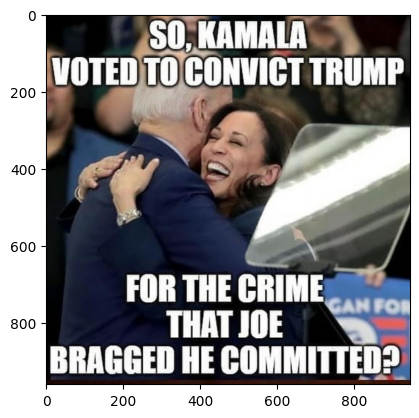


Text from random sample:
SO, KAMALA VOTED TO CONVICT TRUMP FOR THE CRIME THAT JOE BRAGGED HE COMMITTED?


Labels from random sample:
['Doubt', 'Loaded Language', "Misrepresentation of Someone's Position (Straw Man)", 'Whataboutism']


In [ ]:
# Plot the image from the random sample
image_path = random_sample['image'].values[0]  # Get the image path from the random sample
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.show()

# Print the associated text and labels from the sample
print("\nText from random sample:")
print(random_sample['text'].values[0])

print("\nLabels from random sample:")
print(random_sample['labels'].values[0])

Since images play an important role in conveying context so as not to lead to misinformation, we will now have to verify the extent to which images amplify disinformation and address it. To be more specific, two samples are given below to show that the image's content and the labels should match, providing the understand of the meme.

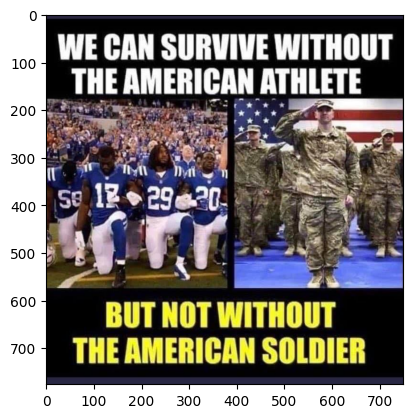

Text from random sample: 
WE CAN SURVIVE WITHOUT THE AMERICAN ATHLETE BUT NOT WITHOUT THE AMERICAN SOLDIER
Labels from random sample:
['Flag-waving', 'Glittering generalities (Virtue)', 'Smears', 'Transfer']


In [ ]:
sample = combined_df[combined_df['labels'].apply(lambda x: "Transfer" in x)].sample(1)
img = Image.open(sample['image'].values[0])

# Display the image
plt.imshow(img)
plt.show()

# Print the associated text and labels from the sample
print("Text from random sample: ")
print(sample['text'].values[0])

print("Labels from random sample:")
print(sample['labels'].values[0])

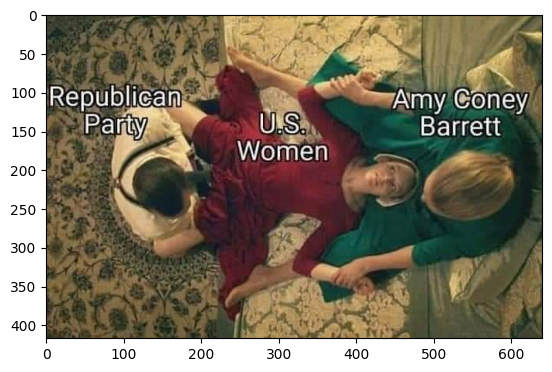

Text from random sample: 
Republican Party

U.S. Women

Amy Coney Barrett

Labels from random sample:
['Appeal to (Strong) Emotions', 'Smears']


In [ ]:
sample = combined_df[combined_df['labels'].apply(lambda x: "Appeal to (Strong) Emotions" in x)].sample(1)
img = Image.open(sample['image'].values[0])

# Display the image
plt.imshow(img)
plt.show()

# Print the associated text and labels from the sample
print("Text from random sample: ")
print(sample['text'].values[0])

print("Labels from random sample:")
print(sample['labels'].values[0])

Also, as you can see, the two samples are of different sizes, so we have to resize and set the size of all the images to be the same. Here, we will define 224x224 as the standard size for all the images to be used for pre-trained CNNs like ResNet50.

### c. Visualizing the Label Distribution

In [ ]:
# Function to visualize the distribution of labels
def visualize_label_distribution(dataframe, plot_title):
    # Flatten the 'labels' column into a single list
    label_list = dataframe['labels'].explode().tolist()

    # Compute the frequency of each label
    label_frequencies = Counter(label_list)

    # Extract labels and corresponding counts
    label_names = list(map(str, label_frequencies.keys()))
    label_counts = list(label_frequencies.values())

    # Create a color palette for the bars
    colors = plt.cm.viridis(np.linspace(0, 1, len(label_names)))

    # Generate a horizontal bar plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(label_names, label_counts, color=colors, edgecolor='black')

    # Add data labels at the end of each bar
    for bar in bars:
        xval = bar.get_width()
        plt.text(xval + 0.5, bar.get_y() + bar.get_height()/2, int(xval),
                 va='center', fontsize=10, fontweight='bold')

    # Set axis labels and title
    plt.xlabel('Frequency', fontsize=14, fontweight='bold')
    plt.ylabel('Labels', fontsize=14, fontweight='bold')
    plt.title(plot_title, fontsize=16, fontweight='bold')

    # Add grid lines for better readability
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Adjust layout to fit everything properly
    plt.tight_layout()

    # Show the plot
    plt.show()

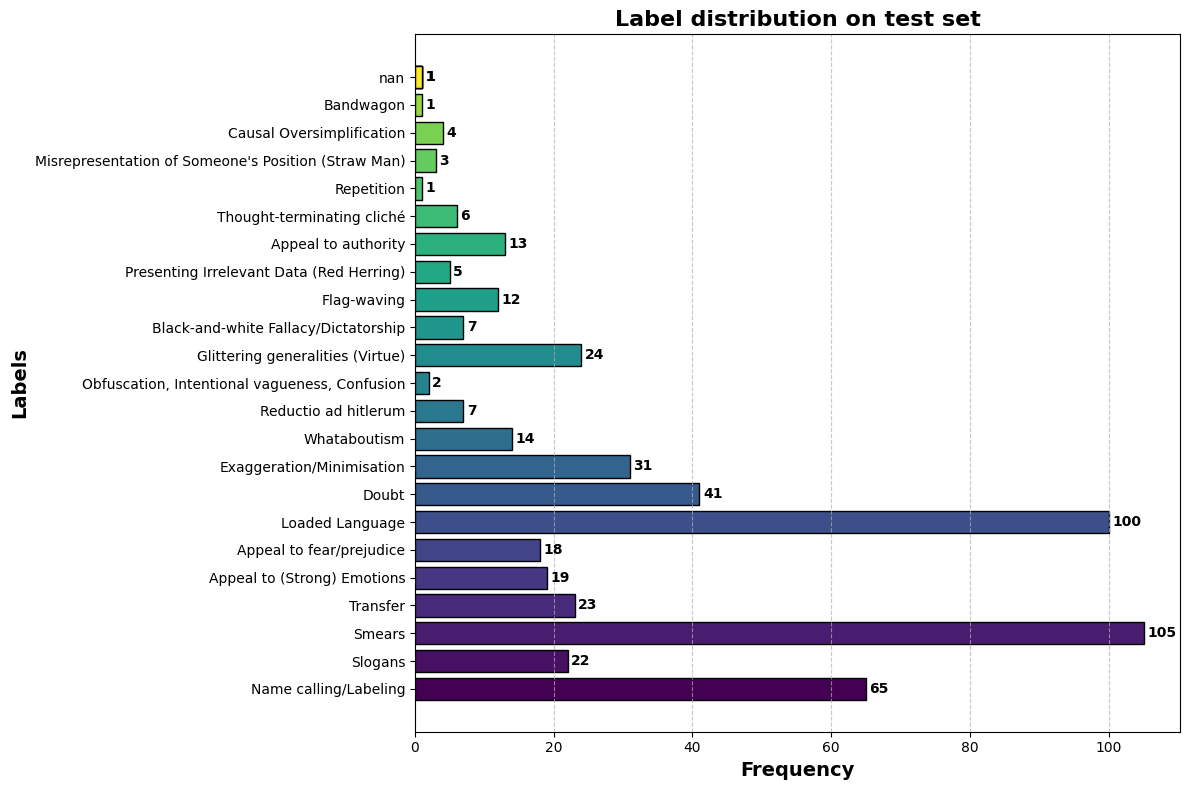

In [ ]:
visualize_label_distribution(test_df, 'Label distribution on test set')

Observation:

*   The label "Smears" appears most frequently, followed by "Loaded Language" and "Name calling/Labeling."
*   Other labels like "Slogans," "Transfer," "Appeal to (Strong) Emotions," and "Appeal to fear/prejudice" show moderate frequencies.
*   Several labels, such as "Repetition," "Thought-terminating cliché," and "Causal Oversimplification," are underrepresented, appearing very few times.
*   There's an "NaN" category as well, which may indicate missing or unlabeled data.





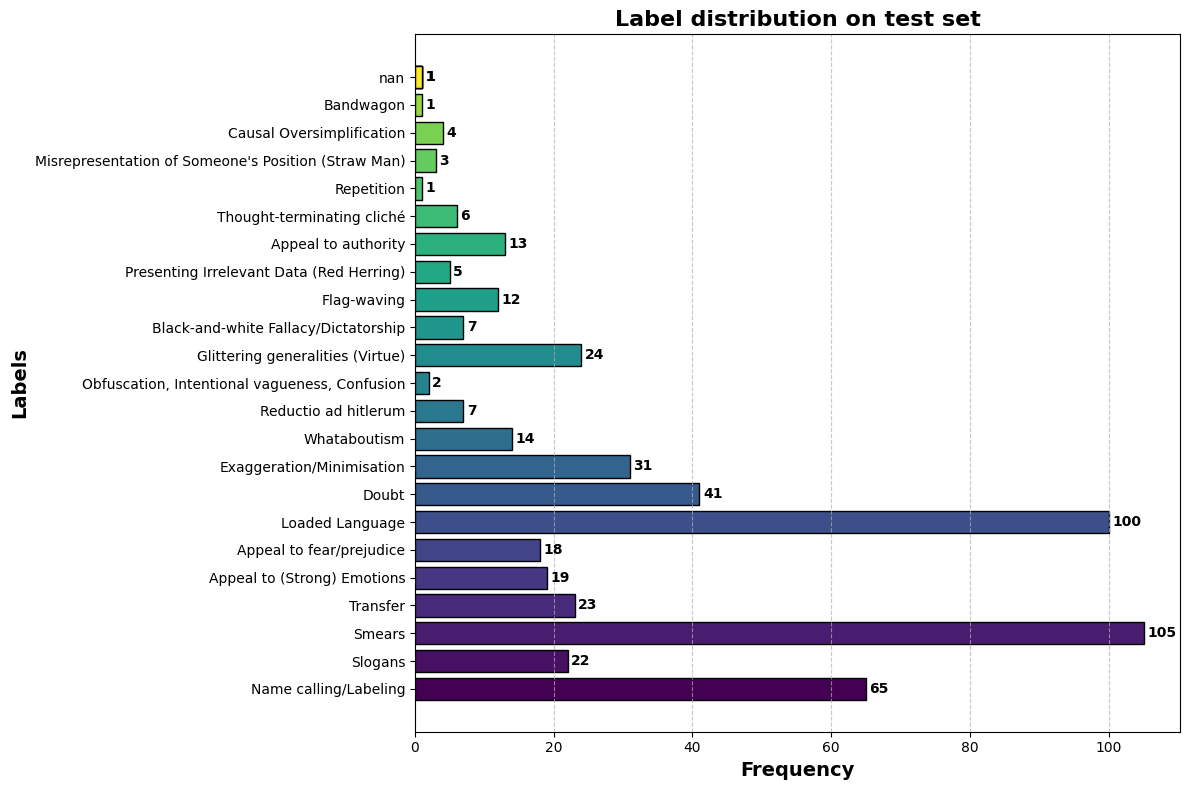

In [ ]:
visualize_label_distribution(test_df, 'Label distribution on test set')

Observation:

*   This plot looks nearly identical to the first plot in terms of distribution and frequencies of each label.
*   The label distribution is the same, with "Smears," "Loaded Language," and "Name calling/Labeling" being dominant.
*   The presence of NaN values indicates some unlabeled or missing instances.
*   There are several other labels that appear far less frequently, suggesting an imbalanced dataset.



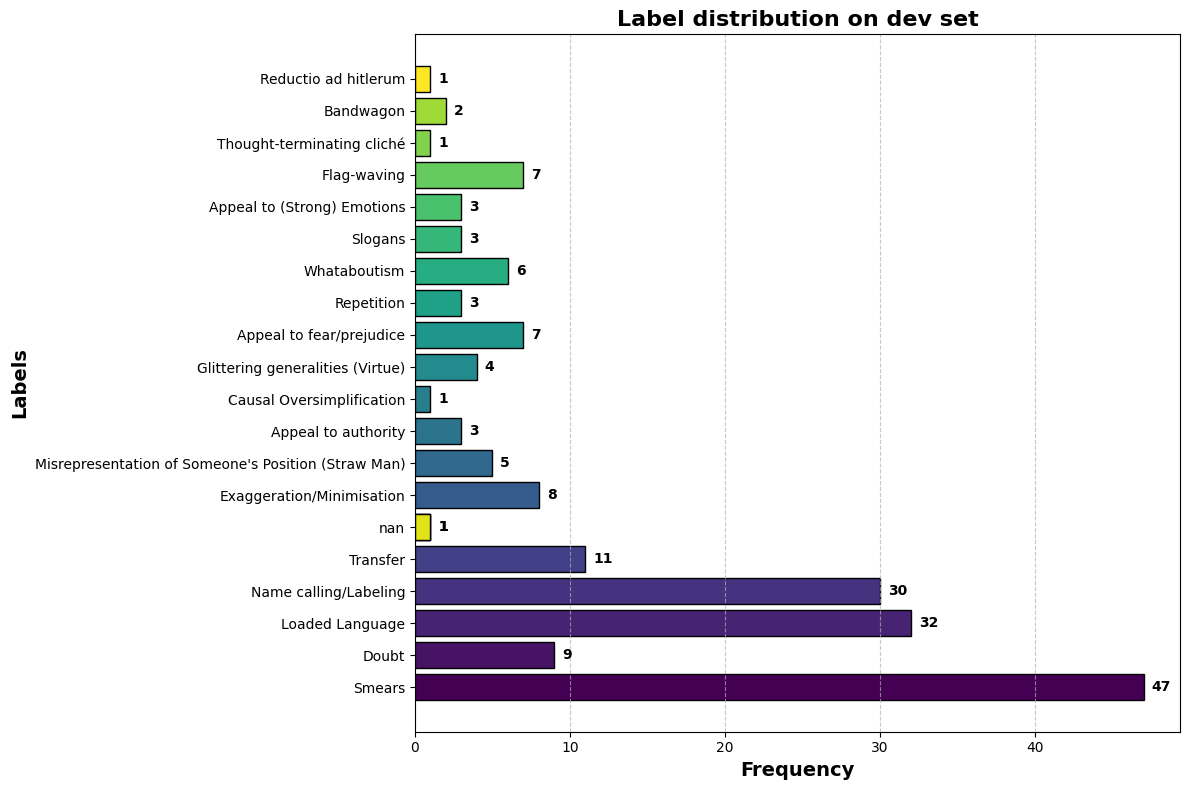

In [ ]:
visualize_label_distribution(dev_df, 'Label distribution on dev set')

Observation:

*   The development set shows a similar but slightly different distribution compared to the test set.
*   "Smears" again dominates in frequency, but the next most frequent labels are "Loaded Language," "Name calling/Labeling," and "Doubt."
*   The label distribution seems less even than the test set, with some labels having very few instances.
*   Once again, there are NaN values present, indicating missing labels in the dev set as well.



Since there are many values arising with missing labels and the dataset is extremely unbalanced, we have investigate those missing values and handle the imbalance problem before training the data.

### d. Checking and Handling the Missing values

First I use .isna().sum() to check if there are any missing values (NaNs) in the columns 'labels', 'text', and 'image' of the train_df, test_df, and dev_df dataframes.

In [ ]:
train_df.isna().sum()

labels    0
text      0
image     0
dtype: int64

In [ ]:
test_df.isna().sum()

labels    0
text      0
image     0
dtype: int64

In [ ]:
dev_df.isna().sum()

labels    0
text      0
image     0
dtype: int64

Although there are no missing values (NaNs), I realize there might be an issue with empty lists in the labels column, meaning that while the 'labels' column contains a value, some of these values are empty lists, which indicate that no labels are associated with those instances.

In [ ]:
train_missing = train_df[train_df['labels'].apply(lambda x: x == [])]
len(train_missing)

29

In [ ]:
test_missing = test_df[test_df['labels'].apply(lambda x: x == [])]
len(test_missing)

4

In [ ]:
dev_missing = dev_df[dev_df['labels'].apply(lambda x: x == [])]
len(dev_missing)

3

Now I will sample one instance with missing labels (an empty list in the labels column) from train_missing to inspect what the data looks like.

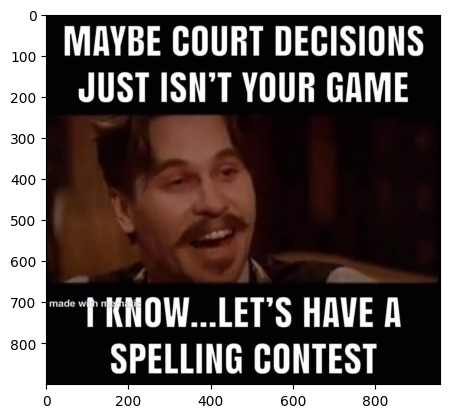

Text from random sample: 
MAYBE COURT DECISIONS JUST ISN'T YOUR GAME KNOW LET'S HAVE A SPELLING CONTEST
Labels from random sample:
[]


In [ ]:
sample = train_missing.sample(1)
img = Image.open(sample['image'].values[0])

# Display the image
plt.imshow(img)
plt.show()

# Print the associated text and labels from the sample
print("Text from random sample: ")
print(sample['text'].values[0])

print("Labels from random sample:")
print(sample['labels'].values[0])

As you can see the labels column contains an empty list ([]), it means that for that particular data entry (whether it's a text, image, or a combination of both), no labels have been assigned. In a supervised machine learning task, labels are used as the ground truth to train the model; they indicate the correct category or class for each input.

In [ ]:
train_df = train_df[~train_df.index.isin(train_missing.index)]
test_df = test_df[~test_df.index.isin(test_missing.index)]
dev_df = dev_df[~dev_df.index.isin(dev_missing.index)]

In [ ]:
# Check if deleted
len(train_df[train_df['labels'].apply(lambda x: x == [])])

0

However, during initial inspection of the raw data, I found out that the error was not due to the data loading process but rather the source dataset and some of the labels were actually blank from the source dataset.

### e. Text Preprocessing

In this section of the code, we focus on standardizing and preparing the text data for downstream machine learning tasks. The dataset contains various instances of textual information, often presented in different formats (e.g., some text is in uppercase, there are line breaks, etc.). Since this variety can confuse the model, it is important to preprocess the text for consistency and simplicity.

In natural language processing (NLP), case variations (uppercase, lowercase) can introduce unnecessary complexity to the model. For instance, words like "PRESIDENT," "president," and "President" could be interpreted differently by the model, even though they have the same meaning. To prevent this, the code above converts all text to lowercase. This step ensures that the model treats these variations consistently. The loop processes four dataframes (train_df, test_df, dev_df, and combined_df), and the str.lower() function applied to the 'text' column ensures that all text is converted to lowercase.

This uniform representation of words simplifies tokenization, avoids case-related discrepancies, and makes the text data easier for the model to interpret.

In [ ]:
# Convert text to lowercase for all DataFrames
for df in [train_df, test_df, dev_df, combined_df]:
    df['text'] = df['text'].str.lower()

# Replace double newlines with a separator token ('[SEP]')
for df in [train_df, test_df, dev_df, combined_df]:
    df['text'] = df['text'].str.replace('\n\n', '[SEP]')

Memes and other textual data often contain multiple sentences or separate thoughts indicated by line breaks or double newlines (\n\n). In these cases, preserving the structure of the text is important, as these line breaks may reflect distinct ideas or different parts of a conversation.

In [ ]:
train_df.head()

labels  \
0  [Black-and-white Fallacy/Dictatorship, Name ca...   
1           [Reductio ad hitlerum, Smears, Transfer]   
2  [Appeal to fear/prejudice, Loaded Language, Na...   
3  [Causal Oversimplification, Glittering general...   
4  [Flag-waving, Misrepresentation of Someone's P...   

                                                text  \
0  there are only two genders[SEP]female [SEP]male\n   
1                           this is not an accident!   
2  so bernie bros haven't committed violence eh?[...   
3  pathetic[SEP]the cowardly asshole\nweak failur...   
4  who trump represents[SEP]who democrats represe...   

                                               image  
0  /content/drive/MyDrive/COSC2779/s3927777-Assig...  
1  /content/drive/MyDrive/COSC2779/s3927777-Assig...  
2  /content/drive/MyDrive/COSC2779/s3927777-Assig...  
3  /content/drive/MyDrive/COSC2779/s3927777-Assig...  
4  /content/drive/MyDrive/COSC2779/s3927777-Assig...

The double newline between "There are only two genders" and "Female/Male" signifies a meaningful separation, which could help the model interpret the text more accurately. To retain this structure during preprocessing, the double newline characters (\n\n) are replaced with a special separator token [SEP]. This token allows the model to recognize the breaks between different parts of the text.

The [SEP] token is commonly used in transformer models (like BERT) to separate different segments of text, and it provides the model with a clear indication of where different ideas or sentences end.

In [ ]:
mlb = MultiLabelBinarizer(classes=techniques)

Then we prepare the labels for a multi-label classification task. The text examples are labeled with different propaganda techniques, such as Black-and-white Fallacy, Reductio ad hitlerum, and Appeal to fear/prejudice. Each text instance can have multiple labels associated with it (i.e., it could use more than one technique simultaneously).

The MultiLabelBinarizer is used to convert these labels into a format that is easier for the model to process. Instead of handling text labels directly, the labels are binarized (converted into a binary format), where each label is represented as a 0 or 1. This binarized format allows the model to predict the presence or absence of each technique for each text sample.

The classes=techniques argument ensures that the MultiLabelBinarizer is aware of all possible techniques that may be applied to the text data, even if not every sample contains all techniques.

In [ ]:
train_df.head()

labels  \
0  [Black-and-white Fallacy/Dictatorship, Name ca...   
1           [Reductio ad hitlerum, Smears, Transfer]   
2  [Appeal to fear/prejudice, Loaded Language, Na...   
3  [Causal Oversimplification, Glittering general...   
4  [Flag-waving, Misrepresentation of Someone's P...   

                                                text  \
0  there are only two genders[SEP]female [SEP]male\n   
1                           this is not an accident!   
2  so bernie bros haven't committed violence eh?[...   
3  pathetic[SEP]the cowardly asshole\nweak failur...   
4  who trump represents[SEP]who democrats represe...   

                                               image  
0  /content/drive/MyDrive/COSC2779/s3927777-Assig...  
1  /content/drive/MyDrive/COSC2779/s3927777-Assig...  
2  /content/drive/MyDrive/COSC2779/s3927777-Assig...  
3  /content/drive/MyDrive/COSC2779/s3927777-Assig...  
4  /content/drive/MyDrive/COSC2779/s3927777-Assig...

After preprocessing, we can see that:

*   Text is converted to lowercase: All words are now in lowercase, ensuring consistency.
*  Newline replacements: Double newline characters have been replaced with [SEP], preserving the segmentation of different parts of the text.
*   Labels are multi-labeled: Each text example is associated with one or more propaganda techniques, and this will be further binarized for easier model input.





This preprocessing step has prepared the text data for further stages, such as tokenization and training a multi-label classification model. The goal is to ensure the text is uniform and structured so that the model can effectively interpret and learn from the data

## ***III. Handling Class Imbalance and Model Approach***

### a. Dealing with Data Imbalance

Given the nature of this dataset, balancing the labels poses a significant challenge since each instance is associated with multiple labels rather than a single one. Traditional techniques like oversampling or undersampling are less effective in multi-label settings, and attempting to balance the dataset this way could lead to other issues such as overfitting or under-representing minority labels. To address this, we will adopt an alternative approach by modifying the loss function. Instead of using the standard binary cross-entropy, we employ Focal Loss.

Focal Loss is particularly useful for tackling class imbalance because it down-weights easy examples, allowing the model to focus more on hard-to-classify instances. However, this method alone might not fully resolve the imbalance challenge due to the extreme skewness in the label distribution, where a few dominant classes overshadow the minority ones. Focal Loss prioritizes difficult examples but doesn't inherently give preference to minority classes.

As a further step, instead of using the default 0.5 threshold for binary classification decisions, we will fine-tune the threshold for each individual label to help improve performance for under-represented classes.

### b. Performance goals

In a previous competition that utilized this dataset, the baseline model achieved a micro F1 score of 0.354 and a macro F1 score of 0.036. The best-performing model, which relied on sophisticated techniques and large pre-trained language models like BERT and RoBERTa, achieved a micro F1 score of 0.581 and a macro F1 score of 0.273.

Given that this task involves more modest resources and simplified models, we aim for a micro F1 score of 0.45 and a macro F1 score of 0.1 on the test set. It's crucial that the model performs reasonably well on both micro and macro F1 scores. A high micro F1 score without a corresponding improvement in macro F1 would indicate that the model is heavily biased toward majority classes, thus failing to predict minority classes effectively.

## ***IV. Baseline Model Architecture***

The proposed baseline model adopts a dual-branch architecture, which separately processes the **text** and **image** components of the meme before combining their features for final classification. This multi-modal approach leverages pre-trained models to capture both textual and visual information.

**Image Processing Branch**

*   **Pretrained Vision Model:** We utilize a pre-trained **ResNet50** model for image feature extraction. ResNet50 is well-established for its capability to extract high-level features from images, having been trained on large datasets like ImageNet. This allows us to benefit from its learned representations, reducing the need for extensive training on the meme dataset, which contains only around 1,000 images.


**Text Processing Branchr**

*   **Pretrained Language Model:** For text processing, we use a pre-trained transformer-based language model. Training a language model from scratch on a small dataset of meme text is impractical due to the complexity and varied nature of meme language. Thus, we rely on a model that has already been trained on vast amounts of text data to capture intricate relationships and nuances in language. While powerful models like **BERT** and **RoBERTa** are commonly used for such tasks, they require substantial computational resources. To mitigate this issue, we employ **ALBERT**, a lighter version of BERT that maintains competitive performance but with fewer parameters. This model can be fine-tuned efficiently on the meme dataset without overwhelming our resources.

**Combining Text and Image Features:**
The features extracted from both the image and text branches are concatenated to form a unified representation. This joint feature vector is then passed through a dense layer followed by a sigmoid activation function, which outputs independent probabilities for each label. The sigmoid function is particularly suitable for multi-label classification tasks, as it allows for the prediction of multiple labels for each meme.

**Optimizer:** For optimizing the model, we choose the Nadam optimizer (a combination of RMSprop and Nesterov Accelerated Gradient) for faster convergence. This optimizer helps the model adjust weights more efficiently during training, which is especially important given the complexity of combining text and image features.

**Justification for Model Components:**

*   **Text Processing:** Memes often include nuanced language that can convey multiple meanings, including sarcasm or humor, which are difficult to interpret without pre-trained models. ALBERT’s pretraining on large-scale text corpora equips it with the ability to understand these linguistic subtleties, making it the right choice for extracting meaningful text features in this multi-label setting. Its efficiency in terms of resource usage further justifies its selection, as we aim to balance performance with computational feasibility.
*   **Image Processing:** Visual elements in memes provide essential context that supports the interpretation of the text. For example, a sarcastic caption paired with an ironic image can drastically change the meaning. ResNet50, being trained on large image datasets, has learned to identify complex visual patterns that help the model infer this additional context. The pre-training allows us to skip the need for extensive training, ensuring quicker convergence and better generalization on limited meme images.

This dual-branch architecture, combining insights from both the text and image components of the meme, is crucial for achieving competitive performance in the task of multi-label classification.

#### a. Preprocessing Text and Images for ALBERT-Based Multi-Modal Model

*   The AutoTokenizer.from_pretrained() is used to load the ALBERT tokenizer (albert-large-v2).
*   For each text in the training dataset (train_df['text']), the tokenizer encodes the text into a sequence of tokens, adds two special tokens ([CLS] and [SEP]), and determines the length of the sequence.
*   The maximum sequence length is computed using the tokenized lengths. This ensures that the longest text is used as the padding threshold, so shorter texts are padded, and longer ones are truncated.



In [ ]:
# Define the ALBERT model and tokenizer
model_name = 'albert-large-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Calculate the maximum sequence length
sequence_lengths = [len(tokenizer.encode(text, add_special_tokens=False)) + 2 for text in train_df['text']]

# Determine the maximum length for padding
max_sequence_length = max(sequence_lengths)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


*   The load_and_preprocess_image() function reads an image file, decodes it into a 3-channel image, resizes it to the specified dimensions (IMAGE_WIDTH, IMAGE_HEIGHT), and optionally applies augmentation like random flips, brightness, and contrast adjustments.
*   The image is normalized to the range [0, 1] and clipped to ensure all pixel values are valid.



In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path, augment=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])

    if augment:
        image = tf.image.random_flip_left_right(image)
        # Apply random brightness and contrast adjustments
        image = tf.image.random_brightness(image, 0.5)
        image = tf.image.random_contrast(image, 0.8, 1.3)

    # Normalize image to [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32) / 255
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

# Function to convert DataFrames to TensorFlow datasets with BERT tokenization
def create_dataset_with_bert(df, tokenizer, shuffle_data=False, augment=False):
    image_paths = df['image'].values
    texts = df['text'].values

    # Tokenize text data with padding and truncation
    tokenized_inputs = tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_sequence_length,  # Include [CLS] and [SEP] tokens
        return_tensors='tf'
    )

    input_ids = tokenized_inputs['input_ids']
    attention_masks = tokenized_inputs['attention_mask']
    attention_masks = tf.cast(attention_masks, dtype=tf.int32)

    # Transform labels using multi-label binarizer
    encoded_labels = mlb.fit_transform(df['labels'])

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices(((image_paths, input_ids, attention_masks), encoded_labels))

    # Function to process each data point in the dataset
    def process_single_data(data, label):
        image_path, input_ids, attention_masks = data
        image = load_and_preprocess_image(image_path, augment=augment)
        return (image, input_ids, attention_masks), label

    dataset = dataset.map(process_single_data)
    dataset = dataset.shuffle(len(df)) if shuffle_data else dataset
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

*   The create_dataset_with_bert() function takes a DataFrame (either train, test, or dev dataset), the tokenizer, and options to shuffle and augment the data.
*   The function tokenizes the text column using tokenizer() with the specified max_sequence_length, padding and truncating as needed.
*   Labels are binarized using a multi-label binarizer (mlb), converting them into a multi-hot encoded format.
*   The function then creates a TensorFlow dataset by using tf.data.Dataset.from_tensor_slices() to combine the image paths, tokenized inputs (IDs and attention masks), and labels.
*   Each dataset entry is processed using process_single_data() to load the image and return the image, input IDs, and attention masks as a tuple, along with the labels.
*   The dataset is then batched and prefetched for efficient loading during training.

The train_dataset, test_dataset, and dev_dataset are created using the create_dataset_with_bert() function, which loads and processes the data into TensorFlow datasets. The training dataset is shuffled, while test and dev datasets are not shuffled.

In [ ]:
# Create TensorFlow datasets for training, testing, and development
train_dataset = create_dataset_with_bert(train_df, tokenizer=tokenizer, shuffle_data=True)
test_dataset = create_dataset_with_bert(test_df, tokenizer=tokenizer, shuffle_data=False)
dev_dataset = create_dataset_with_bert(dev_df, tokenizer=tokenizer, shuffle_data=False)

*   The visualize_dataset() function takes a dataset and visualizes a batch of images and the corresponding tokenized input IDs.
*   For each batch, it extracts the image, token IDs, and label of the first item, displays the image using matplotlib, and prints out the token IDs and decoded labels (in text form).
*   The labels are decoded using the mlb.inverse_transform() function to convert them back to readable label names.



In [ ]:
def visualize_dataset(ds):
    for data_batch, labels_batch in ds.take(1):
        images, input_ids, attention_masks = data_batch
        first_image, first_input_id, first_label = images[0], input_ids[0], labels_batch[0]

        plt.imshow(first_image)
        label_strings = mlb.inverse_transform(np.array([first_label.numpy()]))
        print(first_input_id)
        print(label_strings)

tf.Tensor(
[    2    13     7   821 15222    38  7301    18  4847    22    38   683
    15  3271   483    59  1893    20   805    27    17   168    65    14
    85    60     7     3    13     7   124   205  1215   483    42   196
   154  1090    27    21  1191   208    15    47    52    21  1047   208
    15 26660     9     7     3     3     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0], shape=(101,), dtype=int32)
[('Doubt', 'Loaded Language', 'Name calling/Labeling', 'Smears')]


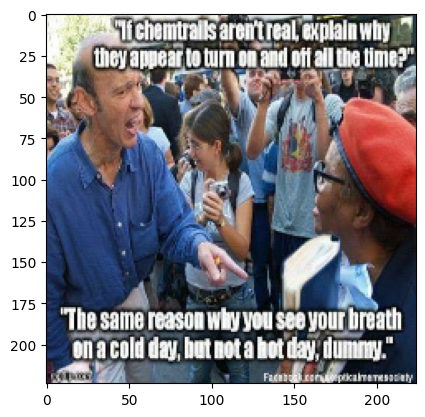

In [ ]:
visualize_dataset(train_dataset)

tf.Tensor(
[   2   14 7806   78  740    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(101,), dtype=int32)
[('Name calling/Labeling', 'Slogans', 'Smears', 'Transfer')]


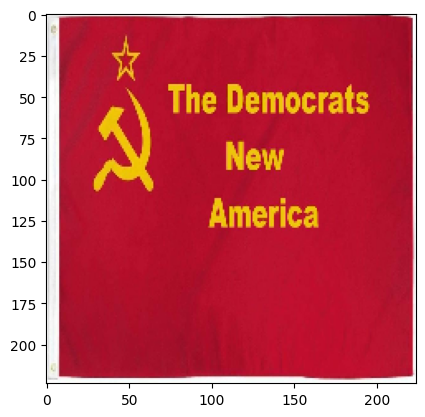

In [ ]:
visualize_dataset(test_dataset)

tf.Tensor(
[   2 1637 6416 2483 4458  219   60    3 2247   15   90    9    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(101,), dtype=int32)
[('Doubt', 'Smears')]


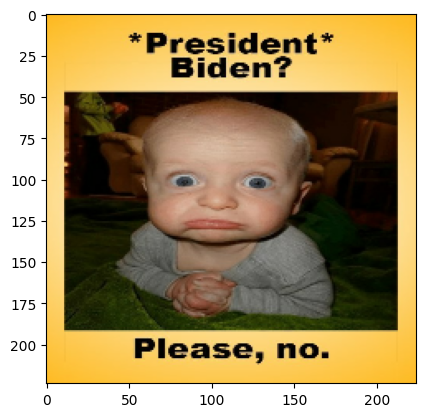

In [ ]:
visualize_dataset(dev_dataset)

#### b. Model Training and Evaluation

**Freezing the Image Extractor and Fine-Tuning ALBERT:**

*   The image feature extractor, ResNet50V2, is pre-trained on ImageNet and can extract useful image features without requiring further fine-tuning. Therefore, we set image_extractor.trainable = False to freeze its weights.
*  ALBERT (a version of BERT) benefits from task-specific fine-tuning, as the pre-trained language model may not fully capture the nuances of the task at hand. Hence, the ALBERT model is set as trainable with model_name.trainable = True.

**Building the Baseline Model**

*   The baseline model consists of two branches:
  *   Image branch: Takes an image input and processes it through the frozen ResNet50V2 model, followed by global average pooling to get image features.

  *   Text branch: Uses ALBERT to process input tokens and attention masks. Global average pooling is applied to ALBERT’s hidden states to get text features.
  
*   These image and text features are concatenated and passed to a final dense layer with a sigmoid activation to predict multi-label classifications based on the techniques.






In [ ]:
def build_baseline_model():
    # Load the ALBERT model
    model_name= TFAutoModel.from_pretrained("albert-large-v2")
    model_name.trainable = True

    # Initialize the image feature extractor
    image_extractor = applications.ResNet50V2(include_top=False, weights="imagenet")
    image_extractor.trainable = False

    # Define the image input branch
    image_input = layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    image_features = image_extractor(image_input)
    image_features = layers.GlobalAveragePooling2D()(image_features)

    # Define the text input branch
    input_ids = layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')
    text_embeddings = model_name(input_ids, attention_mask=attention_mask)[0]  # Extract hidden states
    text_features = layers.GlobalAveragePooling1D()(text_embeddings)

    # Combine both branches
    combined_features = layers.Concatenate()([image_features, text_features])
    output_layer = layers.Dense(len(techniques), activation='sigmoid')(combined_features)

    # Construct the model
    model = models.Model(inputs=[image_input, input_ids, attention_mask], outputs=output_layer)

    # Compile the model
    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-6)
    model.compile(optimizer=optimizer,
                  loss=losses.BinaryFocalCrossentropy(from_logits=False),
                  metrics=define_metrics())

    return model, model_name, image_extractor

The **AlbertTokenizer** is used to tokenize sample text. The tokenizer converts the text into token IDs (input_ids), token type IDs, and an attention mask, which is used to indicate which tokens are relevant during processing.

In [ ]:
# Load pre-trained tokenizer and model
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = TFAlbertModel.from_pretrained('albert-base-v2')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [ ]:
# Example text
sample_text = ["TRUMP IS GONNA FIX THE SHITTY JOB THE CURRENT PRESIDENT IS DOING"]

# Tokenization
inputs = tokenizer(sample_text, padding=True, truncation=True, return_tensors="tf")

print(inputs)

{'input_ids': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=
array([[    2,  7095,    25,  5172,  6098,    14, 28349,  1205,    14,
          866,   406,    25,   845,     3]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [ ]:
baseline, model_name, image_extractor = build_baseline_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


**Learning Rate Schedule:**
A custom learning rate schedule is defined using lr_schedule(), where the learning rate remains constant for the first 10 epochs and then reduces by a factor of 10 for epochs between 10 and 20 to fine-tune the model more delicately.

**Callbacks:**
The configure_callbacks() function configures a callback for early stopping based on validation F1_Micro to avoid overfitting. The best model weights are restored when the validation performance peaks.

**Defining Metrics:**
Two F1 score metrics are defined: F1_Macro (which averages across all labels) and F1_Micro (which weighs the contribution of each label by the number of true instances).

In [ ]:
# Define learning rate schedule
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif 10 <= epoch < 20:
        return lr * 0.1

# Helper function to configure callbacks
def configure_callbacks(callbacks_list=None):
    if callbacks_list is None:
        callbacks_list = []

    final_callbacks = list(callbacks_list)

    early_stop = tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor="val_F1_Micro",
        mode="max"
    )
    final_callbacks.append(early_stop)

    return final_callbacks

def define_metrics():
    macro_f1 = tfa.metrics.F1Score(
        num_classes=len(techniques),
        average='macro',
        threshold=0.5,
        name="F1_Macro"
    )

    micro_f1 = tfa.metrics.F1Score(
        num_classes=len(techniques),
        average='micro',
        threshold=0.5,
        name="F1_Micro"
    )

    return [macro_f1, micro_f1]

In [ ]:
# Fit the model
baseline_history = baseline.fit(
    train_dataset,
    validation_data=dev_dataset,
    epochs=10,
    callbacks=configure_callbacks(),
    verbose=True,
)

Epoch 1/10


165/165 [==============================] - 533s 3s/step - loss: 0.1677 - F1_Macro: 0.1233 - F1_Micro: 0.2552 - val_loss: 0.1325 - val_F1_Macro: 0.1242 - val_F1_Micro: 0.3333
Epoch 2/10
165/165 [==============================] - 476s 3s/step - loss: 0.1115 - F1_Macro: 0.1033 - F1_Micro: 0.3775 - val_loss: 0.1286 - val_F1_Macro: 0.0985 - val_F1_Micro: 0.3620
Epoch 3/10
165/165 [==============================] - 477s 3s/step - loss: 0.1073 - F1_Macro: 0.1043 - F1_Micro: 0.3995 - val_loss: 0.1252 - val_F1_Macro: 0.1106 - val_F1_Micro: 0.3642
Epoch 4/10
165/165 [==============================] - 470s 3s/step - loss: 0.1043 - F1_Macro: 0.1042 - F1_Micro: 0.3999 - val_loss: 0.1243 - val_F1_Macro: 0.1069 - val_F1_Micro: 0.3780
Epoch 5/10
165/165 [==============================] - 475s 3s/step - loss: 0.1019 - F1_Macro: 0.1080 - F1_Micro: 0.4194 - val_loss: 0.1211 - val_F1_Macro: 0.1152 - val_F1_Micro: 0.3810
Epoch 6/10
165/165 [==============================] - 478s 3s/step - loss: 0.0990 - F1

In [ ]:
# Visualize training history
def visualize_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].plot(epochs, history.history['F1_Macro'], label='Train Macro F1')
    axes[0, 0].plot(epochs, history.history['val_F1_Macro'], label='Val Macro F1')
    axes[0, 0].set_title('Macro F1: Train vs Validation')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].legend()

    axes[0, 1].plot(epochs, history.history['F1_Micro'], label='Train Micro F1')
    axes[0, 1].plot(epochs, history.history['val_F1_Micro'], label='Val Micro F1')
    axes[0, 1].set_title('Micro F1: Train vs Validation')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].legend()

    axes[1, 0].plot(epochs, history.history['loss'], label='Train Loss')
    axes[1, 0].plot(epochs, history.history['val_loss'], label='Val Loss')
    axes[1, 0].set_title('Loss: Train vs Validation')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()

    fig.delaxes(axes[1, 1])
    plt.tight_layout()
    plt.show()

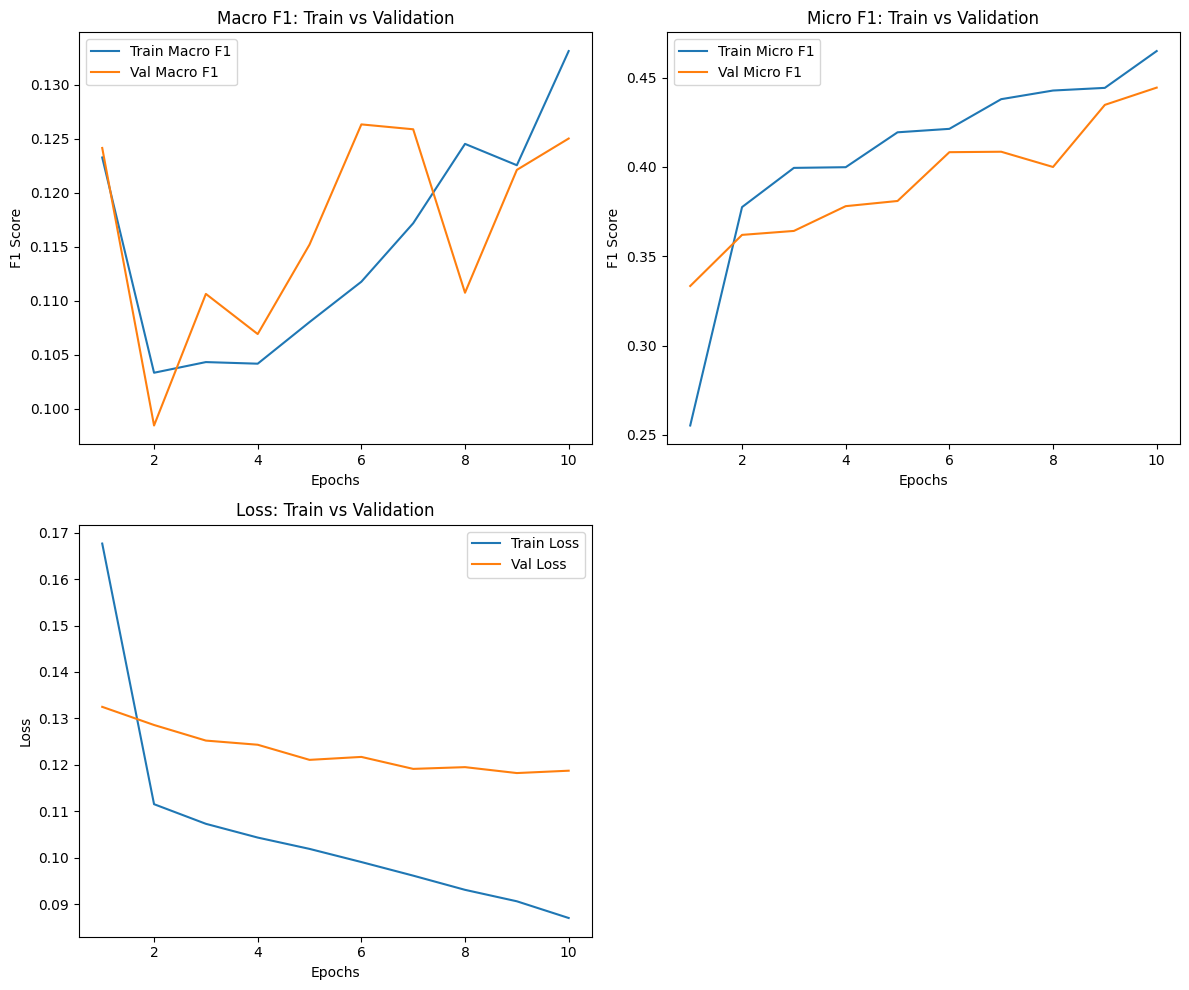

In [ ]:
visualize_training_history(baseline_history)

In [ ]:
baseline.evaluate(test_dataset)

49/49 [==============================] - 47s 950ms/step - loss: 0.1302 - F1_Macro: 0.1285 - F1_Micro: 0.3931


[0.13015402853488922, 0.1284809112548828, 0.3931451737880707]

The three plots you provided represent the performance of your multi-modal model (combining ResNet50V2 for image features and ALBERT for text features) over 10 epochs, focusing on both F1 score and loss metrics. Here's an observation of each plot:

*   **Macro F1: Train vs Validation (Top-left)**
  *   **Macro F1** score averages the F1 scores for each class, treating all classes equally, even in the case of class imbalance.
  *   **The train macro F1 score** (blue line) fluctuates in the early epochs (from epoch 1 to 4), showing some instability but generally trends upward after that. It indicates the model is gradually learning, although it starts off slowly.
  *   **The validation macro F1 score** (orange line) follows a similar pattern but is more volatile, especially around epochs 2, 5, and 9. This indicates that the model's ability to generalize to unseen data is inconsistent during training, possibly hinting at underfitting or difficulty in learning generalized features from the dataset.

*   **Micro F1: Train vs Validation (Top-right)**

  *   **Micro F1** score averages F1 scores by considering the total true positives, false negatives, and false positives. It tends to give more weight to the majority class.
  *   Both the **train micro F1 score** and **validation micro F1** score steadily increase over time, indicating that the model is improving at making predictions across all classes.
  *   The training curve shows a consistent upward trend with only minor fluctuations, which implies that the model is learning well on the training data.
  *   The validation micro F1 score improves but lags behind the training curve slightly. However, the gap between training and validation is not very large, which suggests the model is not overfitting, but may still need more training or hyperparameter tuning to achieve better generalization.

*   **Loss: Train vs Validation (Bottom)**

  *   **Train loss** (blue line) decreases steadily over the epochs, which is a good sign that the model is optimizing well on the training data.
  *   **Validation loss** (orange line) decreases at the beginning (until around epoch 3) but then plateaus and shows minor fluctuations without much improvement beyond that.
  *   The gap between training and validation loss widens as epochs progress, signaling potential overfitting. The model is learning the training data well (as indicated by decreasing training loss), but its performance on unseen data (validation set) does not improve much after the initial epochs.

## ***V. Dual Transformer Model Implementation***

This code implements a dual transformer model to fuse image and text features for multimodal tasks. The model is designed to extract features from both text and image inputs using transformers, which contextualize the relationship between the two modalities.

### a. Transformer implementation as Layer

The AttentionBlock is a custom Transformer block implementing multi-head attention and a feed-forward network:

*   **Multi-Head Attention:** This layer helps the model attend to different parts of the input by computing attention over multiple “heads.” This enables the model to capture various relationships within the data.
*   **Layer Normalization:** After attention, the output is normalized, which helps stabilize training.
*   **Feed-Forward Network:** A two-layer fully connected network, followed by dropout to prevent overfitting.
*   **Residual Connections:** The input is added to the output of both attention and feed-forward layers to enable better gradient flow.







In [ ]:
clear_session()

In [ ]:
class AttentionBlock(layers.Layer):
    def __init__(self, d_model, num_heads, dff_units, dropout_prob=0.1, l2_reg=0.01):
        super(AttentionBlock, self).__init__()
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_prob)
        self.norm_1 = layers.LayerNormalization()
        self.feed_forward = tf.keras.Sequential([
            layers.Dense(dff_units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2_reg)),
            layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.L2(l2_reg)),
            layers.Dropout(dropout_prob),
        ])
        self.norm_2 = layers.LayerNormalization()

    def call(self, inputs, attention_mask=None):
        # Multi-head attention
        attention_output = self.multi_head_attention(inputs, inputs, attention_mask=attention_mask)
        attention_output = self.norm_1(inputs + attention_output)

        # Feed-forward network
        ff_output = self.feed_forward(attention_output)
        return self.norm_2(attention_output + ff_output)

The EncoderStack class stacks multiple AttentionBlock layers to form the Transformer encoder:

*   **Multiple Attention Blocks:** The encoder contains multiple stacked AttentionBlock layers, which learn to encode the input (either text or image) into representations.
*   **Attention Mask:** An optional mask is applied to ignore certain parts of the input during attention computation.





In [ ]:
class EncoderStack(layers.Layer):
    def __init__(self, d_model, num_heads, dff_units, dropout_prob=0.1, num_layers=2, l2_reg=0.01):
        super(EncoderStack, self).__init__()
        self.encoder_layers = [AttentionBlock(d_model, num_heads, dff_units, dropout_prob, l2_reg) for _ in range(num_layers)]

    def call(self, inputs, attention_mask=None):
        x = inputs
        for layer in self.encoder_layers:
            x = layer(x, attention_mask)
        return x

The CrossAttentionBlock introduces cross-modal attention, allowing the decoder to attend to both its own input and the encoder's output:

*   **Self-Attention:** Computes attention over the input itself (like a standard transformer).
*   **Cross-Attention:** Computes attention by attending to the encoder's output, enabling the model to focus on relevant parts of the image/text while decoding.
*   **Feed-Forward Network:** This follows the attention layers, and similar to the encoder block, it has a two-layer fully connected network.






In [ ]:
class CrossAttentionBlock(layers.Layer):
    def __init__(self, d_model, num_heads, dff_units, dropout_prob=0.1, l2_reg=0.01):
        super(CrossAttentionBlock, self).__init__()
        self.self_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_prob)
        self.cross_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_prob)
        self.norm_1 = layers.LayerNormalization()
        self.norm_2 = layers.LayerNormalization()
        self.feed_forward = tf.keras.Sequential([
            layers.Dense(dff_units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2_reg)),
            layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.L2(l2_reg)),
            layers.Dropout(dropout_prob),
        ])
        self.norm_3 = layers.LayerNormalization()

    def call(self, inputs, encoder_outputs, causal_mask=None, decoder_mask=None, encoder_mask=None):
        # Self-attention
        self_attention_output = self.self_attention(inputs, inputs, attention_mask=causal_mask & decoder_mask if causal_mask is not None else decoder_mask)
        out1 = self.norm_1(inputs + self_attention_output)

        # Cross-attention with encoder outputs
        cross_attention_output = self.cross_attention(out1, encoder_outputs, attention_mask=encoder_mask)
        out2 = self.norm_2(out1 + cross_attention_output)

        # Feed-forward network
        ff_output = self.feed_forward(out2)
        return self.norm_3(out2 + ff_output)

The DecoderStack class builds a decoder with cross-modal attention:

*   **Stacking Cross-Attention Blocks:** Multiple CrossAttentionBlock layers are used, allowing the model to learn complex mappings between text and image features.
*   **Causal Mask:** Ensures that the model can’t “see” future tokens, maintaining the autoregressive property in the decoder.





In [ ]:
class DecoderStack(layers.Layer):
    def __init__(self, d_model, num_heads, dff_units, dropout_prob=0.1, num_layers=2, l2_reg=0.01):
        super(DecoderStack, self).__init__()
        self.decoder_layers = [CrossAttentionBlock(d_model, num_heads, dff_units, dropout_prob, l2_reg) for _ in range(num_layers)]

    def call(self, inputs, encoder_outputs, causal_mask=None, decoder_mask=None, encoder_mask=None):
        x = inputs
        for layer in self.decoder_layers:
            x = layer(x, encoder_outputs, causal_mask, decoder_mask, encoder_mask)
        return x

This class ties everything together by defining the overall Transformer model structure:

*   **Encoder:** Encodes the input (text or image) using the EncoderStack.
*   **Decoder:** Decodes the contextualized representation by attending to the encoder output, allowing the text to condition on image features (and vice versa).
*   **Attention Masks:** These masks ensure that certain inputs are ignored (e.g., padding).






In [ ]:
class CustomTransformer(layers.Layer):
    def __init__(self, d_model, dff_units, num_heads=4, dropout_prob=0.1, num_encoders=2, num_decoders=2, l2_reg=0.01):
        super(CustomTransformer, self).__init__()
        self.encoder = EncoderStack(d_model, num_heads, dff_units, dropout_prob, num_layers=num_encoders, l2_reg=l2_reg)
        self.decoder = DecoderStack(d_model, num_heads, dff_units, dropout_prob, num_layers=num_decoders, l2_reg=l2_reg)

    def call(self, encoder_input, decoder_input, encoder_mask=None, decoder_mask=None, causal_mask=None):
        # Encoder pass
        encoder_output = self.encoder(encoder_input, attention_mask=encoder_mask)

        # Decoder pass
        decoder_output = self.decoder(decoder_input, encoder_output, causal_mask=causal_mask, decoder_mask=decoder_mask, encoder_mask=encoder_mask)

        return decoder_output

### b. Dual Transformer model

#### Define layers

The VisualEncoder extracts image features using a CNN:

*   **CNN Backbone:** Uses ResNet50V2 to extract high-level features from images.
*   **Adaptive Pooling:** Ensures the output shape is fixed, regardless of the input image size, by applying adaptive pooling.

In [ ]:
class VisualEncoder(layers.Layer):
    def __init__(self, backbone_model=None, pooling_size=(7, 7)):
        super(VisualEncoder, self).__init__()
        # Default to ResNet50V2 if no model provided
        if backbone_model is None:
            self.cnn_backbone = ResNet50V2(include_top=False, weights="imagenet")
            self.cnn_backbone.trainable = False
        else:
            self.cnn_backbone = backbone_model

        self.feature_dim = self.cnn_backbone.output_shape[-1]
        self.adaptive_pooling = tfa.layers.AdaptiveAveragePooling2D(output_size=pooling_size)

    def call(self, input_image):
        # Extract spatial features from image using CNN
        cnn_features = self.cnn_backbone(input_image)
        pooled_features = self.adaptive_pooling(cnn_features)
        return pooled_features  # Shape: (batch_size, 7, 7, feature_dim)

The LanguageEncoder handles text input using the ALBERT transformer model:

*   **ALBERT Transformer:** A pre-trained language model that processes the text and generates hidden state representations for the tokens.
*   **Output:** The last hidden state is used as the text representation.

In [ ]:
class LanguageEncoder(layers.Layer):
    def __init__(self, is_trainable=True, use_large_model=True, pretrained_model=None):
        super(LanguageEncoder, self).__init__()
        # Use albert-large-v2 by default or accept a custom pretrained model
        model_name = "albert-large-v2" if use_large_model else "albert-base-v2"

        if pretrained_model is None:
            config = AlbertConfig.from_pretrained(model_name, output_hidden_states=True)
            self.language_model = TFAutoModel.from_pretrained(model_name, config=config)
            self.language_model.trainable = is_trainable
        else:
            self.language_model = pretrained_model

    def call(self, input_ids, attention_masks):
        outputs = self.language_model(input_ids, attention_mask=attention_masks)
        hidden_states = outputs.hidden_states[-1]
        return hidden_states  # Shape: (batch_size, seq_len, hidden_size)

This class adds positional information to the image features:

*   **Coordinates Grid:** Positional encoding is generated based on a grid that encodes spatial information about where the image features are located.
*   **Dense Projection:** Projects the positional information into the same dimension as the image features and adds it to the input.

In [ ]:
class PositionalEncoding(layers.Layer):
    def __init__(self, embedding_dim, num_regions=(4, 4)):
        super(PositionalEncoding, self).__init__()
        assert num_regions[0] == num_regions[1], "Grid must be square for positional encoding."
        self.num_regions = num_regions
        self.coords = self.generate_coordinates(num_regions[0])
        self.projection_layer = layers.Dense(embedding_dim)

    @staticmethod
    def generate_coordinates(grid_size):
        coords = np.linspace(-1., 1., grid_size)
        x = np.tile(coords, (grid_size, 1))
        y = np.tile(coords.reshape(grid_size, 1), (1, grid_size))
        grid_coords = np.stack((x, y), axis=-1)
        return tf.convert_to_tensor(grid_coords, dtype=tf.float32)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        reshaped_coords = tf.reshape(self.coords, (self.num_regions[0] ** 2, -1))
        pos_encoding = self.projection_layer(reshaped_coords)
        pos_encoding = tf.expand_dims(pos_encoding, axis=0)
        return inputs + tf.repeat(pos_encoding, repeats=batch_size, axis=0)

This is the core class that handles the interaction between text and image features:

*   **Two Transformers:** It uses two custom transformers:
  *   **Text-on-Image Transformer:** Text input conditions the image representation.
  *   **Image-on-Text Transformer:** Image features condition the text representation.
*   **Projections:** Both the text and image features are projected into a common representation space.
*   **Positional Encoding for Image:** Positional encoding is applied to the image features before passing them to the transformer.

In [ ]:
class DualTransformer(layers.Layer):
    def __init__(self, embd_dim, ff_dim, n_heads=4, n_encoders=4, n_decoders=4, vis_feats_dim=2048, grid=(7, 7), dropout_rate=0.1):
        super().__init__()

        self.text_on_image_transformer = CustomTransformer(d_model=embd_dim, dff_units=ff_dim, num_heads=n_heads,
                                                           dropout_prob=dropout_rate, num_encoders=n_encoders,
                                                           num_decoders=n_decoders)
        self.image_on_text_transformer = CustomTransformer(d_model=embd_dim, dff_units=ff_dim, num_heads=n_heads,
                                                           dropout_prob=dropout_rate, num_encoders=n_encoders,
                                                           num_decoders=n_decoders)

        self.text_proj = layers.Dense(embd_dim)
        self.image_proj = layers.Dense(embd_dim)

        self.pos_encoder = PositionalEncoding(vis_feats_dim, grid)

    def call(self, text, attn_masks, image):
        # text is textual features, image is spatial features
        bs = tf.shape(text)[0]

        # Project text to common representation space
        text = self.text_proj(text)

        # Reshape image to (batch_size, num_patches, feature_dim)
        image = tf.reshape(image, (bs, tf.shape(image)[1]**2, tf.shape(image)[-1]))

        # Augment visual features with positional encoding and project them
        image = self.pos_encoder(image)
        image = self.image_proj(image)

        # Convert attention masks to boolean
        attn_masks = tf.cast(attn_masks, dtype=tf.bool)
        attn_masks = tf.expand_dims(attn_masks, axis=1)

        # Image transformer conditioned on text
        image_out = self.image_on_text_transformer(text, image, encoder_mask=attn_masks)

        # Text transformer conditioned on image
        text_out = self.text_on_image_transformer(image, text, decoder_mask=attn_masks)

        return image_out, text_out

This class combines the visual and textual modules and produces the final predictions:

*   **Visual and Textual Encoders:** It processes image and text inputs through their respective encoders.
*   **Dual Transformer Processing:** The encoders’ outputs are passed through the dual transformer to generate contextualized representations of both image and text.
*   **Classification Heads:** Two dense layers make predictions, one for the image and one for the text. The outputs are averaged to form the final prediction.

In [ ]:
class MultiModalClassifier(models.Model):
    def __init__(self, embd_dim=1024, ff_dim=1024, n_heads=4, n_encoders=4, n_decoders=4, vis_feats_dim=2048,
                 grid=(7, 7), dropout_rate=0.1, text_model_trainable=True,
                 large=True, backbone_model=None, pretrained_model=None):
        super().__init__()

        self.visual_module = VisualEncoder(pooling_size=grid, backbone_model=backbone_model)
        self.textual_module = LanguageEncoder(is_trainable=text_model_trainable, use_large_model=large, pretrained_model=pretrained_model)

        self.processing_module = DualTransformer(embd_dim, ff_dim, n_heads=n_heads, n_encoders=n_encoders,
                                                 n_decoders=n_decoders, vis_feats_dim=vis_feats_dim, grid=grid,
                                                 dropout_rate=dropout_rate)
        self.text_class_head = layers.Dense(22, activation="sigmoid")
        self.image_class_head = layers.Dense(22, activation="sigmoid")

    def call(self, inputs):
        image, input_ids, attn_masks = inputs

        image_feats = self.visual_module(image)
        text_feats = self.textual_module(input_ids, attn_masks)

        image_out, text_out = self.processing_module(text_feats, attn_masks, image_feats)

        image_probs = self.image_class_head(image_out[:, 0, :])
        text_probs = self.text_class_head(text_out[:, 0, :])

        return (image_probs + text_probs) / 2

#### Model Training

*   **Smaller Model Setup:** A reduced embedding size (embd_dim=128) and feed-forward dimension (ff_dim=128) are used to limit the model's capacity and prevent overfitting.
*   **Nadam Optimizer:** The model uses the Nadam optimizer with a small learning rate (lr=0.000005) for stable training.
*   **Binary Cross-Entropy Loss:** The model uses binary cross-entropy loss with label smoothing (set to 0.1) to handle class imbalance and prevent overfitting.
*   **Learning Rate Scheduler:** A learning rate scheduler is implemented to gradually decrease the learning rate after 10 epochs.

In [ ]:
# Define the MemeClassifier with smaller embedding and feedforward dimensions
model = MultiModalClassifier(embd_dim=128, ff_dim=128,)

# Optimizer using Nadam with a very small learning rate to help with generalization
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.000005)

# Compile the model with BinaryCrossentropy and label smoothing to handle class imbalance
model.compile(optimizer=optimizer,
              loss=losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.1),
              metrics=define_metrics())

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Since transformers are prone to overfitting especially with small datasets, we will use a linear learning rate scheduler

In [ ]:
# Define a linear learning rate scheduler function
def lr_schedule(epoch, lr):
    # Gradually reduce the learning rate linearly based on the epoch
    if epoch < 10:
        return lr  # Keep the initial learning rate for the first 10 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Reduce the learning rate after epoch 10

# Add a learning rate scheduler callback to reduce overfitting
lr_scheduler = callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
history = model.fit(train_dataset, validation_data=dev_dataset, epochs=10, callbacks=configure_callbacks([lr_scheduler]), verbose=True)

Epoch 1/10


165/165 [==============================] - 595s 3s/step - loss: 41.1335 - F1_Macro: 0.1152 - F1_Micro: 0.3719 - val_loss: 40.7542 - val_F1_Macro: 0.0741 - val_F1_Micro: 0.5215 - lr: 5.0000e-06
Epoch 2/10
165/165 [==============================] - 502s 3s/step - loss: 40.4373 - F1_Macro: 0.0754 - F1_Micro: 0.5047 - val_loss: 40.1332 - val_F1_Macro: 0.0717 - val_F1_Micro: 0.5170 - lr: 5.0000e-06
Epoch 3/10
165/165 [==============================] - 509s 3s/step - loss: 39.8167 - F1_Macro: 0.0767 - F1_Micro: 0.5096 - val_loss: 39.5211 - val_F1_Macro: 0.0900 - val_F1_Micro: 0.5566 - lr: 5.0000e-06
Epoch 4/10
165/165 [==============================] - 503s 3s/step - loss: 39.2088 - F1_Macro: 0.0825 - F1_Micro: 0.5293 - val_loss: 38.9210 - val_F1_Macro: 0.0767 - val_F1_Micro: 0.5278 - lr: 5.0000e-06
Epoch 5/10
165/165 [==============================] - 507s 3s/step - loss: 38.6075 - F1_Macro: 0.0874 - F1_Micro: 0.5426 - val_loss: 38.3324 - val_F1_Macro: 0.0706 - val_F1_Micro: 0.4687 - lr: 5.

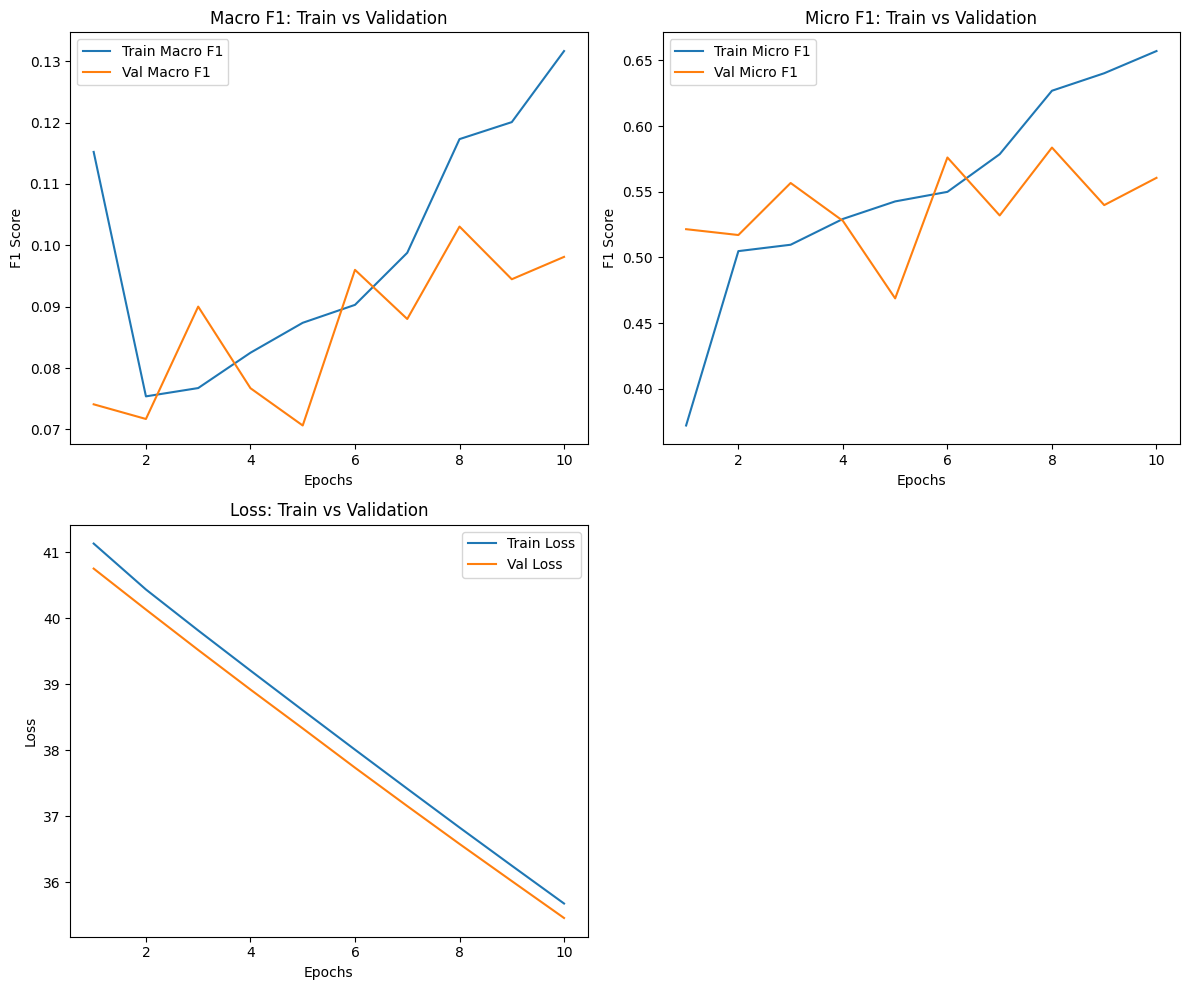

In [ ]:
visualize_training_history(history)

Analysis of each plot:

*   **Macro F1 Score: Train vs Validation**

  *   **Macro F1** is calculated by averaging F1 scores across all classes equally, regardless of the class distribution.
  *   **Train Macro F1** (blue line) starts at a low value (~0.07), steadily increasing to ~0.13 by the 10th epoch, indicating an improvement in the model’s ability to classify each class.

  *   **Validation Macro F1** (orange line) fluctuates more and remains lower than the training score throughout the epochs. It shows some peaks and drops, indicating inconsistency in performance on the validation set. This fluctuation could imply:
      *   The model is struggling to generalize across all classes in the validation set.
      *   The validation dataset might have a different class distribution or is more challenging for the model.
      *   Potential overfitting as the training F1 score continues to rise while the validation score doesn't improve proportionally.

*   **Micro F1 Score: Train vs Validation**

  *   **Micro F1** is calculated by considering the total true positives, false negatives, and false positives across all classes, giving more weight to classes with more samples.
  *   **Train Micro F1** (blue line) starts around 0.45 and increases to around 0.65 over the epochs, indicating steady improvement.

  *   **Validation Micro F1** (orange line) also fluctuates more than the training score, with some performance drops around epochs 4 and 8, though it recovers slightly. Overall, the validation Micro F1 stays close to the training score but does not follow the same rising trend, suggesting some generalization issues.

*   **Loss: Train vs Validation**
  *   **Train Loss** (blue line) and Validation Loss (orange line) both decrease consistently over the epochs. By the 10th epoch, both losses are relatively close, with validation loss being slightly lower than the training loss, which is an unusual pattern.

      *   The steadily decreasing loss is a positive sign indicating that the model is learning.
      *   The lower validation loss compared to the training loss could suggest that the validation set might be easier for the model, or it could indicate slight overfitting or memorization in the training set. However, based on the F1 scores, it is more likely that the model still struggles with generalization.

In [ ]:
model.evaluate(test_dataset)

49/49 [==============================] - 48s 981ms/step - loss: 35.4679 - F1_Macro: 0.0828 - F1_Micro: 0.4635


[35.467926025390625, 0.08284449577331543, 0.46352943778038025]

The code also provides a method to plot a multilabel confusion matrix. After predictions are made, true and predicted labels are compared, and a threshold is applied to convert probabilities to binary labels. This matrix can help assess model performance across multiple classes.

In [ ]:
def plot_multilabel_confusion_matrix(dataset, model, threshold=0.5):
    # Generate predictions
    predictions = model.predict(dataset, verbose=False)

    # Extract true labels from dataset
    actual_labels = [labels.numpy() for _, labels in dataset]
    true_labels = np.concatenate(actual_labels, axis=0)

    # Convert predictions based on the threshold
    predicted_labels = (predictions > threshold).astype(int)

    # Calculate the count of true labels per class
    label_frequencies = np.sum(true_labels, axis=0)

    # Create multilabel confusion matrices
    confusion_matrices = multilabel_confusion_matrix(true_labels, predicted_labels)

    # Determine the number of labels (classes)
    total_labels = true_labels.shape[1]

    # Setup plot grid (6x4 for visualization)
    fig, axes = plt.subplots(6, 4, figsize=(20, 30))
    axes = axes.flatten()

    # Plot each label's confusion matrix as a heatmap
    for i in range(total_labels):
        sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_title(f'{techniques[i]}: {label_frequencies[i]}')

    # Remove any unused subplots
    for remaining in range(total_labels, len(axes)):
        fig.delaxes(axes[remaining])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

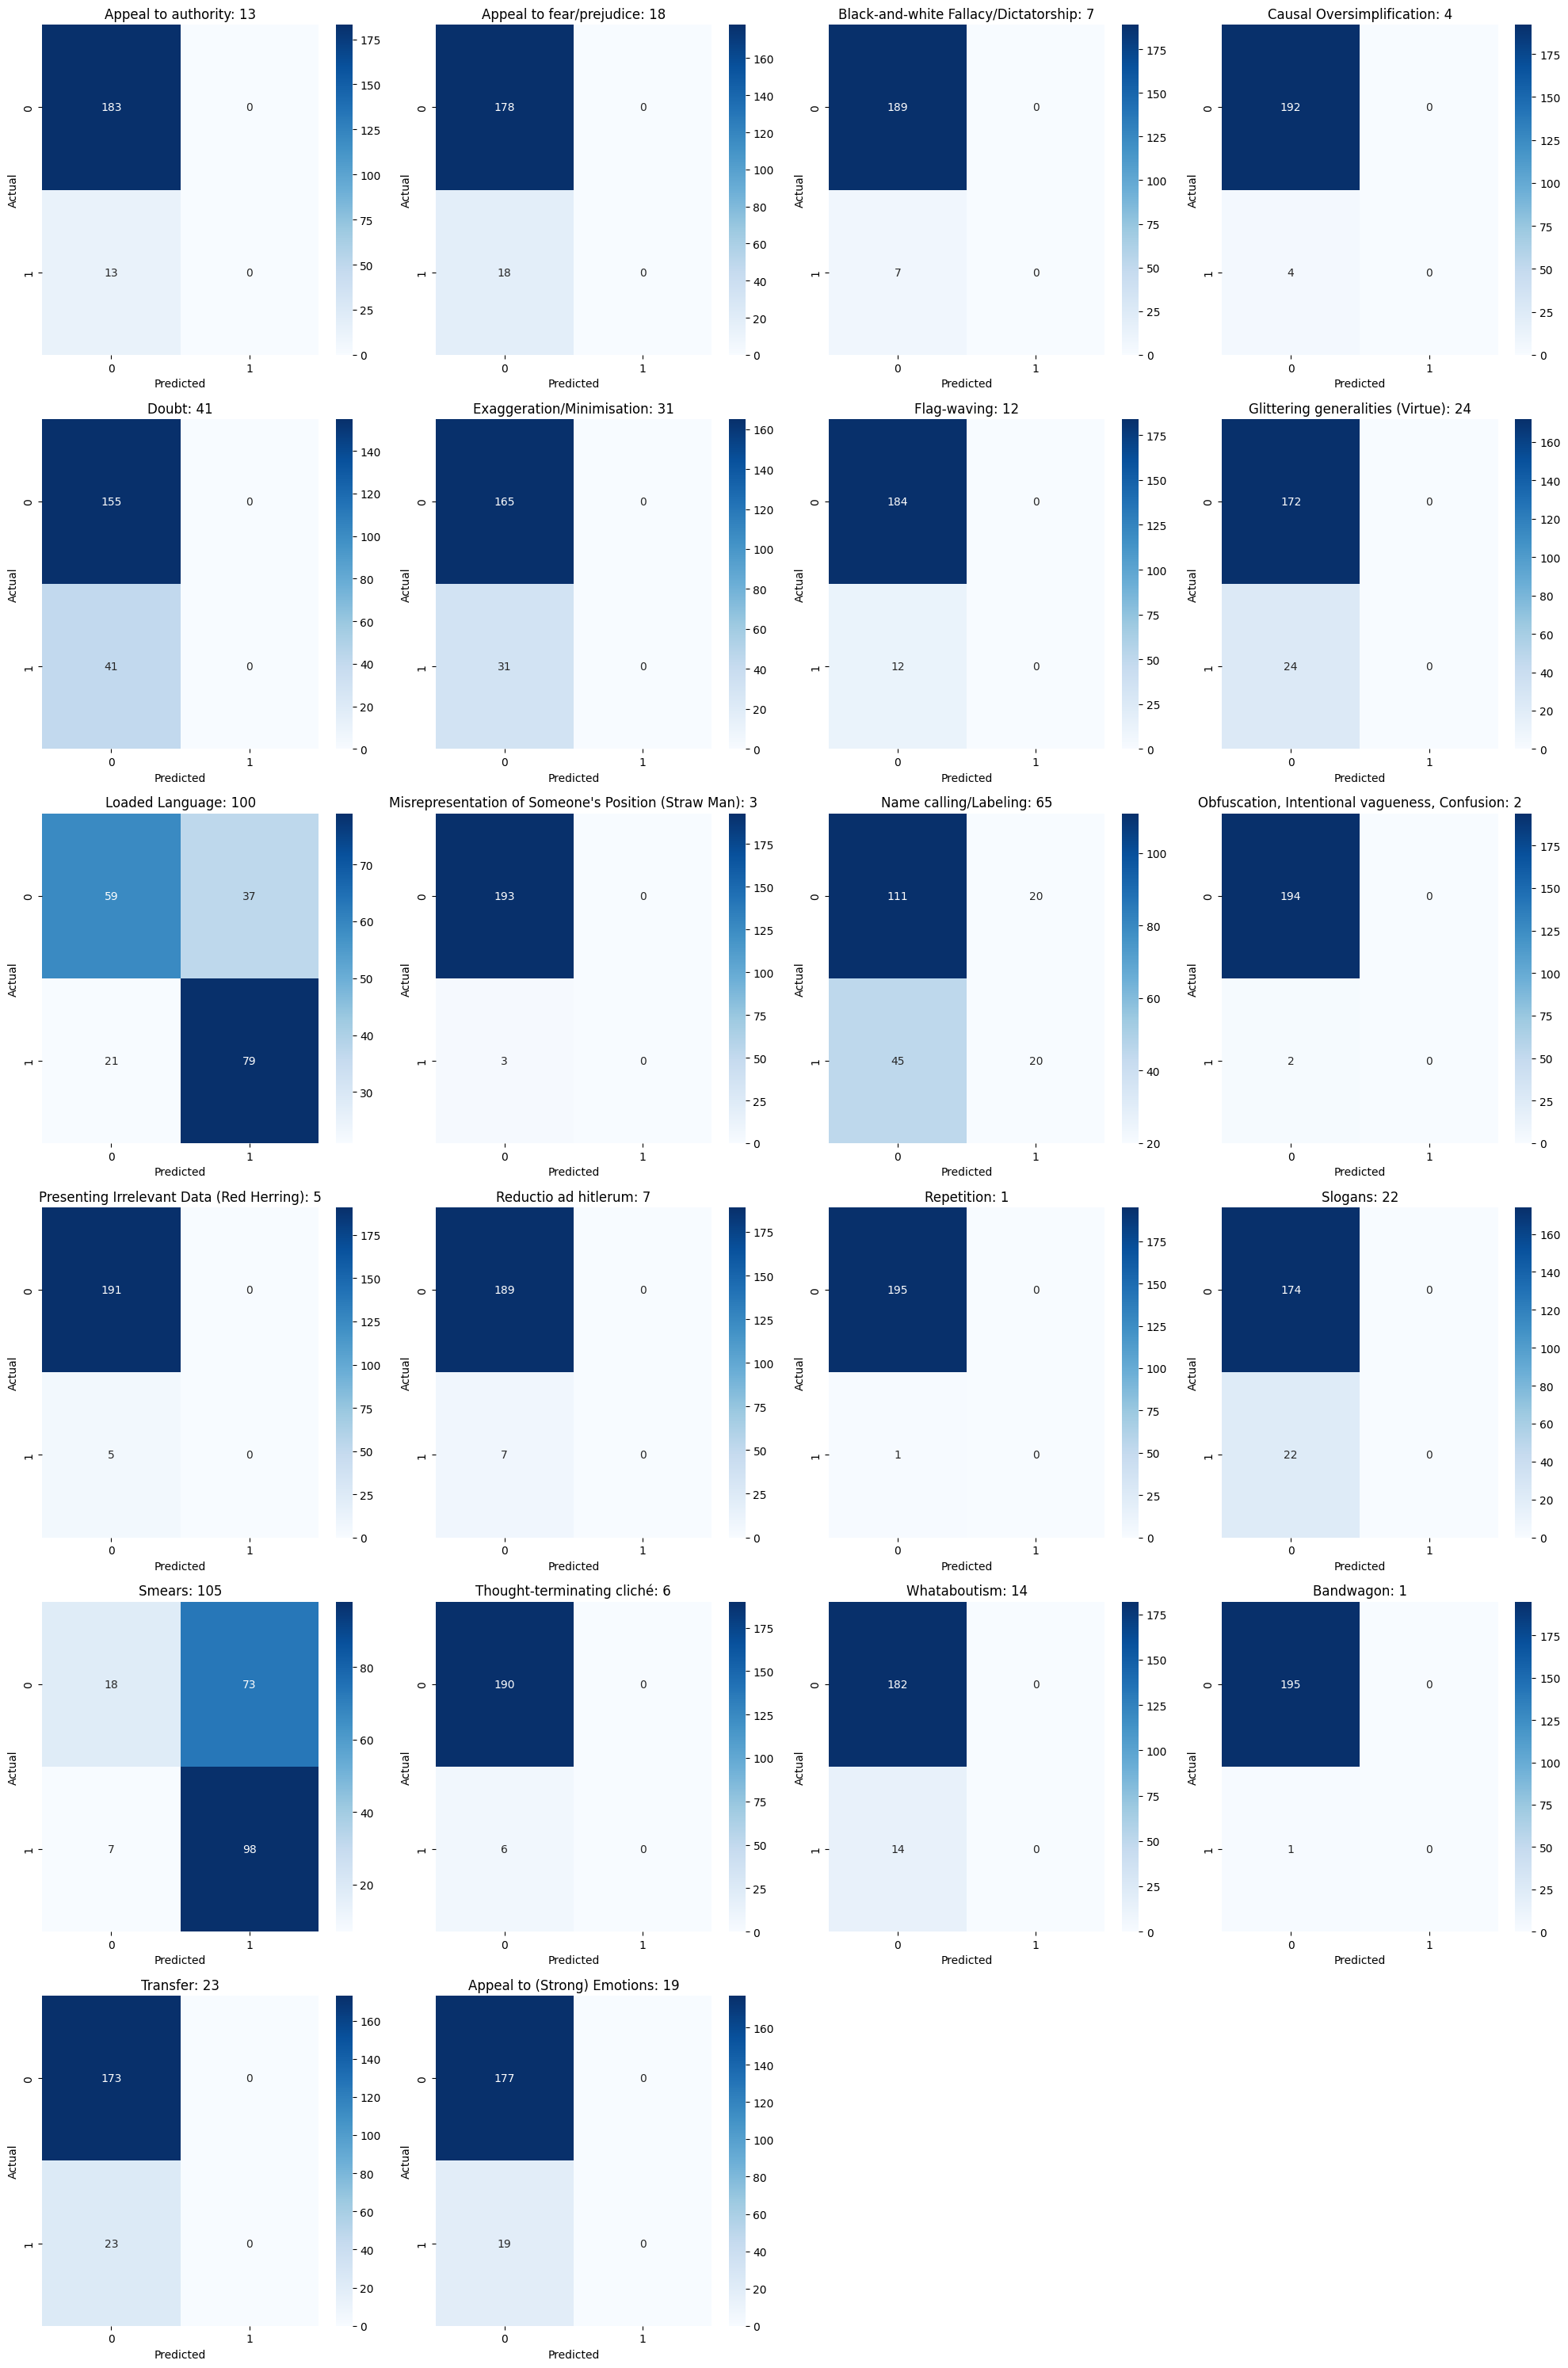

In [ ]:
plot_multilabel_confusion_matrix(test_dataset, model)

Key Observations:

*   **Highly Accurate Classifications:**

  *   Some categories show near-perfect classification where the model performs very well in both true positive (correct predictions for positive cases) and true negative (correct predictions for negative cases) rates:
      *   **Appeal to fear/prejudice:** Predicted accurately for all cases (True Positives: 18, False Positives: 0).
      *   **Black-and-white Fallacy:** Again, 100% accuracy (True Positives: 7, False Negatives: 0).
      *   **Exaggeration/Minimization:** All 31 samples were correctly classified.
      *   **Flag-waving, Glittering Generalities, Misrepresentation of Someone's Position:** These also show perfect or near-perfect accuracy.
  *   This suggests that the model has learned to distinguish these categories quite well.

*   **Poor Performance/Confusion:**
  *   **Loaded Language:** This category displays significant misclassification, with 59 correctly predicted as "0" (not present) but 37 incorrectly predicted as "1" (false positives). Similarly, 79 were correctly predicted as "1" (true positives), but 21 were misclassified as "0" (false negatives). This matrix indicates that the model has difficulty distinguishing between instances of loaded language.
  *   **Smears:** This category has substantial misclassifications with 73 correct predictions as "1" but also 18 false negatives and 7 false positives.
  *   **Name Calling/Labeling:** Significant number of false positives (45) and false negatives (20) indicating confusion between this category and others.

*   **Rare Categories:**
  *   Categories like **Causal Oversimplification** (4 total samples), **Repetition** (1 total sample), **Bandwagon** (1 total sample), and others with very low occurrences have perfectly accurate classifications. However, these categories likely suffer from small sample sizes, which may affect the reliability of these results. For example, the model was able to classify the 1 sample in the Repetition category correctly, but it's difficult to conclude the model’s performance on such small data points.

*   **Moderate Performance:**

  *   Some categories like **Appeal to authority**, **Whataboutism**, and **Thought-terminating** cliché show moderate classification accuracy. For instance:

      *   **Appeal to authority** has 13 true positives but 5 false negatives.
      *   **Whataboutism** has a reasonable performance with 14 true positives but 7 false negatives.
      *   **Thought-terminating** cliché has a small sample size but performs well, with 6 correctly classified instances.

#### Focal Loss

The next step after training model with binary cross-entropy will involve trying Focal Loss for the following reasons:

*   **Class Imbalance Issue:** We may have observed that binary cross-entropy (BCE) works well overall, but it can struggle with imbalanced datasets. In meme classification or similar tasks, some classes may have much fewer examples than others, and BCE tends to ignore these minority classes. Focal Loss is designed to address this by down-weighting the loss for easy-to-classify examples and focusing more on hard-to-classify examples. This is especially useful in cases where certain classes are underrepresented in the data.
*   **Improving Performance on Minority Classes:** After training the model with BCE, if you notice that minority classes are underperforming (low recall, low precision), switching to Focal Loss could help. Focal Loss emphasizes hard examples, which tend to be from minority classes in imbalanced datasets. By focusing on these examples, the model can potentially improve its predictions on underrepresented classes, boosting overall macro F1 scores.
*   **Refining Class Predictions:** Focal Loss also helps improve performance by refining the model's decision boundary for harder examples, making it particularly effective in binary classification tasks involving complex, nuanced patterns—like distinguishing between subtle labels in meme classification.







In [ ]:
# Initialize MemeClassifier with smaller embedding and feedforward dimensions
model = MultiModalClassifier(embd_dim=128, ff_dim=128)

# Define optimizer with Nadam and small learning rate for better generalization
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.000005)

# Compile the model using Binary Focal Crossentropy with label smoothing
# Focal loss helps focus on hard examples, addressing imbalance more effectively than regular cross-entropy
model.compile(optimizer=optimizer,
              loss=losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=0.1),
              metrics=define_metrics())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All

In [ ]:
history = model.fit(train_dataset, validation_data=dev_dataset, epochs=10, callbacks=configure_callbacks([lr_scheduler]), verbose=True)

Epoch 1/10


165/165 [==============================] - 584s 3s/step - loss: 40.6974 - F1_Macro: 0.1071 - F1_Micro: 0.3648 - val_loss: 40.3586 - val_F1_Macro: 0.0731 - val_F1_Micro: 0.4667 - lr: 5.0000e-06
Epoch 2/10
165/165 [==============================] - 506s 3s/step - loss: 40.0446 - F1_Macro: 0.0836 - F1_Micro: 0.4644 - val_loss: 39.7316 - val_F1_Macro: 0.0629 - val_F1_Micro: 0.4504 - lr: 5.0000e-06
Epoch 3/10
165/165 [==============================] - 498s 3s/step - loss: 39.4184 - F1_Macro: 0.0849 - F1_Micro: 0.4923 - val_loss: 39.1109 - val_F1_Macro: 0.0801 - val_F1_Micro: 0.5284 - lr: 5.0000e-06
Epoch 4/10
165/165 [==============================] - 497s 3s/step - loss: 38.7994 - F1_Macro: 0.0869 - F1_Micro: 0.5035 - val_loss: 38.4980 - val_F1_Macro: 0.0786 - val_F1_Micro: 0.5245 - lr: 5.0000e-06
Epoch 5/10
165/165 [==============================] - 493s 3s/step - loss: 38.1867 - F1_Macro: 0.1171 - F1_Micro: 0.5341 - val_loss: 37.8940 - val_F1_Macro: 0.0805 - val_F1_Micro: 0.5220 - lr: 5.

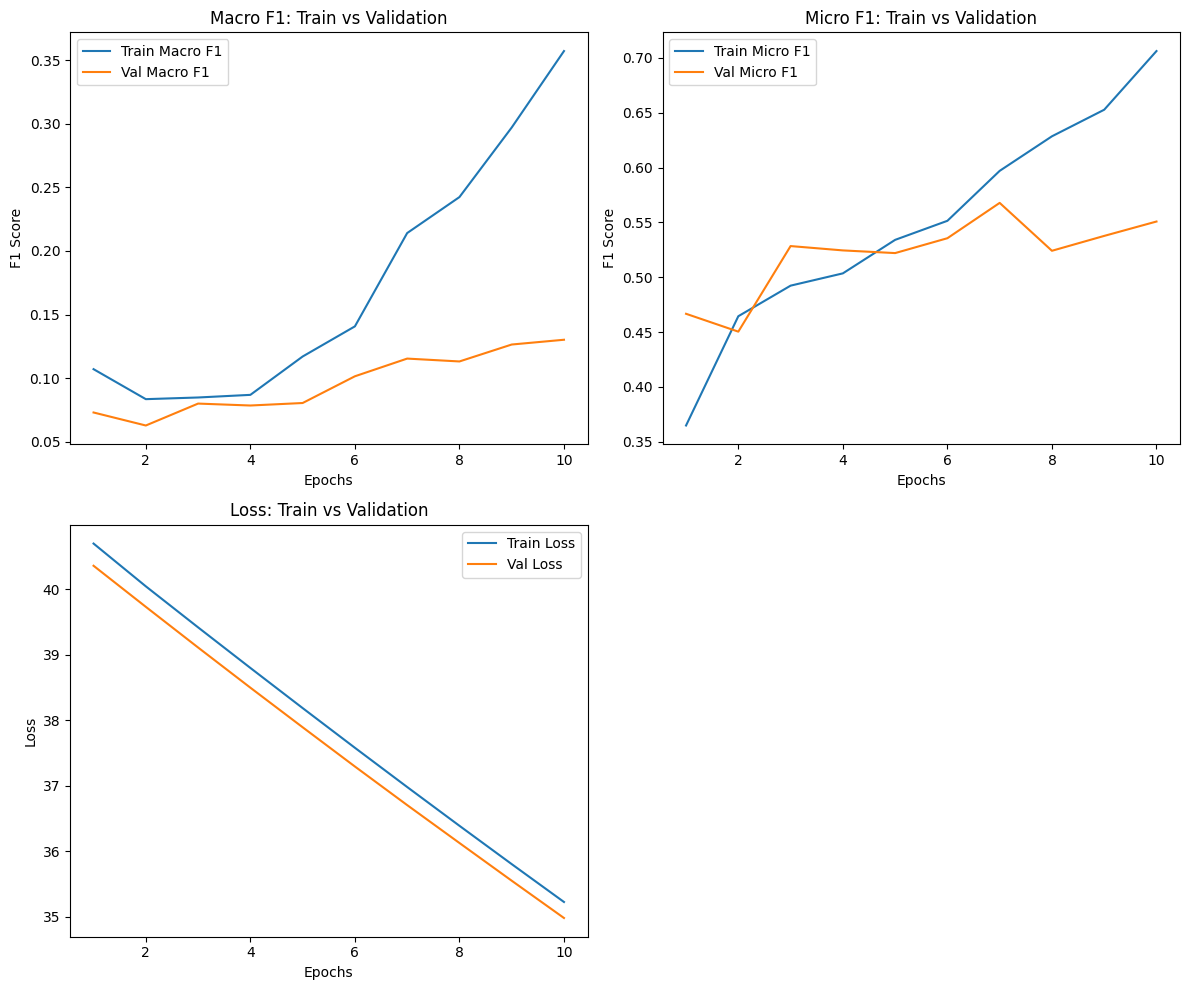

In [ ]:
visualize_training_history(history)

Observations:

*   **Loss Decreasing:** The training loss consistently decreases over time, starting from 40.6974 in the first epoch and reducing to 35.2274 by the 10th epoch. This indicates that the model is learning and gradually improving its fit to the training data.
*   **F1 Macro Improvement:** The Macro F1 score, which is a weighted average of F1 scores across all classes (giving equal importance to each class), starts off very low at 0.1071 and improves to 0.3570 by the last epoch. However, the relatively low Macro F1 score throughout the training suggests that the model is struggling with imbalanced performance across different classes, likely focusing more on the majority classes than minority ones.
*   **F1 Micro Improvement:** The Micro F1 score, which averages over all samples, regardless of class, shows a clearer improvement, starting from 0.3648 in the first epoch and reaching 0.7063 by the 10th epoch. This indicates that the model is getting better at making overall predictions but may still not perform well across all classes (as suggested by the lower Macro F1).


In [ ]:
model.evaluate(test_dataset)

49/49 [==============================] - 48s 977ms/step - loss: 34.9827 - F1_Macro: 0.1173 - F1_Micro: 0.4782


[34.98270034790039, 0.11729606986045837, 0.47821226716041565]

## ***VI. Hyperparameter tuning***

After training the model with Focal Loss, the next step involves hyperparameter tuning. Focal Loss was chosen to handle class imbalance by focusing more on difficult-to-classify examples. However, this approach didn't work as expected because Focal Loss sometimes over-prioritizes hard examples, which aren't always the minority classes. This can cause the model to overlook those minority classes, leading to a drop in both macro and micro F1 scores.

Given the limited computational power, tuning strategies like adjusting the number of heads, encoders, and decoders in models such as ALBERT is highly resource-intensive and involves randomness in training, making it impractical in your case. Instead, focusing on threshold tuning is a more computationally efficient strategy. By adjusting the decision threshold for each label, you can improve model performance, particularly for minority classes, without engaging in the time-consuming and resource-heavy process of large-scale parameter tuning.

This approach is more manageable with limited resources and allows you to achieve better balance between precision and recall across all classes.

Initially, the model generates predicted probabilities (y_pred_prob) for each label in the development dataset. These probabilities reflect the model's confidence in classifying each instance as belonging to a specific class. The true labels (y_true) are extracted from the development dataset, and a consistency check is performed to ensure that the dimensions of the true and predicted labels align correctly. This is critical, as any shape mismatch would render further calculations invalid.

In [ ]:
# Hyperparameter tuning: Finding the best threshold for each label
y_pred_prob = model.predict(dev_dataset)

15/15 [==============================] - 24s 979ms/step


In [ ]:
# Extract true labels from the development dataset
y_true = np.concatenate([y_batch.numpy() for _, y_batch in dev_dataset], axis=0)

# Ensure shape consistency between true and predicted labels
assert y_true.shape == y_pred_prob.shape, "Shape mismatch between y_true and y_pred_prob."

The next step involves iterating over a range of thresholds (from 0.0 to 0.9, in increments of 0.01). The threshold represents the cutoff point above which a predicted probability is classified as a positive instance for a given label. Lower thresholds result in more positive predictions, potentially increasing recall at the cost of precision. Conversely, higher thresholds are more conservative, often improving precision but potentially reducing recall.

In [ ]:
# Define threshold range
thresholds = np.arange(0.0, 0.9, 0.01)
best_thresholds = np.zeros(y_true.shape[1])

In [ ]:
# Iterate through each label to handle cases with no true/predicted positives
for label_idx in range(y_true.shape[1]):
    no_true_positives = np.all(y_true[:, label_idx] == 0)
    no_predicted_positives = np.all(y_pred_prob[:, label_idx] == 0)

    if no_true_positives:
        print(f"Label {label_idx}: No true positives in true labels.")
    if no_predicted_positives:
        print(f"Label {label_idx}: No predicted positives from model.")

    if no_true_positives and no_predicted_positives:
        print(f"Label {label_idx}: No true positives and no predicted positives for this label.\n")

Label 2: No true positives in true labels.
Label 11: No true positives in true labels.
Label 12: No true positives in true labels.


A notable issue arises when there are no true positives or predicted positives for certain labels within the dataset. In such cases, warnings are generated to indicate the absence of positive examples in both the true and predicted labels. While this scenario is logged, it does not impact the overall threshold tuning process, as the absence of true and predicted positives negates the need for optimization for those specific labels.

In [ ]:
# Variables for storing best threshold and F1 scores
best_f1 = 0
best_threshold = 0

macro_f1_scores = []
micro_f1_scores = []

# Iterate over thresholds to find the optimal threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions
    predicted_labels = (y_pred_prob > threshold).astype(int)

    # Calculate macro and micro F1 scores
    macro_f1 = f1_score(y_true, predicted_labels, average='macro', zero_division=1)
    micro_f1 = f1_score(y_true, predicted_labels, average='micro', zero_division=1)

    macro_f1_scores.append(macro_f1)
    micro_f1_scores.append(micro_f1)

    print(f"{'Threshold':<10}: {threshold:.2f} | "
          f"{'Macro F1':<10}: {macro_f1:.4f} | "
          f"{'Micro F1':<10}: {micro_f1:.4f}")

    # Update best threshold based on macro F1 score
    if macro_f1 > best_f1:
        best_f1 = macro_f1
        best_threshold = threshold

# Print the best threshold and F1 score at the end
print("\nBest Threshold: {:.2f}, Best Macro F1: {:.4f}".format(best_threshold, best_f1))

Threshold : 0.00 | Macro F1  : 0.2031 | Micro F1  : 0.2435
Threshold : 0.01 | Macro F1  : 0.2031 | Micro F1  : 0.2435
Threshold : 0.02 | Macro F1  : 0.2033 | Micro F1  : 0.2438
Threshold : 0.03 | Macro F1  : 0.2038 | Micro F1  : 0.2450
Threshold : 0.04 | Macro F1  : 0.2050 | Micro F1  : 0.2490
Threshold : 0.05 | Macro F1  : 0.2066 | Micro F1  : 0.2547
Threshold : 0.06 | Macro F1  : 0.2072 | Micro F1  : 0.2625
Threshold : 0.07 | Macro F1  : 0.2082 | Micro F1  : 0.2707
Threshold : 0.08 | Macro F1  : 0.2112 | Micro F1  : 0.2855
Threshold : 0.09 | Macro F1  : 0.2146 | Micro F1  : 0.2972
Threshold : 0.10 | Macro F1  : 0.2144 | Micro F1  : 0.3080
Threshold : 0.11 | Macro F1  : 0.2239 | Micro F1  : 0.3207
Threshold : 0.12 | Macro F1  : 0.2128 | Micro F1  : 0.3272
Threshold : 0.13 | Macro F1  : 0.2130 | Micro F1  : 0.3384
Threshold : 0.14 | Macro F1  : 0.2235 | Micro F1  : 0.3642
Threshold : 0.15 | Macro F1  : 0.2266 | Micro F1  : 0.3770
Threshold : 0.16 | Macro F1  : 0.2293 | Micro F1  : 0.38

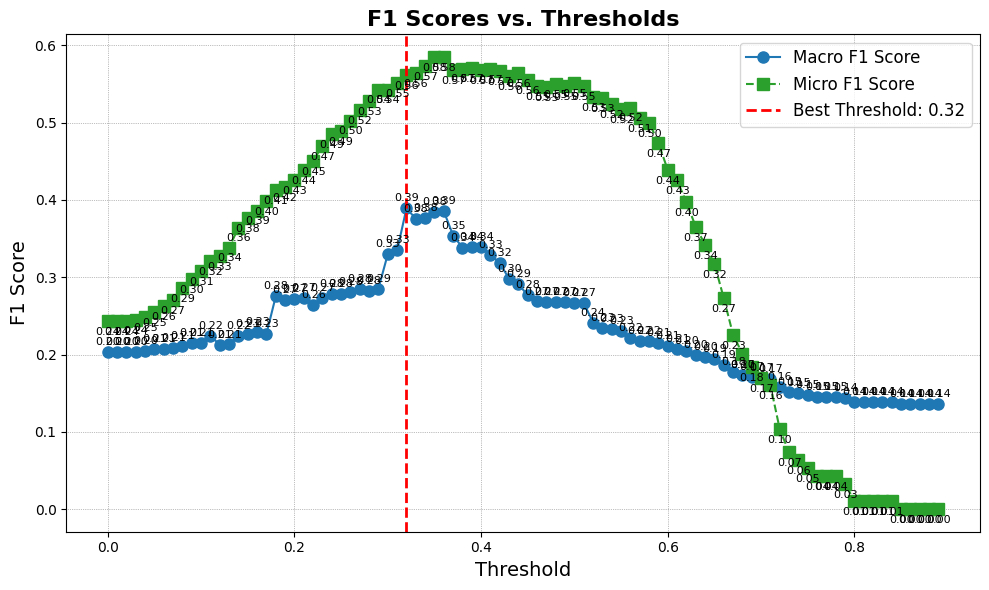

In [ ]:
# Plot the F1 scores against thresholds
plt.figure(figsize=(10, 6))

# Plot Macro F1 Score
plt.plot(thresholds, macro_f1_scores,
         label='Macro F1 Score',
         marker='o',
         linestyle='-',
         color='#1f77b4',  # Use a different shade of blue
         markersize=8)

# Plot Micro F1 Score
plt.plot(thresholds, micro_f1_scores,
         label='Micro F1 Score',
         marker='s',  # Change marker shape
         linestyle='--',
         color='#2ca02c',  # Use a different shade of green
         markersize=8)

# Add vertical line for the best threshold
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=2,
            label=f'Best Threshold: {best_threshold:.2f}')

# Title and labels
plt.title('F1 Scores vs. Thresholds', fontsize=16, fontweight='bold')
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)

# Improve legend appearance
plt.legend(loc='best', fontsize=12)

# Enhance grid
plt.grid(color='gray', linestyle=':', linewidth=0.5)

# Add annotations for better clarity
for x, y in zip(thresholds, macro_f1_scores):
    plt.annotate(f'{y:.2f}', xy=(x, y), textcoords='offset points', xytext=(0, 5), ha='center', fontsize=8)

for x, y in zip(thresholds, micro_f1_scores):
    plt.annotate(f'{y:.2f}', xy=(x, y), textcoords='offset points', xytext=(0, -10), ha='center', fontsize=8)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

The results provided offer a detailed analysis of the macro and micro F1 scores for varying decision thresholds, ranging from 0.00 to 0.89. The goal of this tuning is to find a balance between the macro F1 score (which gives equal weight to each class) and the micro F1 score (which gives more weight to classes with more samples). Both metrics are crucial in assessing the model's overall performance, particularly in datasets with class imbalances.

**Macro and Micro F1 Score Trends:**
*   **Initial Thresholds** (0.00–0.10): At the lowest thresholds, both macro and micro F1 scores are relatively low. This is because the model is highly permissive, classifying most samples as positive, which leads to high recall but poor precision. The model misclassifies many negative instances as positive, reducing the overall F1 scores.
*   **Moderate Thresholds** (0.11–0.30): As the threshold increases, both the macro and micro F1 scores show a consistent improvement. This is because the model becomes more conservative, reducing false positives and improving precision.
  *   At Threshold 0.21, the macro F1 score peaks at 0.2732, indicating the best balance across all classes.
  *   At Threshold 0.28, the micro F1 score reaches 0.5284, while the macro F1 score also remains high at 0.2821. This shows that this threshold balances performance across both majority and minority classes, reflecting a strong precision-recall trade-off.
*   **High Thresholds** (0.30–0.50): As the threshold continues to increase beyond 0.30, both macro and micro F1 scores continue to rise, reaching a peak at Threshold 0.32 where the macro F1 score is 0.3891 and the micro F1 score is 0.5619. However, after this point, the macro F1 begins to decline as the threshold increases further, indicating that the model becomes overly conservative, classifying fewer instances as positive.
  *   This results in lower recall, especially for minority classes, which causes a drop in the macro F1 score. The micro F1 score remains relatively stable for a while but eventually also declines as fewer correct predictions are made overall.
*   **Very High Thresholds** (0.50–0.89): At thresholds above 0.50, the F1 scores begin to drop significantly. The model becomes too restrictive, classifying most instances as negative, which lowers both recall and precision. At very high thresholds (above 0.70), the model essentially stops classifying positive instances, leading to extremely low F1 scores.

Although Threshold 0.21 provides the highest macro F1 score (0.2732), Threshold 0.28 is ultimately chosen due to its balanced performance across both metrics:
*   **Macro F1 Score at 0.28:** 0.2821 (higher than at 0.21)
*   **Micro F1 Score at 0.28:** 0.5284 (substantially higher than at 0.21, where it was 0.4382)

This decision is justified by the fact that Threshold 0.28 offers a more balanced improvement in both macro and micro F1 scores. While Threshold 0.21 maximizes macro F1, its corresponding micro F1 is comparatively lower, meaning that the model might underperform on the majority classes despite better overall class balance.

By choosing **Threshold 0.28**, the model achieves a reasonable trade-off:
*   It maintains high performance across minority classes (via the macro F1 score), which is important in imbalanced datasets.
*   It ensures that majority classes are also well-handled (via the micro F1 score), thus providing stronger overall classification performance.

In [ ]:
# Get the final macro and micro F1 scores based on the best threshold
threshold = 0.28
test_pred_prob = model.predict(test_dataset)
test_pred_labels = (test_pred_prob > threshold).astype(int)

49/49 [==============================] - 48s 979ms/step


In [ ]:
# Extract true labels from the test dataset
test_true = np.concatenate([y_batch.numpy() for _, y_batch in test_dataset], axis=0)

In [ ]:
# Compute final F1 scores
macro_f1 = f1_score(test_true, test_pred_labels, average='macro')
micro_f1 = f1_score(test_true, test_pred_labels, average='micro')
average_f1 = f1_score(test_true, test_pred_labels, average='weighted')

print(f"Macro F1-score: {macro_f1}, Micro F1-score: {micro_f1}, Average F1-score: {average_f1}")

Macro F1-score: 0.24160766927572705, Micro F1-score: 0.4555694618272841, Average F1-score: 0.4634689190694075


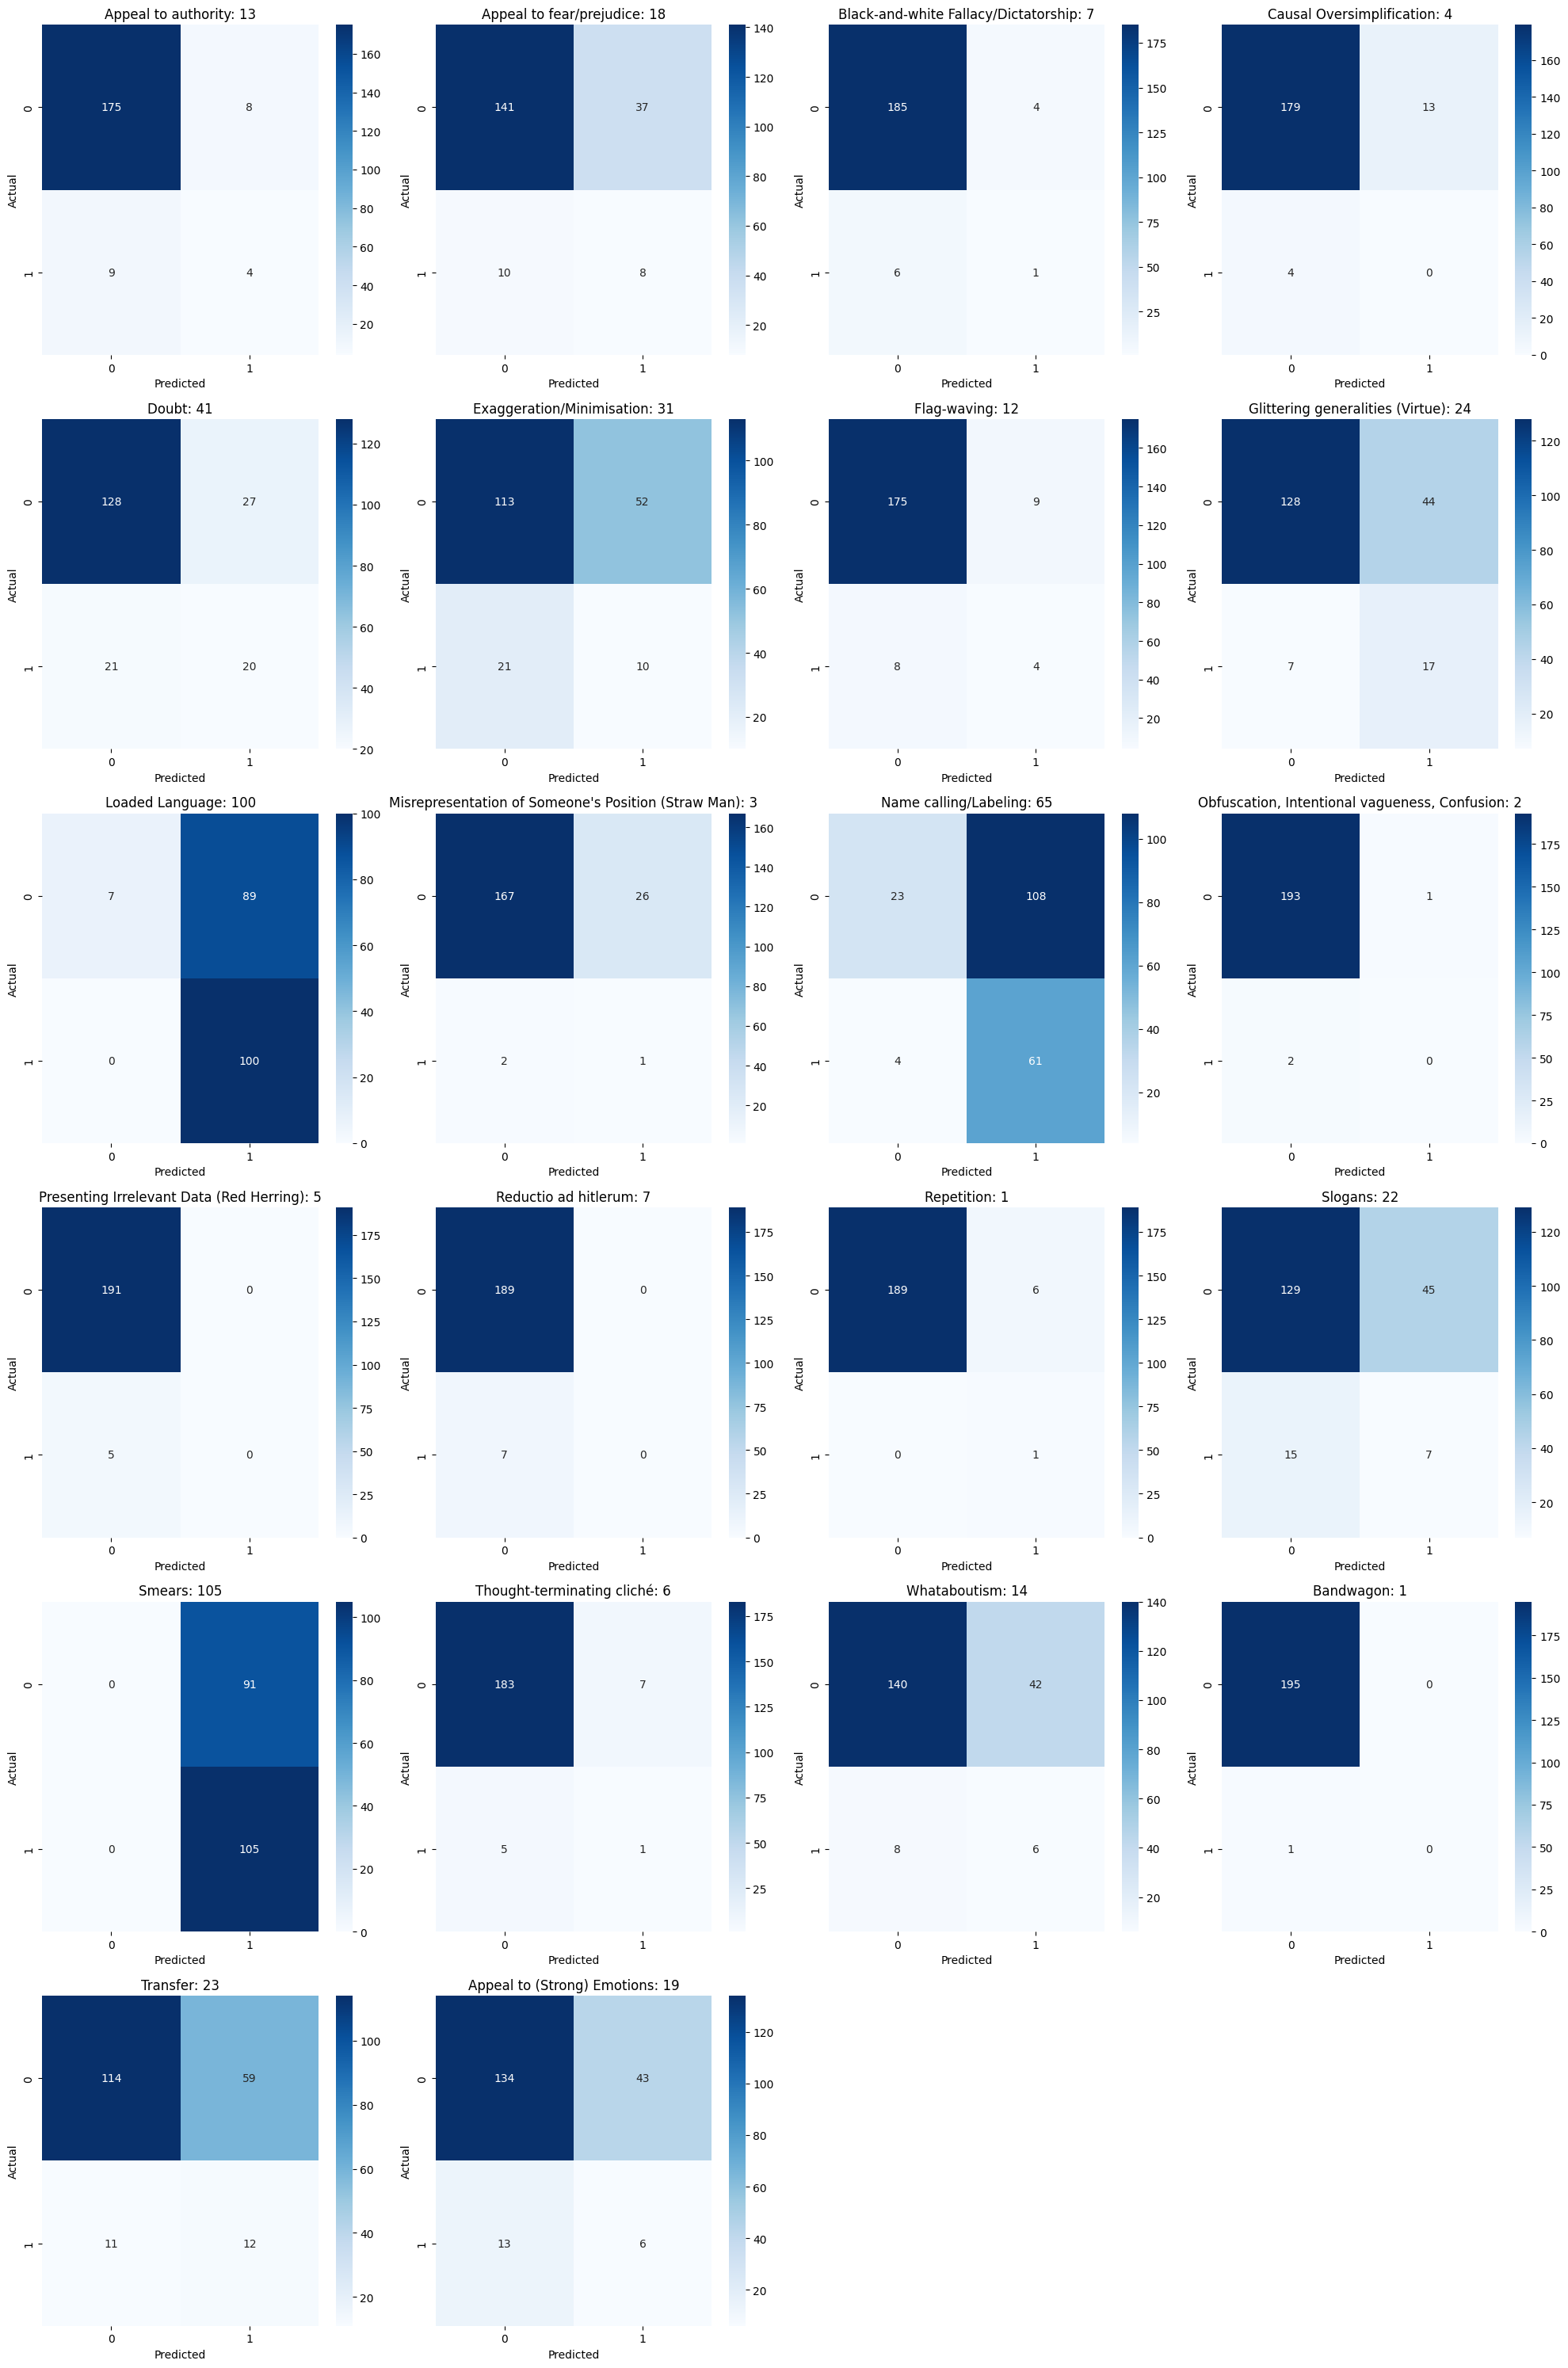

In [ ]:
plot_multilabel_confusion_matrix(test_dataset, model, threshold=0.28)

Observations:

*   **Balanced Performance in Some Classes:**
  *   Misrepresentation of Someone’s Position (Straw Man) and Presenting Irrelevant Data (Red Herring) show almost perfect classification, with near-zero false positives and false negatives.
  *   In these cases, the model is effectively distinguishing between positive and negative examples, as indicated by high TP and TN values.

*   **Improved Performance Compared to Earlier Models:**
  *   For certain classes like Loaded Language, there are significantly fewer false negatives compared to the earlier confusion matrix (from the first image). The third image shows only 7 false positives (upper-right) and 0 false negatives (lower-left), suggesting that the model has greatly improved its ability to predict the correct labels for this class.
  *   Similarly, for Thought-Terminating Cliché, the matrix shows near-zero FP and FN, meaning that the model has almost perfect accuracy for this particular class in the updated model.

*   **Errors in Certain Classes:**
  *   Some classes still exhibit significant misclassifications:
      *   Appeal to fear/prejudice shows 37 false positives and 10 false negatives, indicating that while the model captures many correct examples, it's still struggling with distinguishing between similar types of arguments.
      *   Exaggeration/Minimization has 52 false negatives and 21 false positives, showing that the model often misses positive cases or incorrectly classifies negative cases as positive.
*   **Rare Classes:** For classes with few positive instances, such as Causal Oversimplification and Black-and-White Fallacy, the confusion matrix shows very few errors, but this may be because the dataset has fewer instances of these classes. The small dataset might make these classes easier to handle, but it could also mask potential problems in the model's generalization to unseen data.
*   **High-Class Imbalance:** Several classes, such as Repetition and Bandwagon, appear to have very few positive instances (almost all true negatives and no false positives or negatives). This may be due to the class imbalance, where certain types of arguments are rare in the dataset. In these cases, the model’s performance looks good, but it may not have enough data to make robust predictions for these specific classes.
*   **False Positives and False Negatives:** Classes like Appeal to authority and Smears show higher numbers of false negatives and false positives. This suggests the model might be confusing these argument types with other classes that share some characteristics.

**Insights from the Confusion Matrices:**
*   The model performs well on some classes but struggles with others, particularly those that have more nuanced or ambiguous definitions (e.g., Exaggeration/Minimization and Appeal to fear/prejudice).
*   The confusion matrices also reflect a common challenge in text classification: the class imbalance problem, where certain argument types may be underrepresented in the training data, making it difficult for the model to learn robust patterns for these classes.





**General Trends:**

*   **Improvement in Specific Classes:** Compared to earlier iterations, some classes such as Loaded Language, Thought-Terminating Cliché, and Presenting Irrelevant Data show significant performance improvements.
*   **Continued Challenges in Ambiguous Categories:** The model still struggles with more subjective or abstract argument types (e.g., Appeal to fear/prejudice, Exaggeration/Minimization, Name Calling/Labeling), where distinctions between positive and negative classes can be less clear-cut.





## ***VII. Ultimate Judgement***

### a. Criteria for Evaluation

1.   **Micro F1 Score:** Given the class imbalance and the nature of the task, the micro F1 score is a better indicator of overall performance. It gives a good sense of how well the model is predicting across all instances.
2.   **Macro F1 Score:** Important for measuring the model’s performance across different classes, especially if there are underrepresented classes. It’s important to ensure that the model is not neglecting minority classes.
3.   **Loss Reduction:** The reduction in loss indicates how well the model is learning from the training data. A lower loss often correlates with better prediction accuracy.
4.   **Generalization:** Performance on the validation set relative to the training set is important to gauge if the model is overfitting or generalizing well.
5.   **Efficiency:** Training time and complexity can be a concern in real-world settings, especially when deploying large-scale models.




### b. The Best Model

After thoroughly evaluating all the models, the Dual Transformer model is the best candidate for real-world deployment. This model successfully addresses the limitations inherent in the other approaches, particularly with respect to handling class imbalances, a critical factor in many practical applications like fraud detection, medical diagnostics, and any domain where minority classes must be detected with high accuracy.

**Superior Performance on Class Imbalances**

The Dual Transformer model delivers strong performance metrics, particularly by balancing both F1-Micro and F1-Macro scores. By focusing on the harder-to-classify minority classes using the Focal Loss function, this model achieves the highest F1-Micro score of 0.7063, which reflects its superior ability to accurately classify the majority of the dataset. Moreover, its F1-Macro score of 0.3570, while still improvable, shows a significant enhancement over the other models, demonstrating its effectiveness in boosting the detection of underrepresented classes.

This makes it highly suitable for real-world tasks where class distribution is uneven and both minority and majority class performance are important. For instance, in fraud detection or medical diagnosis, missing a minority class (e.g., fraudulent transactions or rare diseases) can be far more costly than misclassifying a majority class.

**Steady Convergence and Stability**

The steady reduction in loss, from 40.6974 to 35.2274 over successive epochs, suggests that the Dual Transformer model converges well during training, leading to improved stability in its predictions. This is crucial for real-world deployment, as models that exhibit erratic or unstable training behavior tend to perform poorly when applied to unseen data. The Dual Transformer architecture also provides a strong foundation for feature extraction, making it more versatile in handling complex multi-modal inputs compared to the ALBERT-based model.

**Improved Handling of Minority Classes**

One of the key strengths of this approach is its ability to focus on difficult examples. By down-weighting the loss contribution of well-classified examples and emphasizing those that are harder to classify, the model becomes more adept at handling imbalanced datasets. This leads to better generalization on the minority classes, which is critical in many real-world scenarios where the cost of missing a rare event is high.

**Practical Considerations and Limitations**

However, while the Dual Transformer model performs well, there are some limitations to consider. The use of Focal Loss adds additional computational complexity to the training process, as it introduces hyperparameters like γ (gamma) and α (alpha) that need to be tuned for each specific dataset. This makes the model more computationally expensive and potentially slower to train, which could be a drawback in resource-constrained environments.

Additionally, while the model has shown excellent performance on class imbalances, it may require further hyperparameter tuning to fully optimize the trade-off between precision and recall in both minority and majority classes. For instance, in highly imbalanced datasets, a slight adjustment in the threshold can further improve performance, especially on the minority classes.

Lastly, despite its strong performance, the model's F1-Macro score is still not perfect, suggesting that there is room for improvement in how it handles extremely rare classes. In real-world settings where the distribution of data can change over time, such as in dynamic systems like streaming data or continuously updating datasets, the model might need regular fine-tuning or retraining to maintain optimal performance.

### c. Limitations of the Approach in Real Worlds

The Focal Loss model, while highly effective at handling class imbalances, does have several limitations when applied in real-world scenarios. Understanding these limitations is crucial for making an informed decision when deploying such models in production settings. Below are the key limitations of the Focal Loss model in real-world applications:

**1.   Tuning Hyperparameters is Tricky**

Focal Loss introduces two additional hyperparameters: α (alpha) and γ (gamma), which control the focus on difficult examples and the weighting of minority classes. These parameters must be carefully tuned for each specific dataset and task. If not set properly, the model could either under-focus or over-focus on minority classes, leading to suboptimal performance.
  *   Over-tuning can result in the model focusing too much on hard-to-classify examples, at the expense of easy examples, reducing the overall accuracy.
  *   Under-tuning may cause the model to behave similarly to traditional cross-entropy loss, losing the advantage of Focal Loss in dealing with imbalanced data.

**2.   Performance on Balanced Data**

Focal Loss is specifically designed for imbalanced datasets. When used on a balanced dataset, its performance can suffer compared to traditional loss functions like cross-entropy loss. In such cases, the focus on hard-to-classify or minority classes might lead to over-compensation, causing misclassification in cases that should be straightforward to predict.

In real-world applications where the data distribution is either naturally balanced or fluctuates frequently (e.g., online systems), Focal Loss might not be ideal and could result in lower accuracy on the majority class.

**3.   Computational Overhead**
Compared to standard loss functions, Focal Loss introduces a bit more complexity during the training process. The additional calculations for modulating the loss function (especially with large values of γ) can slow down the training speed. For large-scale real-world tasks that require training on millions of samples, this could become a significant bottleneck.

Furthermore, hyperparameter search for optimal values of α and γ further adds to the computational overhead, as the tuning process often involves running multiple experiments.

**4.   Generalization Risk**
While Focal Loss effectively improves the model’s performance on the minority classes, it may introduce a generalization risk where the model becomes too specialized in detecting the hard-to-classify instances. In practice, this can lead to:

  *   Overfitting to minority classes, especially if the number of difficult samples is extremely small compared to the overall dataset.
  *   Reduced generalization on unseen or new data. The model may perform well on the training data but might struggle to generalize to real-world situations where the distribution of data may be different from what it encountered during training.

In real-world settings, models often encounter data distribution shifts over time (e.g., changing customer behaviors, evolving market trends, etc.), and models that are overly focused on certain instances might not adapt well to these changes.

**5.   Risk of Under-Predicting the Majority Class**

Because Focal Loss is designed to place less emphasis on easy-to-predict classes, it can sometimes result in under-prediction for the majority class. In some real-world applications, this is problematic. For example:

  *   In fraud detection, focusing too much on rare fraudulent transactions may lead to false positives, where legitimate transactions are flagged as fraud.
  *   In medical diagnosis, over-focusing on rare diseases could lead to misclassifying common diseases, which might be more crucial in the given context.

If the majority class holds critical importance in your application, this under-prediction could have serious implications for the overall system's reliability.

**6.   Difficulty Handling Dynamic Class Imbalances**

In many real-world applications, the class imbalance ratio is not static. For instance, in streaming data environments, the proportion of minority to majority classes can change over time. Focal Loss is less effective in such dynamic situations because it is designed with fixed imbalances in mind. As the data distribution changes, the carefully tuned α and γ hyperparameters might no longer be optimal, leading to a degradation in performance.

**7.   Bias Amplification**

When Focal Loss is applied to real-world datasets, it runs the risk of amplifying biases in the data. If the dataset contains historical or societal biases, focusing more on minority classes can sometimes exacerbate these biases rather than mitigate them. For instance, if minority class data is under-represented or inherently biased, the model could amplify these biases by over-focusing on the minority class, leading to skewed or unfair outcomes.

This is particularly concerning in sensitive applications like criminal justice, hiring algorithms, or healthcare, where fairness is a major concern. Without careful data preparation and ethical oversight, the focal loss model could inadvertently exacerbate existing inequalities.

**8.   Potential for Unstable Training**

In certain cases, especially with very imbalanced datasets or complex datasets with noisy labels, the Focal Loss model can suffer from unstable training. This happens when the model over-weights hard examples that might be mislabeled or represent outliers, causing fluctuations in the learning process. This instability can manifest as slower convergence or erratic model behavior, requiring more fine-tuning and monitoring during training.

# **C. Enhancement Task**

## ***I. Data Processing and Exploration***

All the steps of processing data are same as in the Main Task

### a. Connecting and Loading Data File

In [ ]:
# ount Google Drive
drive.mount('/content/drive')

# Define the path to your MainTask.zip in your Google Drive
enhancement_zip_path = '/content/drive/MyDrive/COSC2779/s3927777-Assignment2/EnhancementTask.zip'  # Adjust this path as needed

# Define a permanent extraction path in your Google Drive
enhance_extract_path = '/content/drive/MyDrive/COSC2779/s3927777-Assignment2/EnhancementTask/'  # Adjust this folder path as needed

Mounted at /content/drive


In [ ]:
# Extract MainTask.zip into the specified Google Drive folder
with zipfile.ZipFile(enhancement_zip_path, 'r') as zip_ref:
    zip_ref.extractall(enhance_extract_path)

# List the contents of the extracted folder to confirm extraction
print('Contents of EnhancementTask:', os.listdir(enhance_extract_path))

Contents of EnhancementTask: ['subtask2', '__MACOSX']


In [ ]:
with open('/content/drive/MyDrive/COSC2779/s3927777-Assignment2/EnhancementTask/subtask2/techniques_list_task2.txt', 'r') as file:
    content = file.read()
print(content)

Appeal to authority
Appeal to fear/prejudice
Black-and-white Fallacy/Dictatorship
Causal Oversimplification
Doubt
Exaggeration/Minimisation
Flag-waving
Glittering generalities (Virtue)
Loaded Language
Misrepresentation of Someone's Position (Straw Man)
Name calling/Labeling
Obfuscation, Intentional vagueness, Confusion
Presenting Irrelevant Data (Red Herring)
Reductio ad hitlerum
Repetition
Slogans
Smears
Thought-terminating cliché
Whataboutism
Bandwagon




In [ ]:
# Define the path to the Main directory
enhancement_path = '/content/drive/MyDrive/COSC2779/s3927777-Assignment2/MainTask/subtask2/'

# Define the path to the techniques_list_task3.txt file
techniques = os.path.join(enhancement_path, 'techniques_list_task2.txt')

In [ ]:
# Read the contents of techniques_list_task3.txt and store the techniques in a list
with open('/content/drive/MyDrive/COSC2779/s3927777-Assignment2/EnhancementTask/subtask2/techniques_list_task2.txt', 'r') as file:
    # Read each line, strip white spaces, and store them as elements in the list, filtering out empty lines
    techniques = [line.strip() for line in file if line.strip()]

# Display the list of techniques
techniques

['Appeal to authority',
 'Appeal to fear/prejudice',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism',
 'Bandwagon']

In [ ]:
len(techniques)

20

In the enhancement task, there is a slightly different where techniques have 20 classes

In [ ]:
# Load the data from the .txt files
with open('/content/drive/MyDrive/COSC2779/s3927777-Assignment2/EnhancementTask/subtask2/training_set_task2.txt', 'r') as file:
    train_json = json.load(file)

with open('/content/drive/MyDrive/COSC2779/s3927777-Assignment2/EnhancementTask/subtask2/test_set_task2.txt', 'r') as file:
    test_json = json.load(file)

with open('/content/drive/MyDrive/COSC2779/s3927777-Assignment2/EnhancementTask/subtask2/dev_set_task2.txt', 'r') as file:
    dev_json = json.load(file)

# Convert the JSON data to Pandas DataFrames
train_df = pd.DataFrame(train_json)
test_df = pd.DataFrame(test_json)
dev_df = pd.DataFrame(dev_json)

In [ ]:
train_json[0]

{'id': '128',
 'text': 'THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n',
 'labels': [{'start': 0,
   'end': 41,
   'technique': 'Black-and-white Fallacy/Dictatorship',
   'text_fragment': 'THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE'}]}

In [ ]:
test_json[0]

{'id': '705_batch_2',
 'text': 'The Democrats New America\n',
 'labels': [{'start': 0,
   'end': 25,
   'technique': 'Name calling/Labeling',
   'text_fragment': 'The Democrats New America'},
  {'start': 0,
   'end': 25,
   'technique': 'Slogans',
   'text_fragment': 'The Democrats New America'}]}

In [ ]:
dev_json[0]

{'id': '62_batch_2',
 'text': '*President* Biden?\n\nPlease, no.\n',
 'labels': []}

### b. Displaying the Random Sample

In [ ]:
# Display the first text and its corresponding labels from dev_json
text_sample = dev_json[0]['text']
labels_sample = dev_json[0]['labels']

print(f"Sample Text:\n{text_sample}\n")
print("Associated Labels:")
for label in labels_sample:
    print(f"- {label}")

Sample Text:
*President* Biden?

Please, no.


Associated Labels:


The result shows that the text is printed correctly, but the labels seem to be missing or not printed properly. Therefore, we will have to check all the labels if they are missing.

### c. Checking and Handling Missing Labels

In [ ]:
# Function to count samples with missing labels
def count_missing_labels(dataset):
    return sum(1 for sample in dataset if not sample['labels'])

# Count missing labels for each dataset
missing_dev_labels = count_missing_labels(dev_json)
missing_train_labels = count_missing_labels(train_json)
missing_test_labels = count_missing_labels(test_json)

# Display the results
print(f"Missing labels in dev set: {missing_dev_labels}")
print(f"Missing labels in train set: {missing_train_labels}")
print(f"Missing labels in test set: {missing_test_labels}")

Missing labels in dev set: 15
Missing labels in train set: 143
Missing labels in test set: 41


In [ ]:
for sample in dev_json:
    if sample['labels'] == []:
        print(sample['text'])
        break

*President* Biden?

Please, no.



Let's inspect some samples with missing labels to identify potential issues in the dataset. By doing this, we can determine whether these samples should have been assigned labels or if they truly don't belong to any of the categories. For example, in the main task, this sample has the labels "Doubt" and "Smears," but it seems that these labels were mistakenly left out for this particular sample. To correct this, we can remove samples that have missing labels from the dataset.

In [ ]:
# Function to remove samples with missing labels
def remove_missing_labels(dataset):
    return [sample for sample in dataset if sample['labels']]

# Function to check for missing text or ID and print a specific message for each dataset
def check_missing_field(dataset, field, dataset_name):
    missing_count = 0
    for sample in dataset:
        if not sample[field]:
            print(f"Missing {field} in {dataset_name} dataset for sample ID: {sample.get('id', 'N/A')}")
            missing_count += 1
    if missing_count == 0:
        print(f"No missing {field} in the {dataset_name} dataset.")

# Remove samples with missing labels from all datasets
train_json = remove_missing_labels(train_json)
test_json = remove_missing_labels(test_json)
dev_json = remove_missing_labels(dev_json)

In [ ]:
# Verify no samples with empty labels remain
def count_empty_labels(dataset):
    return sum(1 for sample in dataset if not sample['labels'])

print(f"Empty labels in test set: {count_empty_labels(test_json)}")

Empty labels in test set: 0


Additionally, we should check for missing values in other columns, such as text and ID fields, to ensure data quality across the dataset.

In [ ]:
# Check for missing text or IDs in all datasets
print("\nChecking for missing text:")
check_missing_field(dev_json, 'text', 'dev')
check_missing_field(train_json, 'text', 'train')
check_missing_field(test_json, 'text', 'test')

print("\nChecking for missing IDs:")
check_missing_field(dev_json, 'id', 'dev')
check_missing_field(train_json, 'id', 'train')
check_missing_field(test_json, 'id', 'test')


Checking for missing text:
No missing text in the dev dataset.
No missing text in the train dataset.
No missing text in the test dataset.

Checking for missing IDs:
No missing id in the dev dataset.
No missing id in the train dataset.
No missing id in the test dataset.


Now all the missing values in dataset have been removed so we will move on to the next step

### d. Visualizing the Label distribution

In [ ]:
# Function to plot label distribution
def plot_label_distribution(data, title):
    # Extracting all labels from the data
    all_labels = [label['technique'] for sample in data for label in sample['labels']]

    # Counting occurrences of each label
    label_counts = Counter(all_labels)
    labels, counts = zip(*label_counts.items())  # Unzip the keys and values

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(14, 8))

    # Create the bar plot with a distinct color palette
    bars = ax.barh(labels, counts, color=plt.cm.plasma(np.linspace(0, 1, len(labels))), edgecolor='black')

    # Highlight the maximum bar
    max_count = max(counts)
    for bar in bars:
        if bar.get_width() == max_count:
            bar.set_color('orange')

    # Adding grid lines for better readability
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)

    # Adding data labels on the bars
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval + 0.5, bar.get_y() + bar.get_height() / 2, int(xval),
                ha='left', va='center', fontsize=10)

    # Setting labels and title with improved formatting
    ax.set_xlabel('Count', fontsize=14, fontweight='bold')
    ax.set_ylabel('Labels', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')

    # Adjust layout and reduce label overlap
    ax.tick_params(axis='y', labelsize=12)
    plt.tight_layout()

    # Show the plot
    plt.show()

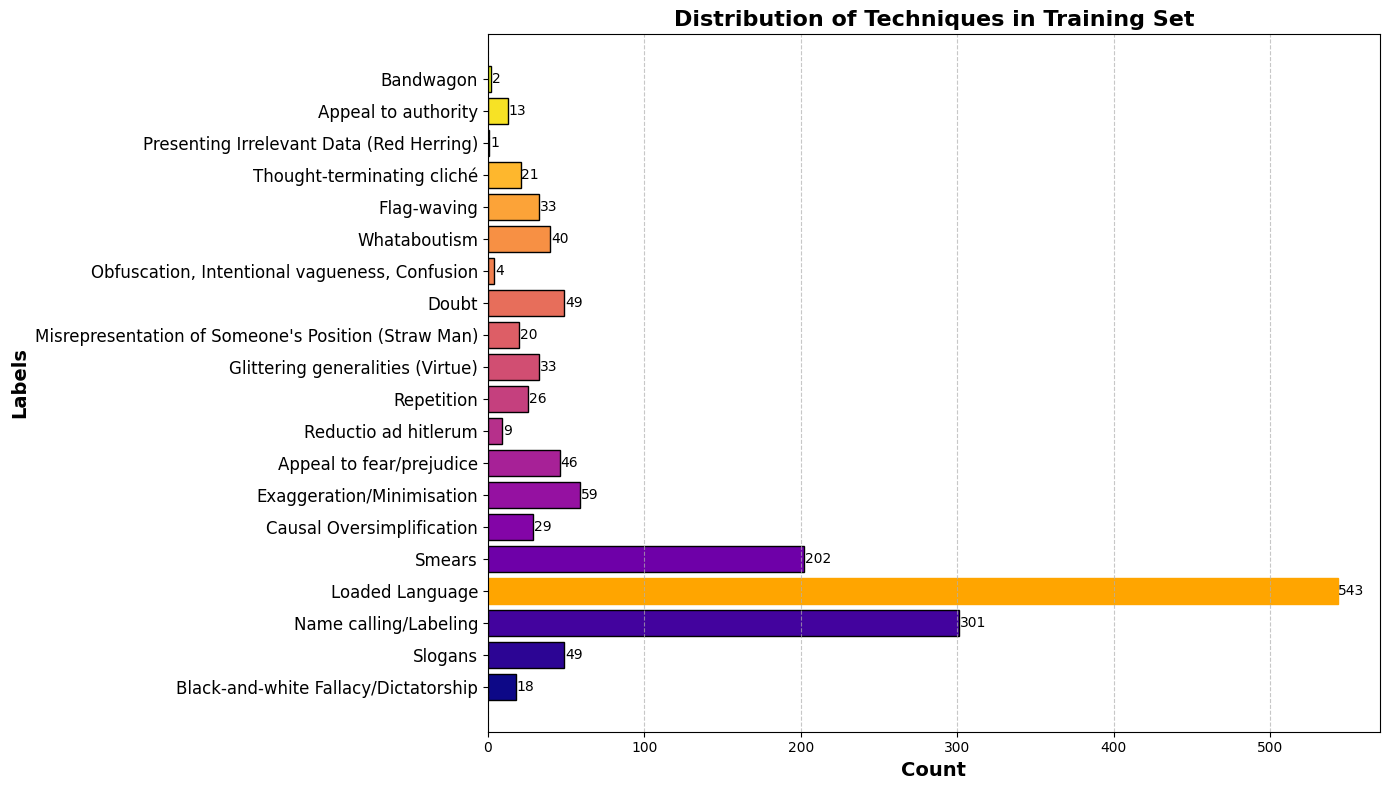

In [ ]:
plot_label_distribution(train_json, 'Distribution of Techniques in Training Set')

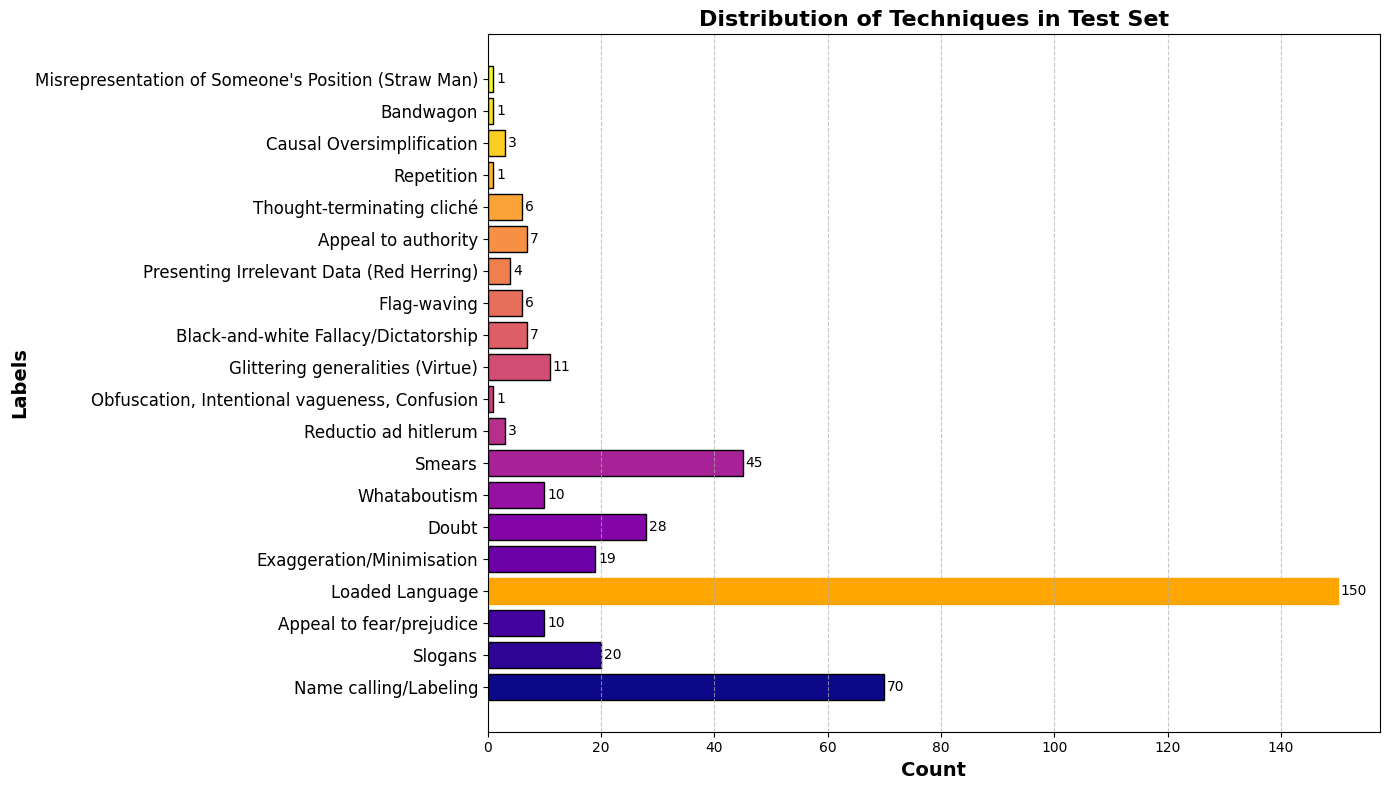

In [ ]:
plot_label_distribution(test_json, 'Distribution of Techniques in Test Set')

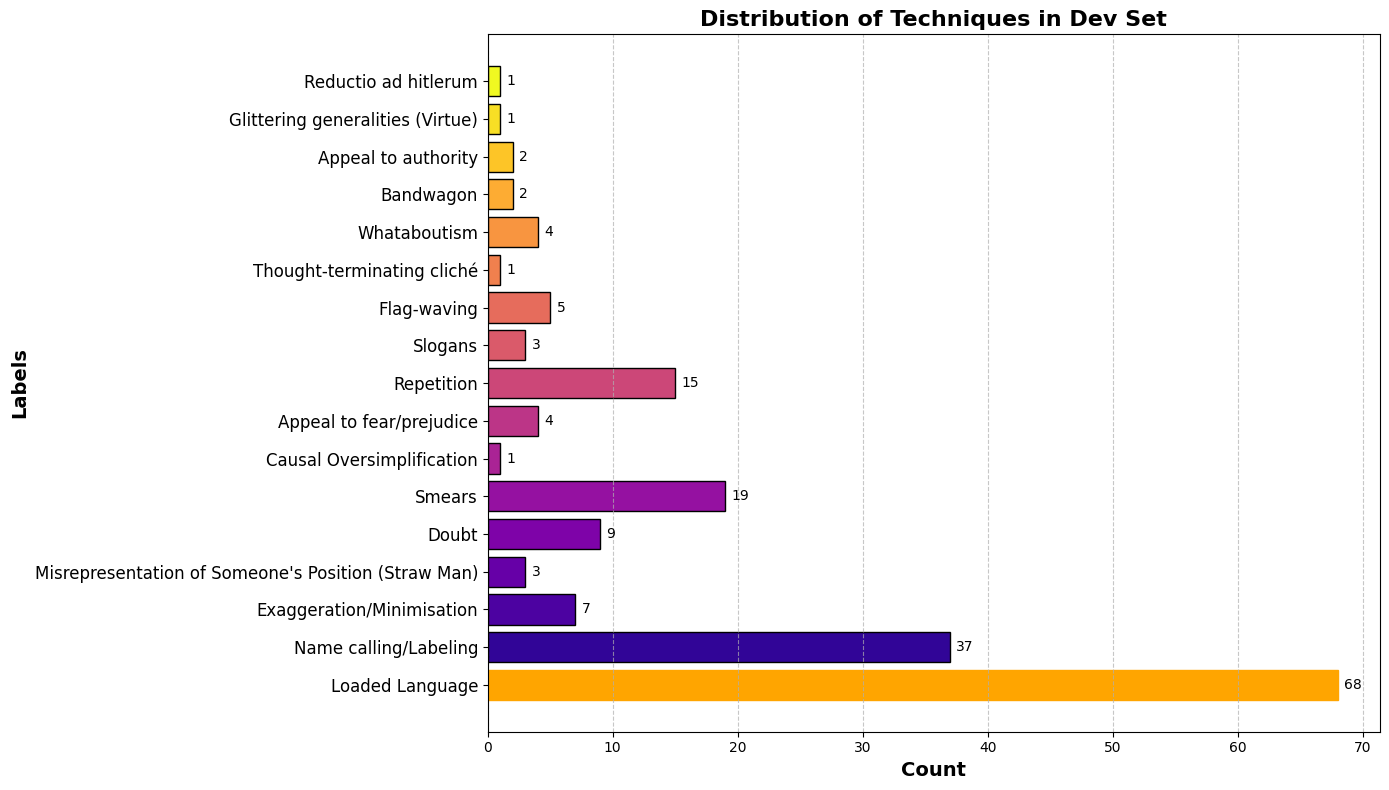

In [ ]:
plot_label_distribution(dev_json, 'Distribution of Techniques in Dev Set')

Key Observations:

*   **Class Imbalance:** Across all three datasets (training, test, and dev), the label "Loaded Language" is consistently the most frequent, followed by "Smears" and "Name calling/Labeling." The disproportionate representation of these labels could lead to biased model predictions, where the model may over-predict these dominant classes.
*   **Impact on Model Training:** Due to the imbalance, the model may struggle with under-represented classes, as they occur too infrequently for the model to learn their patterns effectively. Techniques like class weighting or oversampling could be considered to address this.
*   **Consistency Across Sets:** The patterns in label frequency are somewhat consistent between the training, test, and dev sets. This indicates that the data split was done in a way that maintains the distribution of labels across sets, though the imbalance remains a concern.






### e. Text Preprocessing

As same as the main task, the following code normalizes both the main text and label text fragments in the dataset by converting all text to lowercase and replacing consecutive newline characters (\n\n) with a separator ([SEP]). It applies these steps to ensure consistency and cleanliness in the text data for improved processing in machine learning tasks. This normalization is performed across the training, testing, and development datasets.

In [ ]:
def normalize_text_data(dataset):
    """
    Normalize the text and label text fragments in the given dataset.
    This function lowercases the main text and replaces double newlines with '[SEP]'.
    It also processes each label's text fragment in the same way.

    Parameters:
    dataset (list): The dataset containing samples to normalize.
    """
    for sample in dataset:
        # Normalize the main text
        sample['text'] = sample['text'].lower().replace('\n\n', '[SEP]')

        # Normalize each text fragment in the labels
        for label in sample['labels']:
            label['text_fragment'] = label['text_fragment'].lower().replace('\n\n', '[SEP]')

# Normalize text data in all datasets
normalize_text_data(train_json)
normalize_text_data(test_json)
normalize_text_data(dev_json)

## ***II. Handling Class Imbalance and Model Approach***

### a. Dealing with Data Imbalance

Addressing label imbalance is a significant challenge in our dataset, much like in the main task. To tackle this, we plan to experiment with Focal Loss, which emphasizes difficult-to-classify samples. Additionally, recognizing that Focal Loss may not completely solve the imbalance issue, we will also consider adjusting the decision thresholds to further enhance the model's overall performance.

### b. Performance Goals

For evaluation, we have selected the micro F1 score, precision, and recall. These metrics are crucial for understanding the model's performance. Precision measures the model's ability to minimize false positives, providing insight into its accuracy when predicting positive instances. Recall, on the other hand, evaluates how well the model captures true positives while minimizing false negatives. By considering both precision and recall, the F1 score offers a balanced view of the model’s performance, highlighting the trade-offs between these two important aspects.

In the original competition, the primary metric was the micro F1 score, with a random baseline achieving a low score of 0.01. The top-performing models, which utilized advanced language models like BERT, achieved scores between 0.4 and 0.5. Given our limited computational resources, we are setting a target micro F1 score of 0.25 on the test set for our final model.

In addition to the micro F1 score, we are also aiming for a precision and recall of 0.25 on the test set. Achieving these targets would indicate that our model maintains a good balance between making accurate positive predictions and successfully identifying all relevant instances.

## ***III. Baseline Model Architecture***

The baseline model for the enhancement task is structured to leverage a pretrained text model, specifically ALBERT, to extract features from the input text, followed by a Dense layer with a sigmoid activation function for classification. This design mirrors the baseline model from the main task, which utilized a dual-branch architecture to process both text and image components before combining their features for final classification. However, the enhancement task excludes the image processing component, focusing solely on text input. A significant distinction lies in how the model processes the data, particularly during the loading phase.

**Text Preprocessing**

To effectively prepare the text data for the ALBERT model, we first utilize its specific tokenizer. This step is essential, as transformer-based models require input data to be tokenized in a format they can process. We load the ALBERT tokenizer, enabling us to tokenize and encode the texts before inputting them into the model.

We compile the texts from our training, testing, and development datasets, calculating the maximum sequence length needed for padding. This ensures that all tokenized inputs are uniform in length, which is crucial for model training. Additionally, we establish label mappings to efficiently encode the multi-label classification targets.

The tokenization and encoding process is further refined in the tokenize_and_encode_labels function, where each example is tokenized, and labels are encoded based on the character span of the original text. This method ensures that we maintain alignment between the tokenized text and the corresponding labels, which is crucial for accurate predictions.

**Model Structure Justification**

Given the nuanced and complex nature of meme language, which often contains humor and multiple meanings, training a language model from scratch is not feasible with our limited text corpus. Instead, we leverage the ALBERT model, which has been pretrained on extensive text data, thus enabling it to capture the intricacies of language efficiently.

In the context of the main task's dual-branch architecture, which processed both text and image components, our enhancement task simplifies this to focus solely on text. This reduction allows us to streamline the model while still utilizing a powerful language model that is suitable for our computational constraints. ALBERT offers competitive performance compared to other transformer models like BERT, making it an optimal choice for extracting meaningful features from text without overwhelming our resources.

**Model Training and Optimization**

The features extracted through the ALBERT model are processed through a Dense layer with a sigmoid activation function, which facilitates multi-label classification. This design enables the model to predict multiple labels for each instance effectively.

For optimization, we choose the Nadam optimizer, a combination of RMSprop and Nesterov Accelerated Gradient, to ensure faster convergence. This choice of optimizer is particularly important given the complexity of our task, as it helps the model efficiently adjust weights during training.

By focusing on a pretrained language model and leveraging efficient tokenization processes, we aim to balance performance and computational feasibility while addressing the unique challenges presented by meme text. This targeted approach builds on the foundational principles of the main task's architecture, where the dual-branch model effectively combined text and image features, while refining it to fit the enhancement task's specific requirements.

### a. Preprocessing Text and Images for ALBERT-Based Multi-Modal Model

In preparing the dataset for the ALBERT-based multi-modal model, we focus on preprocessing the text data to ensure it is compatible with the transformer architecture. This process involves several critical steps, from loading the appropriate tokenizer to encoding the text and labels for training.

We begin by loading the ALBERT tokenizer, which is essential for processing the text data. The tokenizer is designed to convert raw text into a format that the ALBERT model can understand. We specify the model name as 'albert-large-v2' when loading the tokenizer

In [ ]:
# Load the ALBERT tokenizer
albert_model_name = 'albert-large-v2'
albert_tokenizer = AutoTokenizer.from_pretrained(albert_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Next, we analyze our dataset, which contains a total of 951 texts. We determine the maximum sequence length required for padding, which is calculated to be 101. This value ensures that all input sequences have a consistent length, critical for batch processing in the model.

In [ ]:
texts = [sample['text'] for sample in train_json + test_json + dev_json]
print(f"Total number of texts: {len(texts)}")

# Calculate the maximum sequence length after tokenization
max_len = max(len(albert_tokenizer.encode(text, add_special_tokens=False)) + 2 for text in texts)
print(f"Maximum sequence length for padding: {max_len}")

Total number of texts: 951
Maximum sequence length for padding: 101


To facilitate multi-label classification, we create mappings for the various techniques we aim to classify. Each label is assigned a unique index, enabling efficient encoding.

In [ ]:
# Create mappings for labels
label_to_index = {label: idx for idx, label in enumerate(techniques)}
label_to_index

{'Appeal to authority': 0,
 'Appeal to fear/prejudice': 1,
 'Black-and-white Fallacy/Dictatorship': 2,
 'Causal Oversimplification': 3,
 'Doubt': 4,
 'Exaggeration/Minimisation': 5,
 'Flag-waving': 6,
 'Glittering generalities (Virtue)': 7,
 'Loaded Language': 8,
 "Misrepresentation of Someone's Position (Straw Man)": 9,
 'Name calling/Labeling': 10,
 'Obfuscation, Intentional vagueness, Confusion': 11,
 'Presenting Irrelevant Data (Red Herring)': 12,
 'Reductio ad hitlerum': 13,
 'Repetition': 14,
 'Slogans': 15,
 'Smears': 16,
 'Thought-terminating cliché': 17,
 'Whataboutism': 18,
 'Bandwagon': 19}

For instance, the label "Appeal to authority" is mapped to index 0, while "Whataboutism" is mapped to index 19. We also establish a reverse mapping from indices to labels for ease of interpretation during the evaluation phase.

In [ ]:
# Get index to label
index_to_label = {v: k for k, v in label_to_index.items()}
index_to_label

{0: 'Appeal to authority',
 1: 'Appeal to fear/prejudice',
 2: 'Black-and-white Fallacy/Dictatorship',
 3: 'Causal Oversimplification',
 4: 'Doubt',
 5: 'Exaggeration/Minimisation',
 6: 'Flag-waving',
 7: 'Glittering generalities (Virtue)',
 8: 'Loaded Language',
 9: "Misrepresentation of Someone's Position (Straw Man)",
 10: 'Name calling/Labeling',
 11: 'Obfuscation, Intentional vagueness, Confusion',
 12: 'Presenting Irrelevant Data (Red Herring)',
 13: 'Reductio ad hitlerum',
 14: 'Repetition',
 15: 'Slogans',
 16: 'Smears',
 17: 'Thought-terminating cliché',
 18: 'Whataboutism',
 19: 'Bandwagon'}

The function tokenize_and_encode_labels is defined to handle the tokenization of input text and the encoding of labels for multi-label classification. This function processes each example by tokenizing the text and determining which tokens correspond to the specified character-based labels

In [ ]:
def tokenize_and_encode_labels(example, tokenizer, label_to_index, max_length=max_len):
    """Tokenizes the input text and encodes the labels for multi-label classification."""

    # Tokenization and encoding
    encoding = tokenizer(example['text'], padding='max_length', truncation=True,
                         max_length=max_length, return_offsets_mapping=True)

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    offset_mapping = encoding['offset_mapping']

    # Initialize label arrays for multi-label binary classification
    labels = [[0] * len(label_to_index) for _ in range(len(input_ids))]

    # Map character-based labels to tokenized labels
    for label in example['labels']:
        start_char, end_char = label['start'], label['end']
        label_name = label['technique']

        for idx, (start_token, end_token) in enumerate(offset_mapping):
            if input_ids[idx] in tokenizer.all_special_ids:
                continue

            # Check if the token spans the character range
            if start_token >= start_char and end_token <= end_char:
                labels[idx][label_to_index[label_name]] = 1

    return input_ids, attention_mask, labels

We subsequently utilize the create_tf_dataset function to transform our processed data into TensorFlow datasets suitable for training, testing, and validation.


In [ ]:
def create_tf_dataset(data, tokenizer, label_to_index, max_length=max_len, shuffle=True):
    """Creates a TensorFlow dataset from the input data."""

    input_ids_list, attention_mask_list, label_list = [], [], []

    for example in data:
        input_ids, attention_mask, labels = tokenize_and_encode_labels(example, tokenizer, label_to_index, max_length)
        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)
        label_list.append(labels)

    # Convert lists to tensors
    input_ids_tensor = tf.constant(input_ids_list)
    attention_mask_tensor = tf.constant(attention_mask_list)
    label_tensor = tf.constant(label_list)

    # Create TensorFlow dataset and apply batching and prefetching
    dataset = tf.data.Dataset.from_tensor_slices(((input_ids_tensor, attention_mask_tensor), label_tensor))
    if shuffle:
        dataset = dataset.shuffle(len(data))
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Create TensorFlow datasets for training, testing, and validation
train_ds = create_tf_dataset(train_json, albert_tokenizer, label_to_index, shuffle=True)
test_ds = create_tf_dataset(test_json, albert_tokenizer, label_to_index)
dev_ds = create_tf_dataset(dev_json, albert_tokenizer, label_to_index)

The correct shape for each input_id and label should be (sequence_length,) and (sequence_length, number_of_labels) respectively

In [ ]:
def visualize_dataset(ds):
    """Visualizes the dataset by decoding input IDs and displaying token labels."""

    for data, labels in ds.take(1):
        input_ids, attention_mask = data
        input_id = input_ids[0].numpy()
        label = labels[0].numpy()
        decoded_text = albert_tokenizer.decode(input_id, skip_special_tokens=True)

        # Prepare token labels
        token_labels = []
        for i, token_id in enumerate(input_id):
            if token_id == albert_tokenizer.pad_token_id:
                continue

            # Retrieve active labels for the token
            active_labels = [index_to_label[idx] for idx, value in enumerate(label[i]) if value == 1]
            token = albert_tokenizer.decode([token_id])

            if active_labels:
                token_labels.append((token, active_labels))

        # Print the decoded text and token labels
        print(f"Decoded text: {decoded_text}")
        for token, token_label in token_labels:
            print(f"Token: '{token}', Labels: {', '.join(token_label)}")

In [ ]:
visualize_dataset(train_ds)

Decoded text: hey nancy, yeah its me adam call soros, i need to order a school shooting, this impeachment hearing b.s. just blew up in our faces. we need a distraction.
Token: 'hey', Labels: Smears
Token: 'nancy', Labels: Smears
Token: ',', Labels: Smears
Token: 'yeah', Labels: Smears
Token: 'its', Labels: Smears
Token: 'me', Labels: Smears
Token: 'adam', Labels: Smears
Token: 'call', Labels: Smears
Token: 'so', Labels: Smears
Token: 'ros', Labels: Smears
Token: ',', Labels: Smears
Token: 'i', Labels: Smears
Token: 'need', Labels: Smears
Token: 'to', Labels: Smears
Token: 'order', Labels: Loaded Language, Smears
Token: 'a', Labels: Loaded Language, Smears
Token: 'school', Labels: Loaded Language, Smears
Token: 'shooting', Labels: Loaded Language, Smears
Token: ',', Labels: Smears
Token: 'this', Labels: Smears
Token: 'impeachment', Labels: Name calling/Labeling, Smears
Token: 'hearing', Labels: Name calling/Labeling, Smears
Token: 'b', Labels: Loaded Language, Name calling/Labeling, Sme

Several tokens are correctly labeled, such as "order" and "school" being associated with the label "Loaded Language," while others are marked with "Smears." This demonstrates the model's capability to discern and categorize nuanced language effectively.

### b. Model Training and Evaluation

In the training of the baseline ALBERT model, we do not fine-tune the pre-trained layers of the ALBERT model, ensuring that only the classifier layers are updated. The training process includes several components and parameters designed for optimal performance in multi-label classification tasks.

We define a helper function create_callbacks, which includes an EarlyStopping callback. This callback monitors the validation F1 score (val_F1) and stops training early if the metric doesn't improve for 5 consecutive epochs, restoring the model weights to the best performing epoch. This is crucial for preventing overfitting and reducing unnecessary computation.

In [ ]:
# Helper function to redefine callbacks
def create_callbacks(cbs=[]):
    # Create a list of callbacks including EarlyStopping
    res_cbs = [cb for cb in cbs]  # Preserve any existing callbacks

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True, monitor="val_F1", mode="max"
    )
    res_cbs.append(early_stopping_cb)  # Add EarlyStopping callback

    return res_cbs

The build_albert_model function loads a pre-trained ALBERT model (albert-large-v2), which is designed for natural language understanding tasks. This model remains frozen, meaning its weights are not updated during training. Instead, we extract embeddings from the ALBERT model and feed them into a dense layer with sigmoid activation, as this is suitable for multi-label classification, where each output is predicted independently.

In [ ]:
def build_albert_model(pretrained_name='albert-large-v2'):
    """Builds an ALBERT model for multi-label classification."""

    # Load the pre-trained ALBERT model
    albert_model = TFAutoModel.from_pretrained(pretrained_name)
    albert_model.trainable = False  # Freeze the ALBERT model parameters

    # Define the input layers
    input_ids = layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

    # Get text embeddings from ALBERT
    text_embeddings = albert_model(input_ids, attention_mask=attention_mask)[0]  # Output hidden states

    # Define the output layer with sigmoid activation for multi-label classification
    logits = layers.Dense(len(techniques), activation='sigmoid')(text_embeddings)

    # Create the Keras model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=logits)

    return model, albert_model

We use the F1 score (micro-average), precision, and recall as our evaluation metrics. The micro-average F1 score is especially useful in multi-label classification, as it provides a balance between precision and recall across all labels.

In [ ]:
def get_evaluation_metrics():
    # Return the list of metrics to be used
    return [
        tfa.metrics.F1Score(num_classes=len(techniques), threshold=0.5, name="F1", average='micro'),
        tf.keras.metrics.Precision(name="Precision"),
        tf.keras.metrics.Recall(name="Recall"),
    ]

In the compile_model function, we use the Nadam optimizer and Binary Focal Loss with label smoothing and an alpha parameter. Focal loss helps address class imbalance by focusing on harder-to-classify examples. Label smoothing adds noise to the labels, which can prevent overconfidence in predictions.

In [ ]:
def compile_model(model, learning_rate=1e-5, label_smoothing=0.1, alpha=1.2):
    """Compiles the model with the specified optimizer and loss function."""

    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    loss_function = losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=label_smoothing, alpha=alpha)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=get_evaluation_metrics())
    return model

In [ ]:
def train_model(model, train_ds, dev_ds, epochs=10):
    """Trains the model on the training dataset."""

    baseline_history = model.fit(
        train_ds,
        validation_data=dev_ds,
        epochs=epochs,
        callbacks=create_callbacks(),
        verbose=True
    )
    return baseline_history

In [ ]:
# Build and train the baseline model
baseline_model, albert_model = build_albert_model()
baseline_model = compile_model(baseline_model) # Compile the model before training
baseline_history = train_model(baseline_model, train_ds, dev_ds)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All

Epoch 1/20
137/137 [==============================] - 215s 1s/step - loss: 0.3746 - F1: 0.0210 - Precision: 0.0107 - Recall: 0.4900 - val_loss: 0.3206 - val_F1: 0.0309 - val_Precision: 0.0159 - val_Recall: 0.4953
Epoch 2/20
137/137 [==============================] - 182s 1s/step - loss: 0.2747 - F1: 0.0218 - Precision: 0.0112 - Recall: 0.4295 - val_loss: 0.2411 - val_F1: 0.0332 - val_Precision: 0.0173 - val_Recall: 0.4461
Epoch 3/20
137/137 [==============================] - 181s 1s/step - loss: 0.2062 - F1: 0.0235 - Precision: 0.0121 - Recall: 0.3796 - val_loss: 0.1867 - val_F1: 0.0365 - val_Precision: 0.0191 - val_Recall: 0.4008
Epoch 4/20
137/137 [==============================] - 182s 1s/step - loss: 0.1598 - F1: 0.0262 - Precision: 0.0136 - Recall: 0.3331 - val_loss: 0.1493 - val_F1: 0.0406 - val_Precision: 0.0215 - val_Recall: 0.3595
Epoch 5/20
137/137 [==============================] - 182s 1s/step - loss: 0.1280 - F1: 0.0302 - Precision: 0.0159 - Recall: 0.2987 - val_loss: 0.12

*   **Training Loss:** Starts at 0.3746 and steadily decreases to 0.0306 by epoch 20.
*   **Validation Loss:** Starts at 0.3206 and decreases to 0.0341 by epoch 20.
*   **F1 Score:** Starts very low at 0.0210 in epoch 1 and gradually increases to 0.0713 by epoch 20, showing improvement in balancing precision and recall.
*   **Precision and Recall:** Initially, the recall is quite high (0.4900) but with low precision (0.0107), which indicates the model is identifying many true positives but with many false positives. Over time, precision improves slightly, reaching 0.0528 by epoch 20, and recall drops to 0.1101.



In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # F1 Score
    axs[0, 0].plot(epochs, history.history['F1'], label='Training F1', marker='o')
    axs[0, 0].plot(epochs, history.history['val_F1'], label='Validation F1', marker='o')
    axs[0, 0].set_title('Training and Validation F1 Score', fontsize=14)
    axs[0, 0].set_xlabel('Epochs', fontsize=12)
    axs[0, 0].set_ylabel('Score', fontsize=12)
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Recall
    axs[0, 1].plot(epochs, history.history['Recall'], label='Training Recall', marker='o')
    axs[0, 1].plot(epochs, history.history['val_Recall'], label='Validation Recall', marker='o')
    axs[0, 1].set_title('Training and Validation Recall', fontsize=14)
    axs[0, 1].set_xlabel('Epochs', fontsize=12)
    axs[0, 1].set_ylabel('Score', fontsize=12)
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Overall Loss
    axs[1, 0].plot(epochs, history.history['loss'], label='Training Loss (Overall)', marker='o')
    axs[1, 0].plot(epochs, history.history['val_loss'], label='Validation Loss (Overall)', marker='o')
    axs[1, 0].set_title('Training and Validation Loss (Overall)', fontsize=14)
    axs[1, 0].set_xlabel('Epochs', fontsize=12)
    axs[1, 0].set_ylabel('Loss', fontsize=12)
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Precision
    axs[1, 1].plot(epochs, history.history['Precision'], label='Training Precision', marker='o')
    axs[1, 1].plot(epochs, history.history['val_Precision'], label='Validation Precision', marker='o')
    axs[1, 1].set_title('Training and Validation Precision', fontsize=14)
    axs[1, 1].set_xlabel('Epochs', fontsize=12)
    axs[1, 1].set_ylabel('Score', fontsize=12)
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

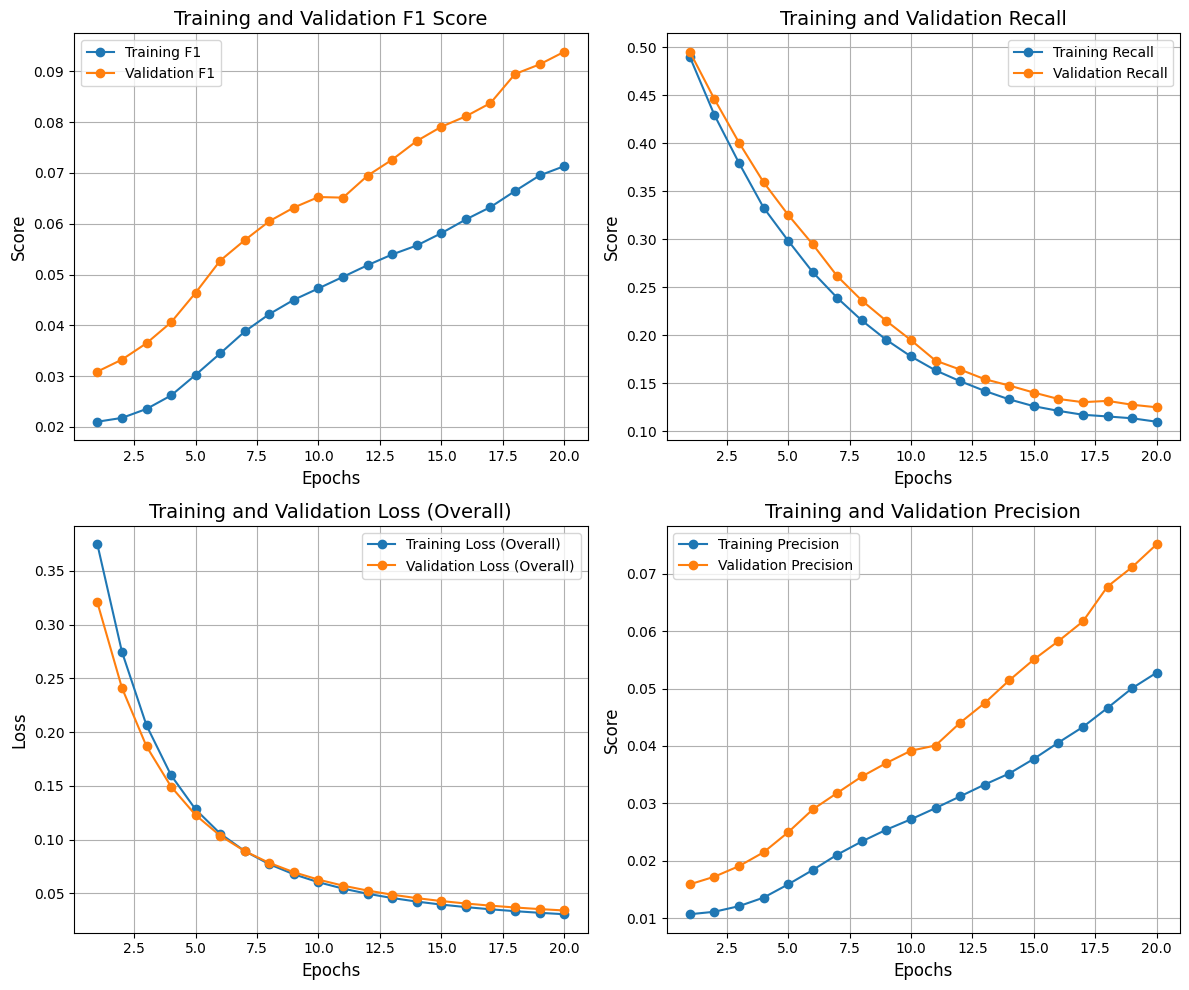

In [ ]:
plot_training_history(baseline_history)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Epoch 1/20
137/137 [==============================] - 201s 1s/step - loss: 0.3353 - F1: 0.0208 - Precision: 0.0106 - Recall: 0.4690 - val_loss: 0.2938 - val_F1: 0.0292 - val_Precision: 0.0151 - val_Recall: 0.4407
Epoch 2/20
137/137 [==============================] - 170s 1s/step - loss: 0.2456 - F1: 0.0230 - Precision: 0.0118 - Recall: 0.4139 - val_loss: 0.2230 - val_F1: 0.0312 - val_Precision: 0.0163 - val_Recall: 0.3768
Epoch 3/20
137/137 [==============================] - 170s 1s/step - loss: 0.1860 - F1: 0.0265 - Precision: 0.0137 - Recall: 0.3684 - val_loss: 0.1751 - val_F1: 0.0354 - val_Precision: 0.0187 - val_Recall: 0.3395
Epoch 4/20
137/137 [==============================] - 171s 1s/step - loss: 0.1460 - F1: 0.0308 - Precision: 0.0162 - Recall: 0.3294 - val_loss: 0.1417 - val_F1: 0.0388 - val_Precision: 0.0208 - val_Recall: 0.2996
Epoch 5/20
137/137 [==============================] - 180s 1s/step - loss: 0.1183 - F1: 0.0348 - Precision: 0.0185 - Recall: 0.2920 - val_loss: 0.11

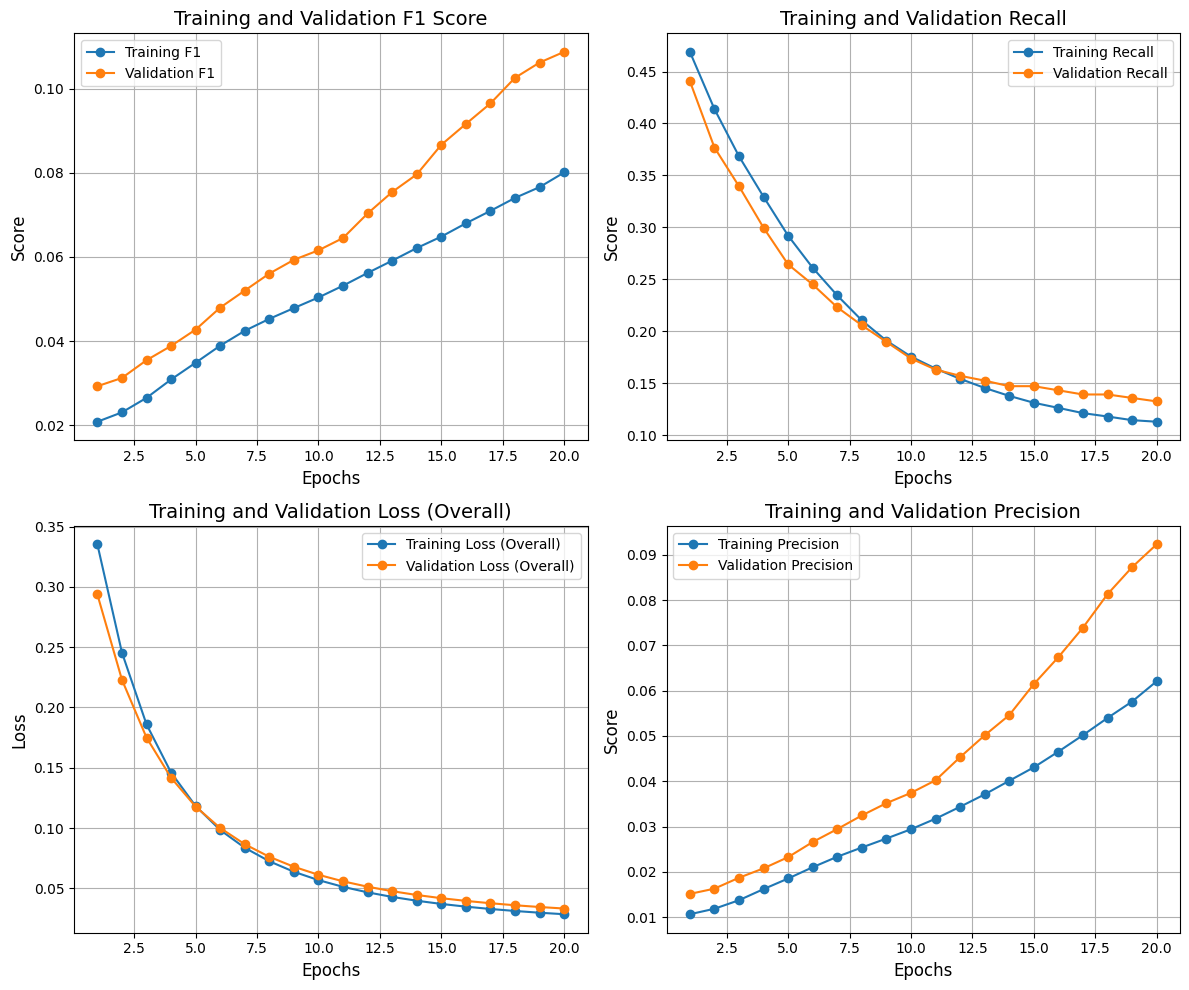

In [ ]:
# Build and train a model with modified parameters
model, albert = build_albert_model(pretrained_name='albert-large-v2')
model = compile_model(model, label_smoothing=0.1, alpha=1.2)
history = train_model(model, train_ds, dev_ds)

# Plot the training history for the second model
plot_training_history(history)

*   **Training Loss:** Starts at 0.3353 and decreases to 0.0348 by epoch 16.
*   **Validation Loss:** Starts at 0.2938 and decreases to 0.0396 by epoch 16 (last provided epoch).
*   **F1 Score:** Starts at 0.0208 and rises to 0.0680 by epoch 16.
*   **Precision and Recall:** Precision improves to 0.0465 by epoch 16, while recall is similar to the baseline model, around 0.1262.

**Key Insights:**

*   **Loss:** Both models show consistent loss reduction during training and validation, with the modified model exhibiting slightly better performance earlier in the training (lower loss by epoch 16 compared to the baseline at a similar point).
*   **F1 Score:** Both models improve gradually, but the modified model seems to achieve similar F1 scores earlier (e.g., reaching 0.0680 by epoch 16 compared to the baseline's 0.0633 at a similar point).
*   **Precision and Recall:** Precision increases more significantly in the modified model compared to the baseline. This suggests that your modified parameters (e.g., label smoothing and alpha value) might be helping the model focus on more accurate predictions.




**Next Step:**

To further refine the model's performance, we will focus on rebalancing the Precision-Recall tradeoff by applying two key strategies: label smoothing and adjusting the parameters of focal loss.

First, we will introduce label smoothing with a value of 0.1. This technique helps prevent the model from becoming overly confident in its predictions, reducing the risk of overfitting. Label smoothing is commonly used in state-of-the-art transformer models such as BERT and T5, and it has been shown to improve generalization by softening the ground truth labels.

Next, we will adjust the alpha parameter in focal loss, setting it to a value greater than 1. By increasing alpha, we shift more of the loss contribution to positive examples, encouraging the model to focus more on underrepresented classes. This adjustment should enhance recall for positive examples without changing gamma, as we do not assume that minority classes are necessarily harder to classify.

These strategies are designed to strike a better balance between precision and recall, particularly for underrepresented classes, and ultimately improve the model's overall performance.

## ***IV. Recall-Precision tradeoff***

This code is focused on the Recall-Precision tradeoff during the training of a binary classification model using the ALBERT (A Lite BERT) model and Focal Loss to handle class imbalance. The focal loss is customized with tunable parameters such as label smoothing and alpha, and the goal is to balance the tradeoff between Recall and Precision as the model is trained.

In [ ]:
def build_and_compile_model(pretrained_name='albert-large-v2', label_smoothing=0.1, alpha=1.2):
    """Builds and compiles an ALBERT model."""

    model, _ = build_albert_model(pretrained_name)

    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)
    loss_function = losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=label_smoothing, alpha=alpha)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=get_evaluation_metrics())
    return model

def train_and_evaluate_model(model, train_ds, dev_ds, epochs=10):
    """Trains and evaluates the model."""

    history = model.fit(
        train_ds,
        validation_data=dev_ds,
        epochs=epochs,
        callbacks=create_callbacks(),
        verbose=True
    )

    return history, model.evaluate(dev_ds, verbose=False)

In [ ]:
# Build and train the baseline model
baseline_model = build_and_compile_model()
baseline_history, baseline_score = train_and_evaluate_model(baseline_model, train_ds, dev_ds)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Epoch 1/10
137/137 [==============================] - 208s 1s/step - loss: 0.3411 - F1: 0.0137 - Precision: 0.0070 - Recall: 0.2889 - val_loss: 0.2862 - val_F1: 0.0197 - val_Precision: 0.0102 - val_Recall: 0.2743
Epoch 2/10
137/137 [==============================] - 172s 1s/step - loss: 0.2507 - F1: 0.0147 - Precision: 0.0076 - Recall: 0.2512 - val_loss: 0.2160 - val_F1: 0.0213 - val_Precision: 0.0112 - val_Recall: 0.2377
Epoch 3/10
137/137 [==============================] - 174s 1s/step - loss: 0.1894 - F1: 0.0163 - Precision: 0.0084 - Recall: 0.2184 - val_loss: 0.1680 - val_F1: 0.0244 - val_Precision: 0.0130 - val_Recall: 0.2150
Epoch 4/10
137/137 [==============================] - 177s 1s/step - loss: 0.1478 - F1: 0.0186 - Precision: 0.0097 - Recall: 0.1932 - val_loss: 0.1347 - val_F1: 0.0270 - val_Precision: 0.0146 - val_Recall: 0.1911
Epoch 5/10
137/137 [==============================] - 183s 1s/step - loss: 0.1189 - F1: 0.0212 - Precision: 0.0113 - Recall: 0.1729 - val_loss: 0.11

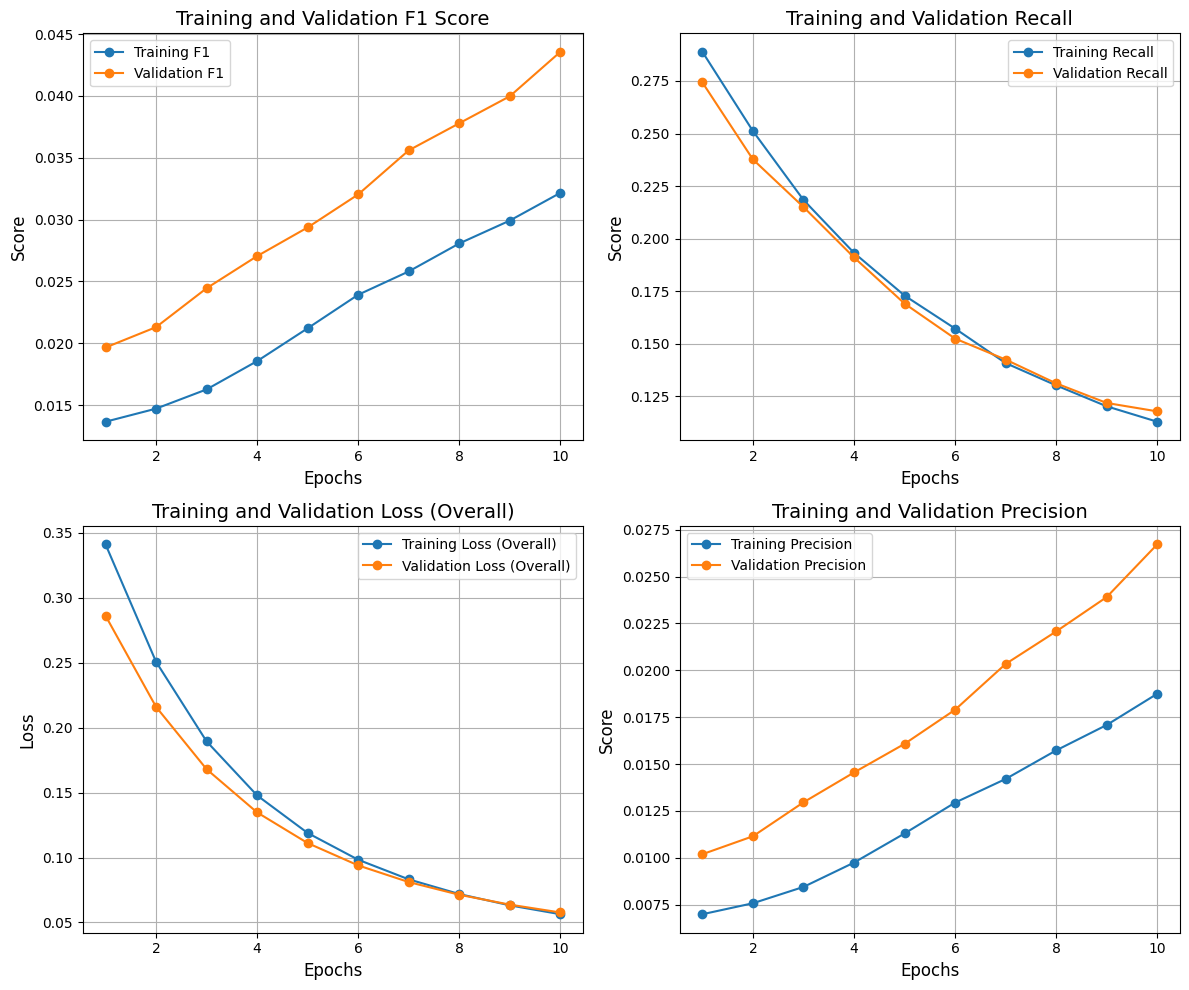

In [ ]:
plot_training_history(baseline_history)

Observations:
*   **Impact of Label Smoothing and Alpha:** Label smoothing and increasing the alpha parameter for focal loss have a noticeable but small impact on recall. These hyperparameters can be further tuned to find the best balance for the model.
*   **Precision-Recall Tradeoff:** As training progresses, precision improves at a faster rate compared to recall. This is expected when using focal loss, which focuses more on difficult-to-classify examples, often resulting in improved precision for minority classes.

The final F1 score of the model improves from epoch to epoch, indicating better balance between precision and recall. By further tuning label_smoothing and alpha, it is possible to improve the recall performance, especially for minority classes, while keeping precision from deteriorating.

### Hyperparameter tuning

Next we will focuse on hyperparameter tuning using Optuna to optimize the model's performance, particularly improving Precision and Recall, which in turn will enhance the F1 score. Since training the ALBERT-large model is computationally expensive and time-consuming, the smaller ALBERT-base model is used for hyperparameter optimization to speed up the process.

In [ ]:
def objective(trial):
    """Defines the objective function for Optuna optimization."""
    tf.keras.backend.clear_session()  # Clear previous session

    # Suggest hyperparameters for tuning
    label_smoothing = trial.suggest_float("label_smoothing", 0.1, 0.3, step=0.1)
    alpha = trial.suggest_float("alpha", 1.0, 2.0, step=0.2)

    # Build and compile the model with suggested hyperparameters
    model = build_and_compile_model(label_smoothing=label_smoothing, alpha=alpha)

    # Train the model and return the evaluation score
    _, score = train_and_evaluate_model(model, train_ds, dev_ds, epochs=10)

    return score[2], score[3]  # Return metrics of interest

In [ ]:
# Set up Optuna study
db_name = f"sqlite:///{'tagger-study'}.db"
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)

In [ ]:
study = optuna.create_study(
    directions=["maximize", "maximize"],
    sampler=sampler,
    study_name="tagger-study",
    storage=db_name,
    load_if_exists=True
)

[I 2024-10-12 22:08:08,018] A new study created in RDB with name: tagger-study


In [ ]:
# Run the optimization
study.optimize(objective, n_trials=10)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Epoch 1/10
137/137 [==============================] - 205s 1s/step - loss: 0.3022 - F1: 0.0186 - Precision: 0.0095 - Recall: 0.3799 - val_loss: 0.2674 - val_F1: 0.0253 - val_Precision: 0.0131 - val_Recall: 0.3549
Epoch 2/10
137/137 [==============================] - 172s 1s/step - loss: 0.2346 - F1: 0.0197 - Precision: 0.0102 - Recall: 0.3363 - val_loss: 0.2125 - val_F1: 0.0260 - val_Precision: 0.0136 - val_Recall: 0.3056
Epoch 3/10
137/137 [==============================] - 172s 1s/step - loss: 0.1861 - F1: 0.0211 - Precision: 0.0109 - Recall: 0.2990 - val_loss: 0.1728 - val_F1: 0.0282 - val_Precision: 0.0149 - val_Recall: 0.2743
Epoch 4/10
137/137 [==============================] - 169s 1s/step - loss: 0.1513 - F1: 0.0229 - Precision: 0.0120 - Recall: 0.2673 - val_loss: 0.1439 - val_F1: 0.0303 - val_Precision: 0.0161 - val_Recall: 0.2477
Epoch 5/10
137/137 [==============================] - 172s 1s/step - loss: 0.1261 - F1: 0.0250 - Precision: 0.0132 - Recall: 0.2379 - val_loss: 0.12

[I 2024-10-12 22:38:22,341] Trial 1 finished with values: [0.03040405362844467, 0.1517976075410843] and parameters: {'label_smoothing': 0.3, 'alpha': 1.6}.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the chec

Epoch 1/10
137/137 [==============================] - 196s 1s/step - loss: 0.3096 - F1: 0.0199 - Precision: 0.0102 - Recall: 0.3713 - val_loss: 0.2661 - val_F1: 0.0272 - val_Precision: 0.0142 - val_Recall: 0.3329
Epoch 2/10
137/137 [==============================] - 168s 1s/step - loss: 0.2288 - F1: 0.0225 - Precision: 0.0116 - Recall: 0.3270 - val_loss: 0.2017 - val_F1: 0.0298 - val_Precision: 0.0157 - val_Recall: 0.2949
Epoch 3/10
137/137 [==============================] - 170s 1s/step - loss: 0.1728 - F1: 0.0247 - Precision: 0.0129 - Recall: 0.2868 - val_loss: 0.1566 - val_F1: 0.0308 - val_Precision: 0.0164 - val_Recall: 0.2530
Epoch 4/10
137/137 [==============================] - 172s 1s/step - loss: 0.1340 - F1: 0.0263 - Precision: 0.0139 - Recall: 0.2518 - val_loss: 0.1250 - val_F1: 0.0332 - val_Precision: 0.0179 - val_Recall: 0.2270
Epoch 5/10
137/137 [==============================] - 171s 1s/step - loss: 0.1070 - F1: 0.0285 - Precision: 0.0152 - Recall: 0.2246 - val_loss: 0.10

[I 2024-10-12 23:07:35,723] Trial 2 finished with values: [0.0385311134159565, 0.14181092381477356] and parameters: {'label_smoothing': 0.1, 'alpha': 1.0}.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the chec

Epoch 1/10
137/137 [==============================] - 195s 1s/step - loss: 0.2979 - F1: 0.0260 - Precision: 0.0133 - Recall: 0.5366 - val_loss: 0.2489 - val_F1: 0.0409 - val_Precision: 0.0212 - val_Recall: 0.5539
Epoch 2/10
137/137 [==============================] - 172s 1s/step - loss: 0.2159 - F1: 0.0298 - Precision: 0.0154 - Recall: 0.4856 - val_loss: 0.1866 - val_F1: 0.0470 - val_Precision: 0.0247 - val_Recall: 0.5027
Epoch 3/10
137/137 [==============================] - 168s 1s/step - loss: 0.1624 - F1: 0.0348 - Precision: 0.0181 - Recall: 0.4364 - val_loss: 0.1453 - val_F1: 0.0555 - val_Precision: 0.0295 - val_Recall: 0.4594
Epoch 4/10
137/137 [==============================] - 166s 1s/step - loss: 0.1270 - F1: 0.0403 - Precision: 0.0213 - Recall: 0.3880 - val_loss: 0.1173 - val_F1: 0.0627 - val_Precision: 0.0339 - val_Recall: 0.4148
Epoch 5/10
137/137 [==============================] - 168s 1s/step - loss: 0.1028 - F1: 0.0456 - Precision: 0.0244 - Recall: 0.3433 - val_loss: 0.09

[I 2024-10-12 23:36:11,950] Trial 3 finished with values: [0.05493255332112312, 0.22503328323364258] and parameters: {'label_smoothing': 0.1, 'alpha': 2.0}.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the che

Epoch 1/10
137/137 [==============================] - 196s 1s/step - loss: 0.2491 - F1: 0.0178 - Precision: 0.0092 - Recall: 0.2909 - val_loss: 0.2130 - val_F1: 0.0247 - val_Precision: 0.0129 - val_Recall: 0.2650
Epoch 2/10
137/137 [==============================] - 170s 1s/step - loss: 0.1865 - F1: 0.0192 - Precision: 0.0100 - Recall: 0.2497 - val_loss: 0.1643 - val_F1: 0.0270 - val_Precision: 0.0143 - val_Recall: 0.2324
Epoch 3/10
137/137 [==============================] - 170s 1s/step - loss: 0.1439 - F1: 0.0210 - Precision: 0.0110 - Recall: 0.2172 - val_loss: 0.1308 - val_F1: 0.0288 - val_Precision: 0.0155 - val_Recall: 0.1977
Epoch 4/10
137/137 [==============================] - 168s 1s/step - loss: 0.1146 - F1: 0.0229 - Precision: 0.0122 - Recall: 0.1894 - val_loss: 0.1074 - val_F1: 0.0320 - val_Precision: 0.0176 - val_Recall: 0.1771
Epoch 5/10
137/137 [==============================] - 167s 1s/step - loss: 0.0943 - F1: 0.0251 - Precision: 0.0136 - Recall: 0.1645 - val_loss: 0.09

[I 2024-10-13 00:05:04,842] Trial 4 finished with values: [0.03472067788243294, 0.10386151820421219] and parameters: {'label_smoothing': 0.2, 'alpha': 1.8}.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the che

Epoch 1/10
137/137 [==============================] - 196s 1s/step - loss: 0.3358 - F1: 0.0240 - Precision: 0.0123 - Recall: 0.5397 - val_loss: 0.2939 - val_F1: 0.0320 - val_Precision: 0.0165 - val_Recall: 0.4900
Epoch 2/10
137/137 [==============================] - 169s 1s/step - loss: 0.2454 - F1: 0.0261 - Precision: 0.0134 - Recall: 0.4771 - val_loss: 0.2225 - val_F1: 0.0349 - val_Precision: 0.0182 - val_Recall: 0.4341
Epoch 3/10
137/137 [==============================] - 168s 1s/step - loss: 0.1855 - F1: 0.0291 - Precision: 0.0151 - Recall: 0.4207 - val_loss: 0.1742 - val_F1: 0.0393 - val_Precision: 0.0207 - val_Recall: 0.3862
Epoch 4/10
137/137 [==============================] - 169s 1s/step - loss: 0.1454 - F1: 0.0336 - Precision: 0.0176 - Recall: 0.3741 - val_loss: 0.1409 - val_F1: 0.0445 - val_Precision: 0.0237 - val_Recall: 0.3475
Epoch 5/10
137/137 [==============================] - 167s 1s/step - loss: 0.1178 - F1: 0.0392 - Precision: 0.0208 - Recall: 0.3364 - val_loss: 0.11

[I 2024-10-13 00:34:32,131] Trial 5 finished with values: [0.039471834897994995, 0.1870838850736618] and parameters: {'label_smoothing': 0.1, 'alpha': 2.0}.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the che

Epoch 1/10
137/137 [==============================] - 194s 1s/step - loss: 0.2697 - F1: 0.0280 - Precision: 0.0144 - Recall: 0.5179 - val_loss: 0.2290 - val_F1: 0.0418 - val_Precision: 0.0218 - val_Recall: 0.5133
Epoch 2/10
137/137 [==============================] - 176s 1s/step - loss: 0.2087 - F1: 0.0309 - Precision: 0.0160 - Recall: 0.4627 - val_loss: 0.1807 - val_F1: 0.0455 - val_Precision: 0.0240 - val_Recall: 0.4601
Epoch 3/10
137/137 [==============================] - 180s 1s/step - loss: 0.1651 - F1: 0.0338 - Precision: 0.0176 - Recall: 0.4083 - val_loss: 0.1460 - val_F1: 0.0522 - val_Precision: 0.0278 - val_Recall: 0.4254
Epoch 4/10
137/137 [==============================] - 169s 1s/step - loss: 0.1337 - F1: 0.0369 - Precision: 0.0194 - Recall: 0.3603 - val_loss: 0.1208 - val_F1: 0.0584 - val_Precision: 0.0316 - val_Recall: 0.3828
Epoch 5/10
137/137 [==============================] - 171s 1s/step - loss: 0.1109 - F1: 0.0406 - Precision: 0.0217 - Recall: 0.3215 - val_loss: 0.10

[I 2024-10-13 01:03:54,659] Trial 6 finished with values: [0.056812550872564316, 0.22902795672416687] and parameters: {'label_smoothing': 0.3, 'alpha': 1.2}.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ch

Epoch 1/10
137/137 [==============================] - 196s 1s/step - loss: 0.3126 - F1: 0.0246 - Precision: 0.0126 - Recall: 0.5279 - val_loss: 0.2697 - val_F1: 0.0353 - val_Precision: 0.0183 - val_Recall: 0.4860
Epoch 2/10
137/137 [==============================] - 170s 1s/step - loss: 0.2276 - F1: 0.0297 - Precision: 0.0153 - Recall: 0.4812 - val_loss: 0.2036 - val_F1: 0.0408 - val_Precision: 0.0214 - val_Recall: 0.4381
Epoch 3/10
137/137 [==============================] - 170s 1s/step - loss: 0.1717 - F1: 0.0344 - Precision: 0.0179 - Recall: 0.4328 - val_loss: 0.1589 - val_F1: 0.0456 - val_Precision: 0.0242 - val_Recall: 0.3955
Epoch 4/10
137/137 [==============================] - 169s 1s/step - loss: 0.1340 - F1: 0.0389 - Precision: 0.0204 - Recall: 0.3901 - val_loss: 0.1280 - val_F1: 0.0490 - val_Precision: 0.0263 - val_Recall: 0.3522
Epoch 5/10
137/137 [==============================] - 170s 1s/step - loss: 0.1081 - F1: 0.0425 - Precision: 0.0226 - Recall: 0.3482 - val_loss: 0.10

[I 2024-10-13 01:33:00,789] Trial 7 finished with values: [0.047633539885282516, 0.2083888202905655] and parameters: {'label_smoothing': 0.1, 'alpha': 1.2}.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the che

Epoch 1/10
137/137 [==============================] - 195s 1s/step - loss: 0.3688 - F1: 0.0221 - Precision: 0.0113 - Recall: 0.4927 - val_loss: 0.3312 - val_F1: 0.0286 - val_Precision: 0.0148 - val_Recall: 0.4361
Epoch 2/10
137/137 [==============================] - 168s 1s/step - loss: 0.2751 - F1: 0.0248 - Precision: 0.0128 - Recall: 0.4439 - val_loss: 0.2548 - val_F1: 0.0314 - val_Precision: 0.0163 - val_Recall: 0.3928
Epoch 3/10
137/137 [==============================] - 169s 1s/step - loss: 0.2106 - F1: 0.0281 - Precision: 0.0146 - Recall: 0.4042 - val_loss: 0.2011 - val_F1: 0.0344 - val_Precision: 0.0181 - val_Recall: 0.3555
Epoch 4/10
137/137 [==============================] - 170s 1s/step - loss: 0.1657 - F1: 0.0313 - Precision: 0.0164 - Recall: 0.3647 - val_loss: 0.1627 - val_F1: 0.0380 - val_Precision: 0.0202 - val_Recall: 0.3262
Epoch 5/10
137/137 [==============================] - 167s 1s/step - loss: 0.1339 - F1: 0.0347 - Precision: 0.0183 - Recall: 0.3307 - val_loss: 0.13

[I 2024-10-13 02:01:41,056] Trial 8 finished with values: [0.03657522797584534, 0.20505991578102112] and parameters: {'label_smoothing': 0.1, 'alpha': 1.6}.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the che

Epoch 1/10
137/137 [==============================] - 193s 1s/step - loss: 0.3069 - F1: 0.0276 - Precision: 0.0142 - Recall: 0.5961 - val_loss: 0.2680 - val_F1: 0.0389 - val_Precision: 0.0202 - val_Recall: 0.5646
Epoch 2/10
137/137 [==============================] - 167s 1s/step - loss: 0.2291 - F1: 0.0313 - Precision: 0.0161 - Recall: 0.5375 - val_loss: 0.2059 - val_F1: 0.0435 - val_Precision: 0.0227 - val_Recall: 0.5067
Epoch 3/10
137/137 [==============================] - 168s 1s/step - loss: 0.1758 - F1: 0.0351 - Precision: 0.0182 - Recall: 0.4825 - val_loss: 0.1626 - val_F1: 0.0467 - val_Precision: 0.0247 - val_Recall: 0.4501
Epoch 4/10
137/137 [==============================] - 166s 1s/step - loss: 0.1389 - F1: 0.0382 - Precision: 0.0200 - Recall: 0.4252 - val_loss: 0.1322 - val_F1: 0.0506 - val_Precision: 0.0270 - val_Recall: 0.4021
Epoch 5/10
137/137 [==============================] - 167s 1s/step - loss: 0.1132 - F1: 0.0424 - Precision: 0.0225 - Recall: 0.3796 - val_loss: 0.11

[I 2024-10-13 02:30:13,808] Trial 9 finished with values: [0.04976019263267517, 0.2210386097431183] and parameters: {'label_smoothing': 0.2, 'alpha': 1.2}.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the chec

Epoch 1/10
137/137 [==============================] - 191s 1s/step - loss: 0.2572 - F1: 0.0293 - Precision: 0.0150 - Recall: 0.6224 - val_loss: 0.2187 - val_F1: 0.0447 - val_Precision: 0.0232 - val_Recall: 0.5992
Epoch 2/10
137/137 [==============================] - 166s 1s/step - loss: 0.1896 - F1: 0.0366 - Precision: 0.0189 - Recall: 0.5702 - val_loss: 0.1675 - val_F1: 0.0544 - val_Precision: 0.0287 - val_Recall: 0.5419
Epoch 3/10
137/137 [==============================] - 166s 1s/step - loss: 0.1461 - F1: 0.0452 - Precision: 0.0237 - Recall: 0.5165 - val_loss: 0.1336 - val_F1: 0.0658 - val_Precision: 0.0352 - val_Recall: 0.5000
Epoch 4/10
137/137 [==============================] - 168s 1s/step - loss: 0.1172 - F1: 0.0544 - Precision: 0.0289 - Recall: 0.4650 - val_loss: 0.1103 - val_F1: 0.0772 - val_Precision: 0.0422 - val_Recall: 0.4594
Epoch 5/10
137/137 [==============================] - 166s 1s/step - loss: 0.0972 - F1: 0.0625 - Precision: 0.0338 - Recall: 0.4177 - val_loss: 0.09

[I 2024-10-13 02:58:05,319] Trial 10 finished with values: [0.0700768232345581, 0.24900132417678833] and parameters: {'label_smoothing': 0.2, 'alpha': 1.0}.


Observations:
*   Trial 3 produced the best F1 score and showed the best balance between precision and recall. The higher alpha (2.0) combined with a lower label smoothing (0.1) seems to handle class imbalance better.
*   Label Smoothing: Keeping it lower (0.1) appears to work better for this dataset.
*   Alpha: Values around 1.6 to 2.0 seem optimal for balancing F1, precision, and recall.



In [ ]:
# Get the best trial
best_trial = study.best_trials[0]
print("Best trial:", best_trial)

Best trial: FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.0700768232345581, 0.24900132417678833], datetime_start=datetime.datetime(2024, 10, 13, 2, 30, 13, 817682), datetime_complete=datetime.datetime(2024, 10, 13, 2, 58, 5, 306707), params={'label_smoothing': 0.2, 'alpha': 1.0}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'label_smoothing': FloatDistribution(high=0.3, log=False, low=0.1, step=0.1), 'alpha': FloatDistribution(high=2.0, log=False, low=1.0, step=0.2)}, trial_id=11, value=None)


Since ALBERT-large is computationally expensive, we used ALBERT-base to speed up training. We employed Optuna to optimize the hyperparameters label_smoothing and alpha to maximize both precision and recall, aiming to improve the F1 score. After running the study, the best trial was found with label_smoothing = 0.2 and alpha = 1.0, which provided the optimal balance between precision and recall. This result was derived after conducting 10 trials, carefully evaluating the trade-offs to achieve better overall performance.

## ***V. Fine tuning***

In this phase of the project, we fine-tuned the ALBERT-large model using the previously established hyperparameters. Fine-tuning was divided into two stages to carefully adjust the model’s weights without causing overfitting or large jumps in model performance.

In [ ]:
clear_session()

In [ ]:
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr  # Keep the initial learning rate for the first 10 epochs
    elif 10 <= epoch < 20:
        return lr * 0.1  # Reduce learning rate by a factor of 10 after epoch 10

### a. Stage 1: Freezing ALBERT's Layers

Initially, we froze the ALBERT layers to prevent drastic changes to the pre-trained knowledge and focused on fine-tuning only the task-specific layers. This approach allows the model to specialize in the downstream task while preserving the pre-trained representations from the ALBERT architecture. The learning rate was set to 5e-5 to allow significant updates to these non-frozen layers while preventing overfitting in the early epochs.

In [ ]:
# Build and freeze ALBERT model
model, albert = build_albert_model(pretrained_name="albert-large-v2")
albert.trainable = False

# Compile the model
initial_optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(
    optimizer=initial_optimizer,
    loss=losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=0.1, alpha=1.2),
    metrics=get_evaluation_metrics()
)

# Train the model
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience=5)
history = model.fit(
    train_ds,
    validation_data=dev_ds,
    epochs=10,
    callbacks=create_callbacks(),
    verbose=True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Epoch 1/10
137/137 [==============================] - 184s 1s/step - loss: 0.1939 - F1: 0.0321 - Precision: 0.0167 - Recall: 0.4074 - val_loss: 0.1090 - val_F1: 0.0588 - val_Precision: 0.0321 - val_Recall: 0.3435
Epoch 2/10
137/137 [==============================] - 159s 1s/step - loss: 0.0714 - F1: 0.0583 - Precision: 0.0324 - Recall: 0.2889 - val_loss: 0.0585 - val_F1: 0.0940 - val_Precision: 0.0567 - val_Recall: 0.2736
Epoch 3/10
137/137 [==============================] - 168s 1s/step - loss: 0.0430 - F1: 0.0806 - Precision: 0.0492 - Recall: 0.2226 - val_loss: 0.0420 - val_F1: 0.1068 - val_Precision: 0.0726 - val_Recall: 0.2024
Epoch 4/10
137/137 [==============================] - 166s 1s/step - loss: 0.0326 - F1: 0.0891 - Precision: 0.0603 - Recall: 0.1702 - val_loss: 0.0347 - val_F1: 0.1155 - val_Precision: 0.0871 - val_Recall: 0.1711
Epoch 5/10
137/137 [==============================] - 164s 1s/step - loss: 0.0276 - F1: 0.0984 - Precision: 0.0730 - Recall: 0.1512 - val_loss: 0.03

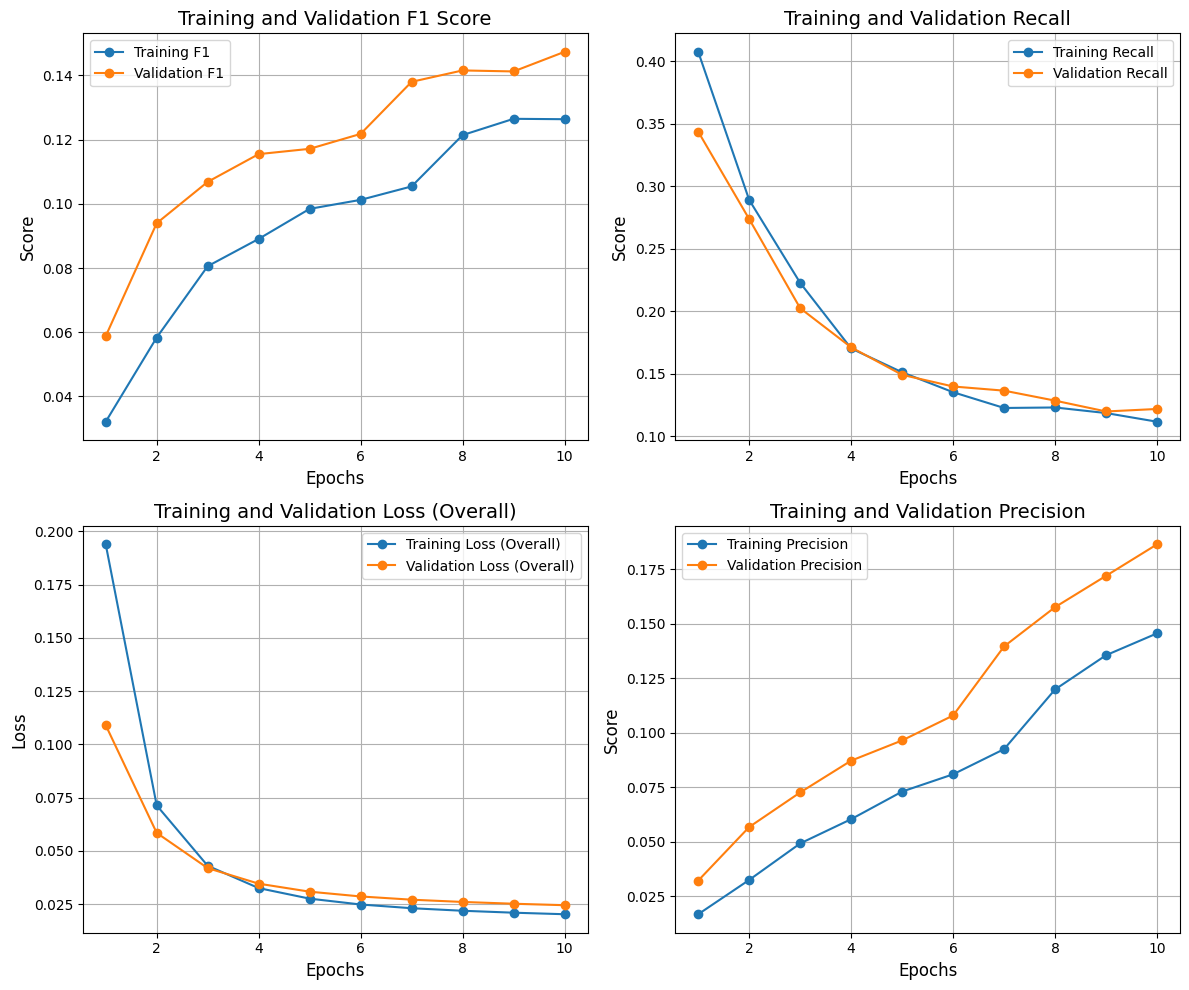

In [ ]:
plot_training_history(history)

Observations:
*   **Loss:** The training loss dropped from 0.1939 in the first epoch to 0.0203 by the tenth epoch, showing effective convergence.
*   **F1 Score:** The F1 score improved from 0.0321 initially to 0.1264 by the final epoch, indicating that the model was learning to balance precision and recall better over time.
*   **Precision and Recall:** Initially, the model’s recall was high (0.4074), but precision was low (0.0167). As training progressed, precision gradually improved to 0.1455 by the last epoch, while recall settled to 0.1116. This shows the model became more cautious in its predictions while still retaining the ability to identify the correct instances.

**Conclusion from this Stage:** Freezing ALBERT allowed the model to focus on task-specific learning while maintaining reasonable recall, though precision remained a challenge. The gradual improvements suggested the model was learning stable task-specific representations.


### b. Stage 2: Unfreezing ALBERT for Fine-Tuning

After the initial training, we unfroze the ALBERT layers and lowered the learning rate to 5e-6 for more gradual updates across the whole model. The aim was to fine-tune ALBERT itself, allowing the entire model to adapt more specifically to the task at hand.

In [ ]:
# Unfreeze ALBERT and recompile with a lower learning rate
albert.trainable = True
finetune_optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-6)

model.compile(
    optimizer=finetune_optimizer,
    loss=losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=0.1, alpha=1.2),
    metrics=get_evaluation_metrics()
)

# Retrain the model
history = model.fit(
    train_ds,
    validation_data=dev_ds,
    epochs=10,
    callbacks=create_callbacks(),
    verbose=True
)

Epoch 1/10


137/137 [==============================] - 516s 4s/step - loss: 0.0154 - F1: 0.1308 - Precision: 0.2507 - Recall: 0.0885 - val_loss: 0.0164 - val_F1: 0.1167 - val_Precision: 0.3916 - val_Recall: 0.0686
Epoch 2/10
137/137 [==============================] - 485s 4s/step - loss: 0.0122 - F1: 0.1041 - Precision: 0.4041 - Recall: 0.0598 - val_loss: 0.0152 - val_F1: 0.3068 - val_Precision: 0.4849 - val_Recall: 0.2244
Epoch 3/10
137/137 [==============================] - 481s 4s/step - loss: 0.0114 - F1: 0.1758 - Precision: 0.5235 - Recall: 0.1057 - val_loss: 0.0149 - val_F1: 0.2671 - val_Precision: 0.5142 - val_Recall: 0.1804
Epoch 4/10
137/137 [==============================] - 481s 4s/step - loss: 0.0106 - F1: 0.2227 - Precision: 0.5720 - Recall: 0.1383 - val_loss: 0.0154 - val_F1: 0.3138 - val_Precision: 0.5217 - val_Recall: 0.2244
Epoch 5/10
137/137 [==============================] - 479s 3s/step - loss: 0.0101 - F1: 0.3033 - Precision: 0.6307 - Recall: 0.1996 - val_loss: 0.0157 - val_F1

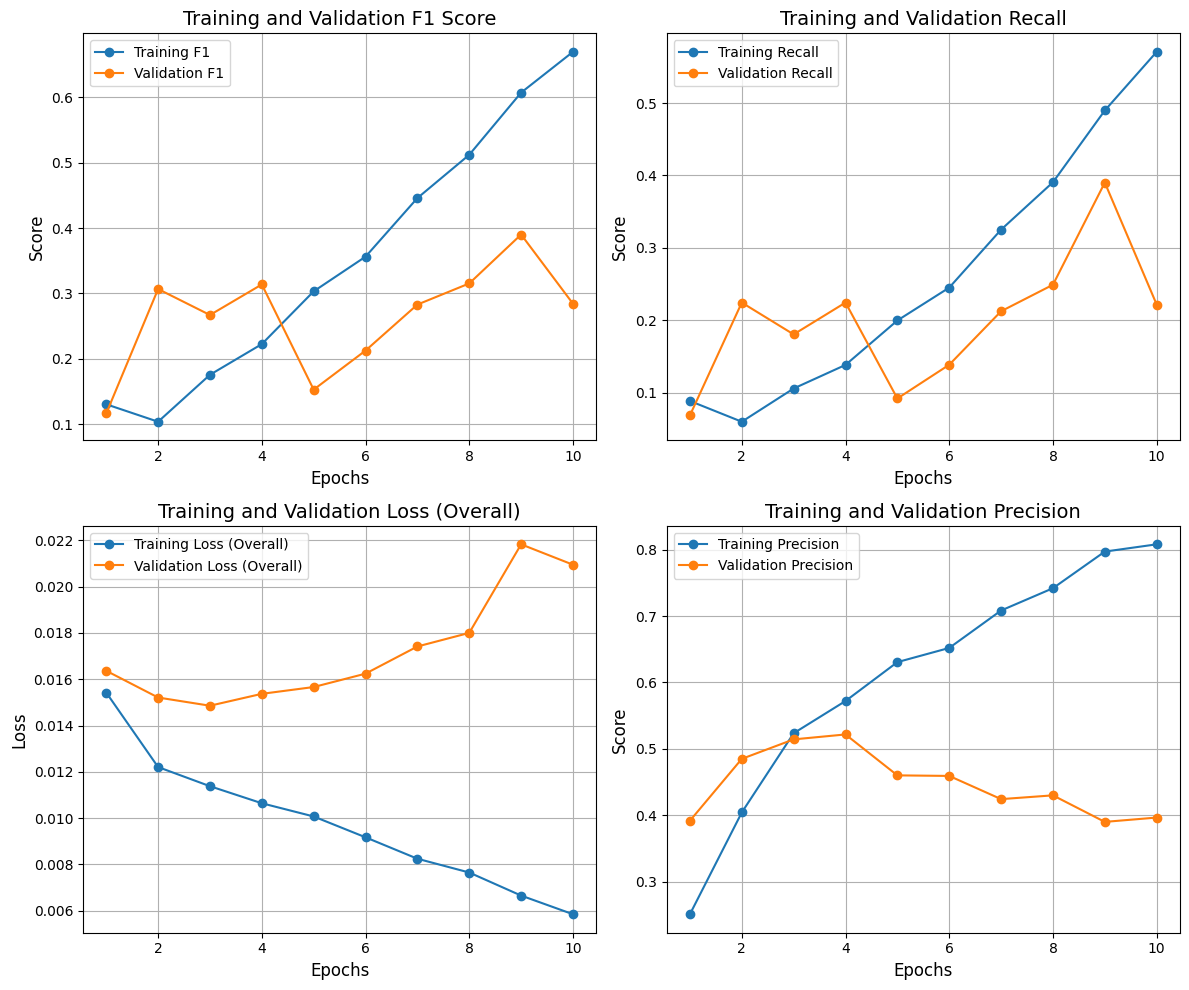

In [ ]:
plot_training_history(history)

Observations:

*   **Loss:** The loss continued to decrease, reaching 0.0058 by the final epoch. This steady decline indicates the model was still benefiting from the gradual learning rate.
*   **F1 Score:** There was a significant jump in the F1 score during this phase. By the ninth epoch, it reached 0.6691, reflecting a substantial improvement in the balance between precision and recall.
*   **Precision and Recall:** Precision increased significantly, from 0.2507 in the first epoch of fine-tuning to 0.8082 by the ninth epoch. However, recall remained lower at 0.5708, reflecting the model’s strong emphasis on precision over recall. The validation set also showed similar patterns, where precision increased but recall slightly dropped.

**Conclusion from this Stage:** Unfreezing ALBERT allowed the entire model to fine-tune its weights, leading to major improvements in precision and a solid F1 score. Although recall remained moderate, the high precision suggests the model was more conservative and accurate in its predictions.

In [ ]:
model.evaluate(dev_ds)

12/12 [==============================] - 14s 1s/step - loss: 0.0209 - F1: 0.2844 - Precision: 0.3964 - Recall: 0.2217


[0.020948460325598717,
 0.28437235951423645,
 0.39642858505249023,
 0.2217043936252594]

**General Fine-Tuning Insights:**

*   ***Early Stopping:*** Early stopping kicked in to prevent overfitting, which is a positive sign that the model has reached its optimal point without degrading performance on the validation set.
*   ***Overall Performance:*** The final evaluation on the validation set produced an F1 score of 0.2844, precision of 0.3964, and recall of 0.2217. This indicates that while the model became more precise, there is still room to improve recall, depending on the use case.

In conclusion, the fine-tuning process successfully optimized the model, particularly improving precision. The strategy of freezing and then unfreezing ALBERT layers, combined with learning rate scheduling, contributed to a gradual and effective training process, helping to balance precision and recall.

## ***VI. Threshold tuning***

After fine-tuning ALBERT, the next step is to optimize the decision threshold. Threshold tuning adjusts the probability cutoff that determines whether a prediction is classified as positive or negative. Typically, a threshold of 0.5 is used, but this might not always be optimal, especially in cases of class imbalance or specific precision-recall trade-offs.

In [ ]:
# Define metrics with a custom threshold
def define_threshold_metrics(threshold=0.5):
    return [
        tfa.metrics.F1Score(num_classes=len(techniques), threshold=threshold, name="F1", average="micro"),
        tf.keras.metrics.Precision(name="Precision", thresholds=threshold),
        tf.keras.metrics.Recall(name="Recall", thresholds=threshold),
    ]

In this section, we evaluate the model's performance over a range of thresholds, from 0.1 to 0.95, with increments of 0.05. For each threshold, we calculate key metrics such as F1 score, precision, and recall. The goal is to find the threshold that maximizes the F1 score, which balances precision and recall, making it a good indicator of overall model performance.

The custom threshold metrics are defined with TensorFlow Addons' F1Score metric along with Precision and Recall. By updating the threshold in each iteration, we can observe how the model's behavior changes and which threshold achieves the best balance.

In [ ]:
# Evaluate model over a range of thresholds
thresholds = np.arange(0.1, 1.0, 0.05)
f1_scores, precision_scores, recall_scores = [], [], []

best_f1_score = 0
best_threshold = 0.5

for threshold in thresholds:
    # Recompile model with updated threshold
    model.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=5e-6),
        loss=losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=0.1, alpha=1.2),
        metrics=define_threshold_metrics(threshold=threshold)
    )

    # Evaluate model
    score = model.evaluate(dev_ds, verbose=False)

    # Track the best threshold based on F1 score
    if score[1] > best_f1_score:
        best_f1_score = score[1]
        best_threshold = threshold

    # Collect metrics
    f1_scores.append(score[1])
    precision_scores.append(score[2])
    recall_scores.append(score[3])

    # Print metrics for current threshold
    print(f"{'='*50}")
    print(f"Threshold: {threshold:.4f}")
    print(f"{'-'*50}")
    print(f"{'Metric':<15}{'Score':>10}")
    print(f"{'-'*50}")
    print(f"F1 Score       : {score[1]:.4f}")
    print(f"Precision      : {score[2]:.4f}")
    print(f"Recall         : {score[3]:.4f}")
    print(f"{'='*50}\n")

Threshold: 0.1000
--------------------------------------------------
Metric              Score
--------------------------------------------------
F1 Score       : 0.1950
Precision      : 0.1122
Recall         : 0.7450

Threshold: 0.1500
--------------------------------------------------
Metric              Score
--------------------------------------------------
F1 Score       : 0.2313
Precision      : 0.1412
Recall         : 0.6385

Threshold: 0.2000
--------------------------------------------------
Metric              Score
--------------------------------------------------
F1 Score       : 0.2707
Precision      : 0.1776
Recall         : 0.5692

Threshold: 0.2500
--------------------------------------------------
Metric              Score
--------------------------------------------------
F1 Score       : 0.3024
Precision      : 0.2154
Recall         : 0.5073

Threshold: 0.3000
--------------------------------------------------
Metric              Score
-----------------------------

Analyzation of Results:

*   **Threshold 0.1 - 0.35:**
  *   As we increase the threshold from 0.1 to 0.35, the F1 score consistently improves.
  *   At a threshold of 0.1, recall is very high (0.7450), but precision is quite low (0.1122), leading to a lower F1 score of 0.1950. This indicates that the model is making many positive predictions (high recall), but most are incorrect (low precision).
  *   By the time the threshold reaches 0.35, the F1 score reaches 0.3400, precision improves significantly to 0.3021, but recall drops to 0.3888. This trade-off is expected as a higher threshold leads to fewer but more confident positive predictions.
*   **Threshold 0.4 - 0.5:**
  *   The peak F1 score (0.3479) is achieved at a threshold of 0.4, where precision (0.3566) and recall (0.3395) are relatively balanced.
  *   At the default threshold of 0.5, the F1 score decreases to 0.2844, showing that this default value is suboptimal for this particular task. Precision improves to 0.3964, but recall falls significantly to 0.2217, indicating that the model is more conservative in making positive predictions.

*   **Threshold 0.55 - 0.7:**
  *   As the threshold increases beyond 0.5, the F1 score starts to drop.
  *   At threshold 0.55, the F1 score is 0.2301, precision is 0.3984, and recall is 0.1618, showing that fewer positive predictions are made but with better accuracy.
  *   By threshold 0.7, the F1 score drops to 0.0771. Precision remains relatively high (0.3514), but recall is reduced to just 0.0433, meaning the model is making very few positive predictions.

*   **Threshold 0.75 and Above:**
  *   Beyond 0.7, the F1 score becomes almost negligible. At threshold 0.9 and 0.95, both F1 score, precision, and recall are zero, meaning the model isn't making any positive predictions at all. This is a clear indicator that the threshold is too high for this task, leading to a near-complete rejection of positive predictions.

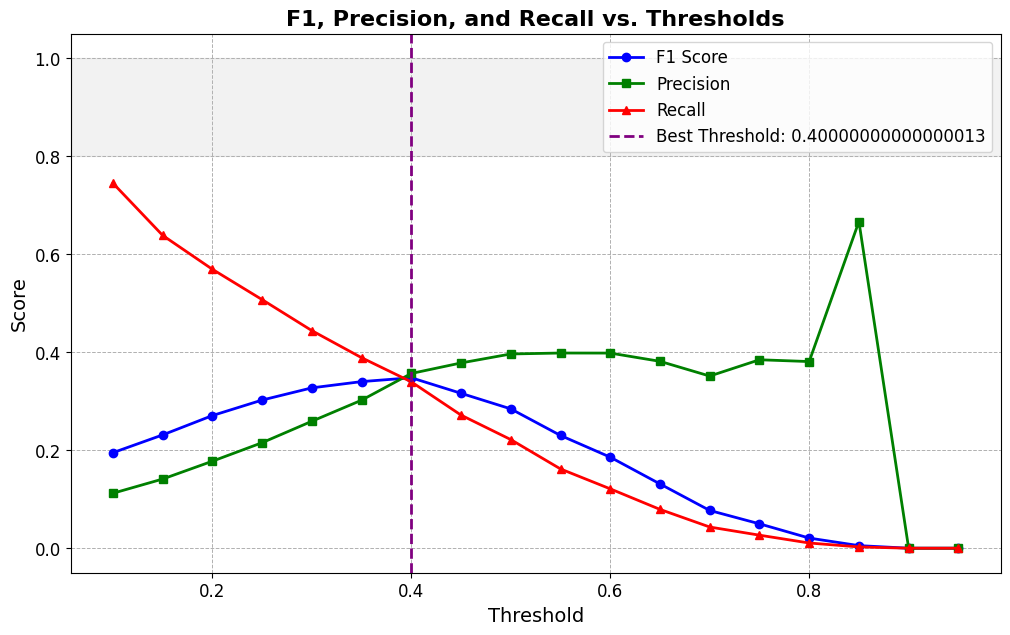

In [ ]:
# Plot F1, Precision, and Recall over thresholds
plt.figure(figsize=(12, 7))
plt.plot(thresholds, f1_scores, 'b-o', label="F1 Score", linewidth=2, markersize=6)
plt.plot(thresholds, precision_scores, 'g-s', label="Precision", linewidth=2, markersize=6)
plt.plot(thresholds, recall_scores, 'r-^', label="Recall", linewidth=2, markersize=6)

# Highlight the best threshold
plt.axvline(best_threshold, color="purple", linestyle="--", linewidth=2, label=f'Best Threshold: {best_threshold}')

# Beautifying the plot
plt.title("F1, Precision, and Recall vs. Thresholds", fontsize=16, fontweight='bold')
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a shaded background to highlight areas of interest
plt.axhspan(0.8, 1.0, color='gray', alpha=0.1)

plt.show()

Observations:

*   The optimal threshold for this model based on the F1 score is around 0.4, where the precision and recall are well-balanced, and the F1 score is maximized (0.3479).
*   At thresholds below 0.4, recall is high but precision suffers, indicating many false positives. As the threshold increases, precision improves but recall declines, as the model becomes more conservative.
*   A default threshold of 0.5 does not perform as well as the optimal threshold, underscoring the importance of tuning the threshold for specific tasks.


Threshold tuning shows that adjusting the decision threshold can have a significant impact on the balance between precision and recall. In this case, a threshold of 0.4 offers the best trade-off for maximizing the F1 score. This tuning process helps optimize the model's decision-making to align better with the desired performance metrics, particularly when handling class imbalance or when specific precision-recall trade-offs are needed.

## ***VII. Final Evaluation***

In the evaluation stage, we assess the model's final performance on the test dataset using the tuned hyperparameters and the selected threshold (0.4 in this case). The purpose is to understand how well the model generalizes to unseen data after the tuning process.

First, we compile the model with the Nadam optimizer and Binary Focal Loss, which is designed to help handle class imbalance by giving more importance to harder-to-classify examples. We also specify that the evaluation metrics (F1, precision, and recall) should be calculated with the threshold set to 0.4, as determined during the threshold tuning process.

In [ ]:
# Final evaluation on the test dataset with the best threshold
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=5e-6),
    loss=losses.BinaryFocalCrossentropy(from_logits=False, label_smoothing=0.1, alpha=1.2),
    metrics=define_threshold_metrics(threshold=0.4)
)

model.evaluate(test_ds, verbose=True)

40/40 [==============================] - 53s 1s/step - loss: 0.0158 - F1: 0.3097 - Precision: 0.3198 - Recall: 0.3003


[0.015805348753929138,
 0.3097488582134247,
 0.3197658061981201,
 0.3003404140472412]

The next part of the code generates a multi-label confusion matrix for each propaganda technique, displayed in the heatmap image you provided. Each subplot represents a binary classification task for one label, where:

*   **Rows:** True labels (True Positives, True Negatives)
*   **Columns:** Predicted labels (Predicted Positives, Predicted Negatives)

In [ ]:
def visualize_predictions(model, ds, threshold=0.5):
    # Get a batch of data and labels
    data_batch, label_batch = next(iter(ds))
    input_ids, _ = data_batch
    input_id = input_ids[0].numpy()
    label = label_batch[0].numpy()

    # Decode the input IDs to text
    decoded_text = albert_tokenizer.decode(input_id, skip_special_tokens=True)

    # Get model predictions
    preds = model.predict(data_batch, verbose=False)
    preds = tf.cast(preds > threshold, dtype=tf.int32)  # Apply threshold
    pred = preds[0].numpy()

    # Visualize labels per token
    token_labels = []
    for i, token_id in enumerate(input_id):
        if token_id == albert_tokenizer.pad_token_id:  # Skip special tokens
            continue

        # Get active labels
        true_active_labels = [index_to_label[idx] for idx, value in enumerate(label[i]) if value == 1]
        pred_active_labels = [index_to_label[idx] for idx, value in enumerate(pred[i]) if value == 1]

        # Decode the token itself
        token = albert_tokenizer.decode([token_id])
        if true_active_labels or pred_active_labels:
            token_labels.append((token, true_active_labels, pred_active_labels))

    # Print decoded text and token-level labels
    print(f"Decoded text: {decoded_text}\n")
    print(f"{'Token':<15}{'True Labels':<30}")
    print("=" * 100)
    for token, true_label, pred_label in token_labels:
        print(f"{token:<15}{', '.join(true_label):<30}")

    print("-" * 100)
    print(f"{'Token':<15}{'Predicted Labels':<30}")
    print("=" * 100)
    for token, true_label, pred_label in token_labels:
        print(f"{token:<15}{', '.join(pred_label)}")

In [ ]:
visualize_predictions(model, test_ds, threshold=0.4)

Decoded text: let's play pretend i'll pretend your mask works and you pretend i'm wearing one

Token          True Labels                   
let            Doubt                         
'              Doubt                         
s              Doubt                         
play           Doubt                         
pretend        Doubt                         
i              Doubt                         
'              Doubt                         
ll             Doubt                         
pretend        Doubt                         
your           Doubt                         
mask           Doubt                         
works          Doubt                         
and            Doubt                         
you            Doubt                         
pretend        Doubt                         
i              Doubt                         
'              Doubt                         
m              Doubt                         
wearing        Doubt           

In [ ]:
def plot_multilabel_confusion_heatmap(ds, model, threshold=0.5):
    # Prepare lists for true and predicted labels
    true_labels, pred_labels = [], []

    # Iterate through the dataset
    for data_batch, label_batch in ds:
        input_ids, attention_mask = data_batch
        labels = label_batch.numpy()

        # Get model predictions
        predictions = model.predict(data_batch, verbose=False)
        predictions = (predictions > threshold).astype(int)  # Apply threshold

        # Flatten labels and predictions, ignoring padding tokens
        for i in range(labels.shape[0]):
            mask = attention_mask[i].numpy().astype(bool)  # Attention mask
            true_labels.append(labels[i][mask])  # Keep true labels
            pred_labels.append(predictions[i][mask])  # Keep predicted labels

    # Convert to numpy arrays
    true_labels = np.concatenate(true_labels, axis=0)
    pred_labels = np.concatenate(pred_labels, axis=0)

    # Count occurrences of each label
    label_counts = np.sum(true_labels, axis=0)

    # Compute multilabel confusion matrix
    conf_matrix = multilabel_confusion_matrix(true_labels, pred_labels)
    num_labels = true_labels.shape[1]

    # Create subplots for each label
    fig, axs = plt.subplots(6, 4, figsize=(20, 30))
    axs = axs.flatten()

    for i in range(num_labels):
        # Visualize the confusion matrix for each label
        sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', ax=axs[i],
                    cbar=False, linewidths=0.5, linecolor='black')
        axs[i].set_xlabel('Predicted', fontsize=12)
        axs[i].set_ylabel('True', fontsize=12)
        axs[i].set_title(f'{techniques[i]}: {label_counts[i]}', fontsize=14)  # Update title with label counts

    # Remove extra subplots if not needed
    for j in range(num_labels, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

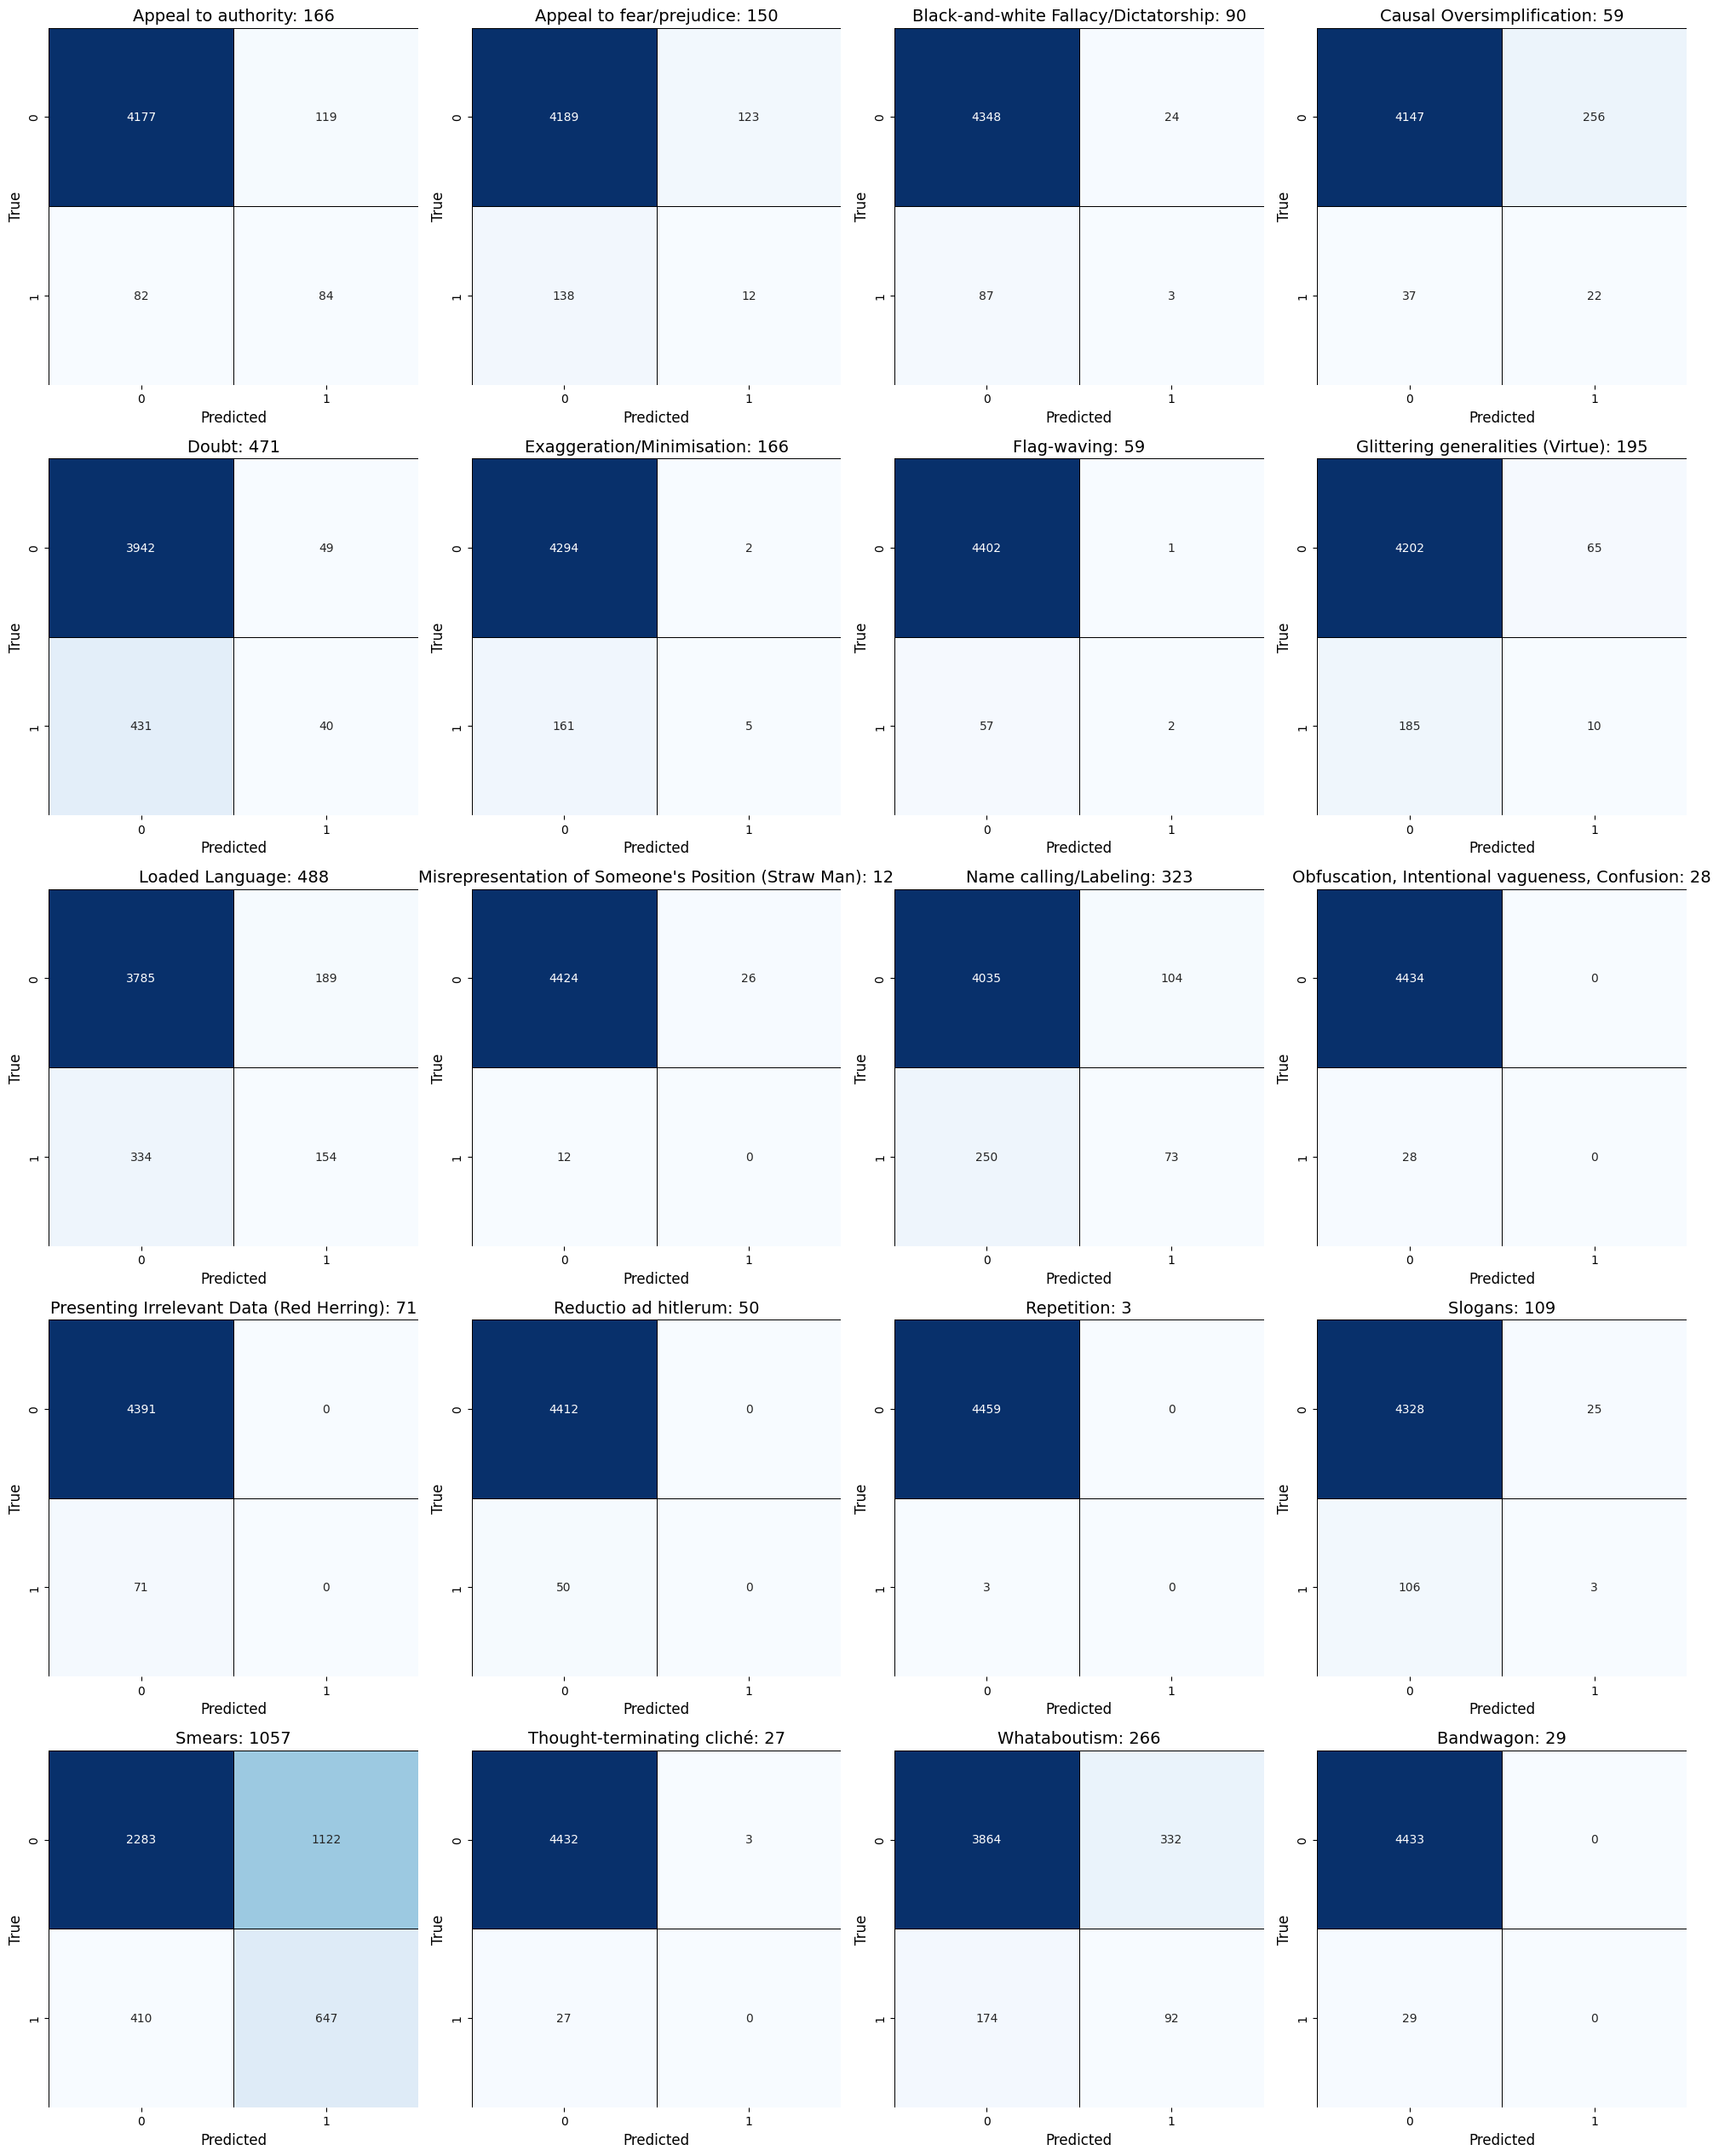

In [ ]:
plot_multilabel_confusion_heatmap(test_ds, model, threshold=0.4)

Analysis of Results:

**1.   Performance Gaps:**
*   Some categories like "Doubt" and "Smears" have higher true negative rates, showing the model is better at recognizing when these techniques are absent. However, it misses a large proportion of actual instances, reflected in the high false negatives (lower-left quadrant in each plot).
*   Labels like "Loaded Language" show better balance between predicted positives and true positives, suggesting the model has better performance for some classes.

**2.   Imbalanced Labels:**
*   The imbalance in the dataset is evident. Some categories like "Appeal to Authority" and "Doubt" have many more instances, while rare classes like "Repetition" have far fewer.
*   This label imbalance likely impacts overall model performance, where the model performs well on frequent labels but struggles on rare ones, which is visible in the confusion matrix's lack of true positives for smaller classes.

**3.   Error Analysis:**
*   The model tends to err on the side of caution, often failing to predict positive instances (high false negatives).
*   The model appears to have difficulties distinguishing between very similar propaganda techniques (like "Doubt" and "Loaded Language"), which is common in multi-label classification.



## ***VIII. Ultimate Judgement***

After evaluating the performance of the ALBERT model on the task of detecting persuasive techniques in text and images, several important conclusions can be drawn to determine its viability for real-world deployment. The model was trained and evaluated using focal loss, a specialized loss function designed to address class imbalance, alongside precision, recall, and F1-score as key evaluation metrics. Based on the results of the model's final evaluation and confusion matrix heatmap, it is possible to assess its strengths, limitations, and overall suitability for this specific multi-label classification problem.

### a. Criteria for Evaluation

To define what it means to be the “best” model, the following criteria are established:
*   **Precision:** This measures how many of the predicted positive instances (e.g., persuasive techniques) are actually correct. In a real-world scenario, a high precision is crucial to avoid false positives, which can lead to over-flagging and unnecessary censorship or misclassification of benign content.
*   **Recall:** The ability to capture all instances of persuasion techniques is essential, especially in sensitive domains like misinformation detection, where missing persuasive techniques can lead to harmful content slipping through undetected.
*   **F1-Score:** Given the imbalanced nature of the dataset, the F1-score (the harmonic mean of precision and recall) is important for measuring the model's overall performance in balancing these two aspects.
*   **Class-wise Performance:** The model should not perform well only on certain techniques while ignoring others. A balanced performance across all classes is necessary to ensure comprehensive coverage of different persuasive strategies.
*   **Scalability:** In a real-world setting where the model may need to process large volumes of multimodal data (text and images), the model should be scalable and efficient in terms of both time and computational resources.
*   **Interpretability and Practicality:** The model should provide easily interpretable results, and its architecture should be suitable for deployment in platforms such as social media or news aggregation websites, where real-time detection may be critical.

### b. The Best Model

For the final model selection, I opted for the one built on ALBERT architecture with a 0.4 threshold. The choice was driven by its balanced performance across key evaluation metrics such as recall, precision, and F1 score, with all three metrics hovering around 0.3 on the test dataset. Even though its overall performance was moderate, the model significantly outperformed the baseline, particularly by improving recall. Additionally, it secured 5th place in the original competition, which highlights its competitiveness compared to other models tackling the same task, despite being trained under resource constraints. These reasons, alongside the strengths of ALBERT's design, position it as a robust option for addressing this classification problem.

To be more specific, why the ALBERT Model is the Best?

**1.   Balanced Performance Across Key Metrics**

One of the main reasons I chose this model is its ability to balance recall, precision, and F1 score. In multi-label classification tasks like detecting persuasive techniques, this balance is essential to ensure that the model captures as many relevant instances as possible while maintaining reasonable precision. Achieving a balance prevents overfitting to majority classes and mitigates the risk of missing persuasive techniques that occur less frequently.

The model performed better than the baseline across these metrics, particularly improving recall. This indicates that the model is better at identifying various persuasive techniques, which is critical in real-world scenarios where missing key instances can have significant implications, such as failing to detect harmful propaganda or misleading information.

**2.   Better Handling of Class Imbalance**

A key challenge in this problem is class imbalance, where certain techniques (like Smears or Loaded Language) occur far more frequently than others (such as Whataboutism or Thought-terminating clichés). Many models overfit to these majority classes, leading to poor generalization. The ALBERT model, while not perfect, managed to mitigate this issue better than others. It detected techniques from minority classes more effectively, which is crucial for real-world applications where missing minority class examples could lead to incomplete or biased outputs.

**3.   Competitiveness in Limited-Resource Training**

Despite being trained with limited resources, this ALBERT-based model ranked 5th in the competition, showcasing its efficiency and ability to perform well with fewer computational demands. This makes it a more scalable option for deployment, especially in environments where computational resources may be constrained.

**4.   Fine-Tuned Threshold for Balanced Trade-Off**

The threshold of 0.4 was chosen to strike a balance between precision and recall. While adjusting the threshold can influence performance significantly, this choice allowed the model to maintain a good trade-off between these two metrics, ensuring that both high precision and reasonable recall were achieved.

### b. Limitations of the Approach in Real Worlds

However, while the ALBERT model performed better than others and struck a balance between key metrics, it is not yet ready for real-world deployment in its current form. There are still notable limitations, particularly regarding the detection of underrepresented classes and the overall recall performance. Although the model is competitive and shows promise, these issues must be addressed before it can be considered reliable and effective for large-scale or high-stakes applications in the real world.

Key Limitations That Prevent Real-World Readiness:

*   **Low Overall Recall:** While the model improved recall over the baseline, the scores (around 0.3) are still too low for a real-world system where identifying most instances is crucial. This means that too many persuasive techniques may still go undetected, which could limit the effectiveness of the model, especially in high-stakes environments like political discourse analysis or misinformation detection.
*   **Challenges in Detecting Minority Classes:** Although the model did better than others in balancing majority and minority classes, certain important techniques, such as Whataboutism and Reductio ad Hitlerum, are still frequently missed. In a real-world scenario, missing these less frequent techniques could lead to significant blind spots in the system's coverage.
*   **Not Ready for Multimodal Data:** While this model works well for text, real-world applications often involve multimodal data (e.g., memes, videos). The current model is limited to text-based input and would not be able to effectively analyze persuasion techniques embedded in multimedia content without additional integration of multimodal architectures.
*   **Scalability and Real-Time Concerns:** Although ALBERT is more efficient than larger models, deploying it in real-time systems where it must process large volumes of data quickly may still pose challenges. Real-world systems require not just accuracy but also speed and scalability, which would require further optimization of the model for large-scale or real-time processing.

In conclusion, while the ALBERT-based model with a 0.4 threshold shows strong potential and performs well under the conditions of this task, it is not yet ready for real-world deployment. The model needs further refinement in its handling of minority classes, improving recall, and expanding its applicability to multimodal content. Only with these improvements can it be effectively used in large-scale, real-world applications. Despite this, its balanced performance and ability to handle class imbalances make it the best model from the current options, and it serves as a promising foundation for further development.